<h1>Differential Analysis of Mass2Motifs</h1>

This notebook demonstrates how we can perform a differential analysis based on Mass2Motifs. Spectra are clustered using a simple greedy cosine clustering scheme. The PLAGE scores of the resulting cosine clusters are then compared to the PLAGE scores of Mass2Motifs.

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../MS2LDA/python'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx

from IPython.display import display
import math
import csv

from lda_for_fragments import Ms2Lda
from peak_match import MS2MZM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>Helper methods</h2>

In [21]:
def turn_clustering_into_graph(peak_names, clustering):

    # make the node names
    assert len(peak_names) == len(clustering)
    new_peak_names = ["doc_%s" % pn for pn in peak_names]
    new_clustering = ["cluster_%d" % k for k in clustering]
        
    # assign unique ids for each node to be added into the graph
    node_names = list(set(new_peak_names+new_clustering))
    node_ids = range(len(node_names))
    id_name_map = dict(zip(node_names, node_ids))    
    
    # insert the nodes into the graph and draw the edges between them
    G = nx.Graph()
    for n in range(len(new_peak_names)):
        
        pn = new_peak_names[n]
        k = new_clustering[n]
        
        doc_id = id_name_map[pn]
        cluster_id = id_name_map[k]

        tokens = pn.split('_')
        pid = int(tokens[3])
        display_name = "%s_%s_%s" % (tokens[0], tokens[1], tokens[2])
        G.add_node(doc_id, name=display_name, group=1, peakid=pid)
        G.add_node(cluster_id, name=k, group=2)
        G.add_edge(doc_id, cluster_id)
        
    return G

<h2>Run LDA</h2>

In [22]:
project_file = 'projects/Manuscript_Beer3POSmode_EFassigner_ALLextended.project'
ms2lda = Ms2Lda.resume_from(project_file)

Project loaded from projects/Manuscript_Beer3POSmode_EFassigner_ALLextended.project time taken = 23.6390738487
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = 11/30/15 16:11:30
 - message = Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses


In [23]:
ms2lda.do_thresholding(th_doc_topic=0.05,th_topic_word=0.01)

In [24]:
annotation_file = 'annotations/beer3pos_annotation_Nov2015.csv'
t_annot = {}
for item in csv.reader(open(annotation_file), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    print str(key) + "\t" + val
    t_annot[key] = val

2	 "Small nitrogen containing fragment ion - often proline or ornithine derived"
260	 "Water loss - indicative of a free hydroxyl group"
262	 "Combined loss of H2O and CO
226	 "Loss of [hexose-H2O] - suggests hexose conjugation (e.g. glucose) substructure"
158	 "Leucine substructure"
243	 "Conjugation of a phosphate group (H4O4P) substructure"
127	 "Conjugation of a phosphate group (H4O4P) substructure"
53	 "Losses indicative of a hexose with NH2 group"
98	 "Fragments possibly indicative for N-Methyl-oxo-pyrrolidinecarboxylic acid like structure"
174	 "Pyroglutamic acid (pyroglutamate) substructure"
59	 "Pyroglutamic acid (pyroglutamate) substructure"
214	 "Amine loss - suggests free NH2 group in fragmented molecule"
60	 "Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain
151	 "[proline-H2O] suggests conjugated proline substructure"
280	 "Loss possibly indicative of carboxylic acid group with 1-carbon attached"
40	 "Imidazole group linked t

This cell takes the mzMATCHoutputPOS file and extracts the expression data for the specified control and case samples. As well as computing the fold change of all peaks for the graph, it can also compute a measure of how changed the topic is. This uses an algorithm called [PLAGE](http://www.biomedcentral.com/1471-2105/6/225) (several algorithms reviewed [here](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0079217#pone.0079217-Tomfohr1)). The basic idea is that it computes a `t` score (not quite equivalent to a t-test), the higher the better. Any values above a threshold (`t_thresh`) get plotted and will be highlighted pink in the graph. The plots show the normalised expression values as well as some PLAGE output.

In [25]:
mzmatchfile = 'input_files/peaks_FourBeersComparison.csv'

# Change the following to change the comparison
case = 'Beer_3_full'
control = 'Beer_QC_full'

t_thresh = 15

In [26]:
link = MS2MZM()
link.attach_mzfile(mzmatchfile)
link.attach_ms2lda(ms2lda)

In [27]:
link.find_links()

<h2>Run cosine clustering</h2>

In [28]:
method = 'greedy' # 'greedy', 'hierarchical'
peak_names, clustering = ms2lda.run_cosine_clustering(method, th_clustering=0.50)
peak_clustering_annot = {}
for pn, k in zip(peak_names, clustering):
    tokens = pn.split('_')
    key = "doc_%s_%s" % (tokens[0], tokens[1])
    value = 'cluster %d' % k
    peak_clustering_annot[key] = value
#     print "%s\t%s" % (key, value)

In [29]:
print "Number of clusters = %d" % clustering.max()

Number of clusters = 292


<h2>Run DE for LDA</h2>

The following cell runs PLAGE on the Mass2Motifs from LDA and plots the expression heatmaps.

300 topic/cluster nodes loaded

1. Mass2Motif 100 PLAGE score=6.006
 - doc_206.05527_614.625_10429
 - doc_251.12361_621.074_16625
 - doc_251.12364_626.051_16651

2. Mass2Motif 108 PLAGE score=3.063
 - doc_228.12298_264.331_13390

3. Mass2Motif 109 PLAGE score=13.930
 - doc_159.07637_599.71_5025
 - doc_251.13885_903.578_16702

4. Mass2Motif 127
 "Conjugation of a phosphate group (H4O4P) substructure" PLAGE score=3.748
 - doc_211.03666_399.823_11148
 - doc_211.10522_564.798_11160
 - doc_260.07391_624.805_17758
 - doc_270.09467_465.819_19030
 - doc_367.12097_631.311_30159
 - doc_367.1209_640.068_30155
 - doc_382.22224_229.71_31150

5. Mass2Motif 124 PLAGE score=2.603
 - doc_314.15894_851.554_25075
 - doc_314.15956_409.09_25086

6. Mass2Motif 122 PLAGE score=3.205
 - doc_1031.32647_670.092_34726
 - doc_1031.32661_661.235_34730
 - doc_275.17107_947.614_19684
 - doc_347.09473_568.532_27066
 - doc_347.09498_553.527_27080

7. Mass2Motif 123 PLAGE score=8.978
 - doc_277.08926_595.985_20084
 - d

/Users/joewandy/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/joewandy/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):



 - doc_132.11323_543.521_2457
 - doc_146.09229_643.79_3629
 - doc_228.14547_1121.66_13461
 - doc_308.14515_1009.05_24296
 - doc_316.16156_513.556_25164

290. Mass2Motif 80 PLAGE score=4.702
 - doc_133.09714_742.984_2552
 - doc_190.10731_841.31_8676
 - doc_206.15194_783.837_10568

291. Mass2Motif 82
 "Possibly suggests agmatine based substructure (C5H15N4) PLAGE score=6.140
 - doc_131.07033_453.384_2052
 - doc_131.11786_920.348_2161
 - doc_276.11874_610.882_19884
 - doc_291.04883_482.766_21892
 - doc_291.06867_597.228_21960
 - doc_291.0973_560.987_22068
 - doc_291.10492_549.717_22144
 - doc_291.11844_646.272_22190
 - doc_292.08735_477.597_22685
 - doc_292.08736_463.346_22711
 - doc_292.10232_545.999_22737
 - doc_307.09984_613.388_23984
 - doc_307.17674_547.239_24157
 - doc_337.17157_709.177_26464
 - doc_363.18432_799.464_28902
 - doc_374.79827_621.074_30475
 - doc_469.20826_494.275_33011
 - doc_561.69416_594.743_33982

292. Mass2Motif 83 PLAGE score=0.245
 - doc_222.0798_309.104_12317


/Users/joewandy/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


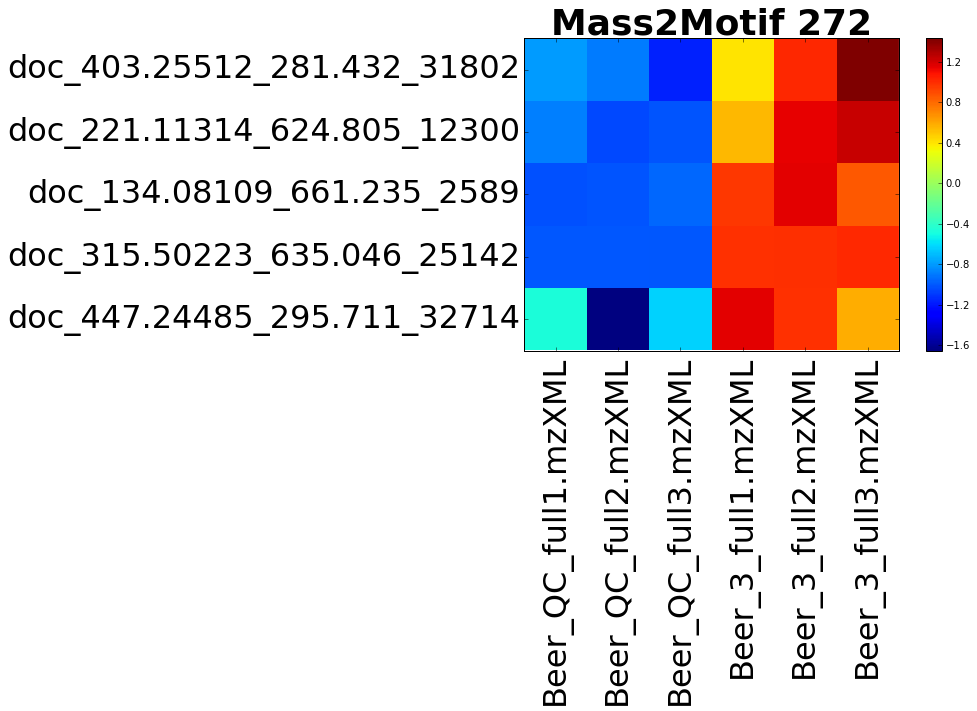

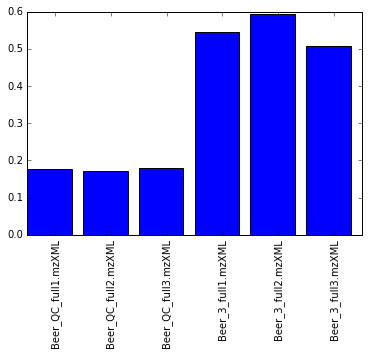

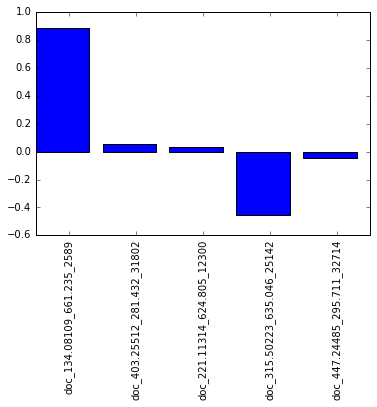

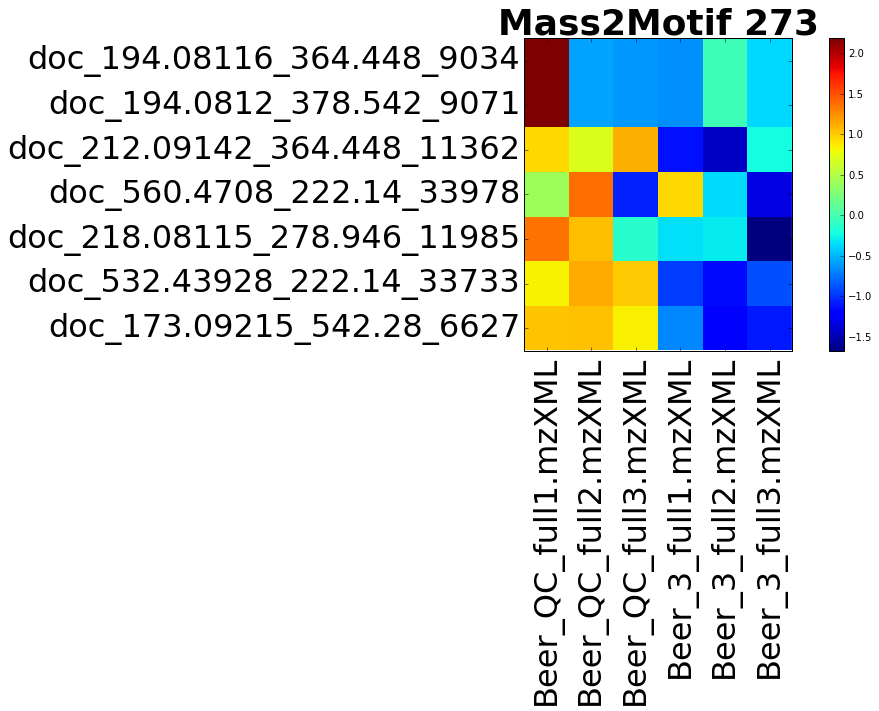

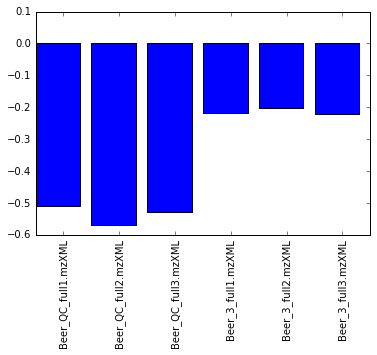

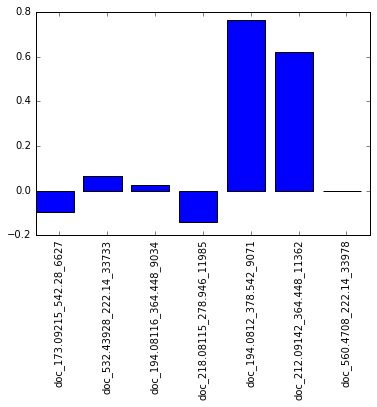

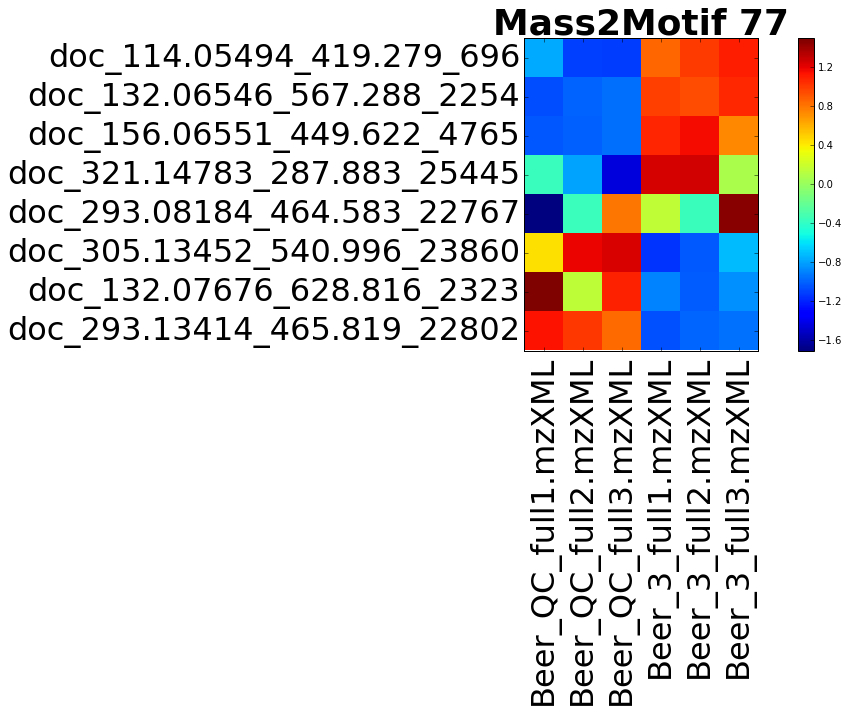

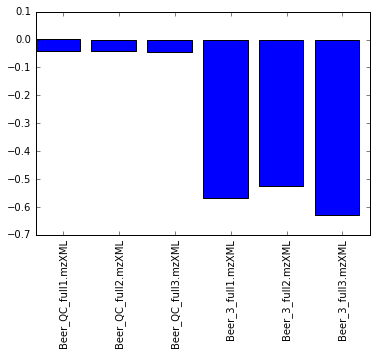

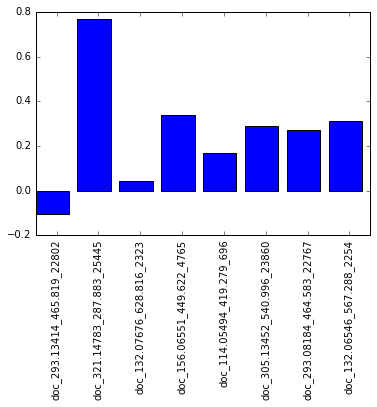

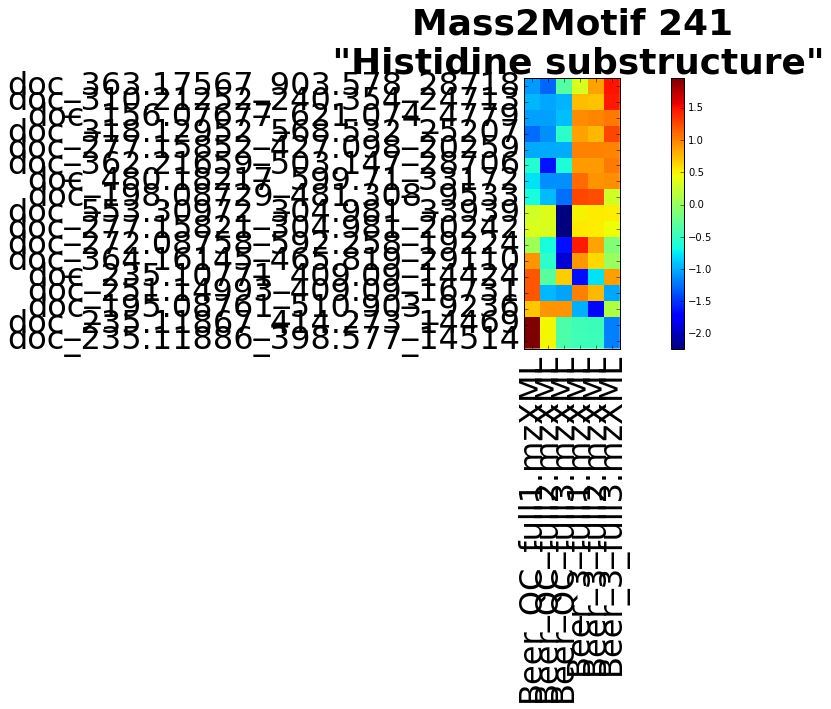

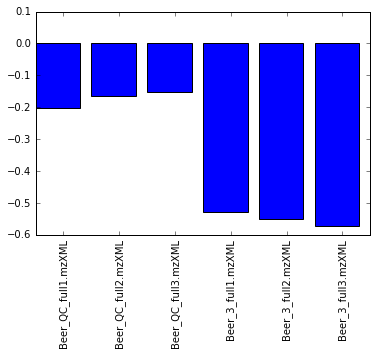

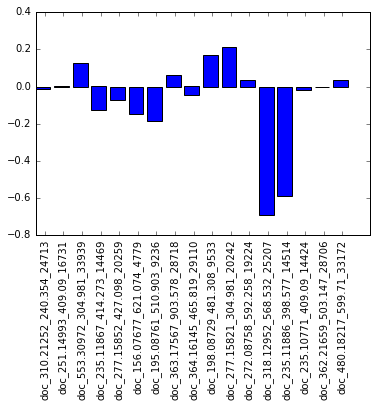

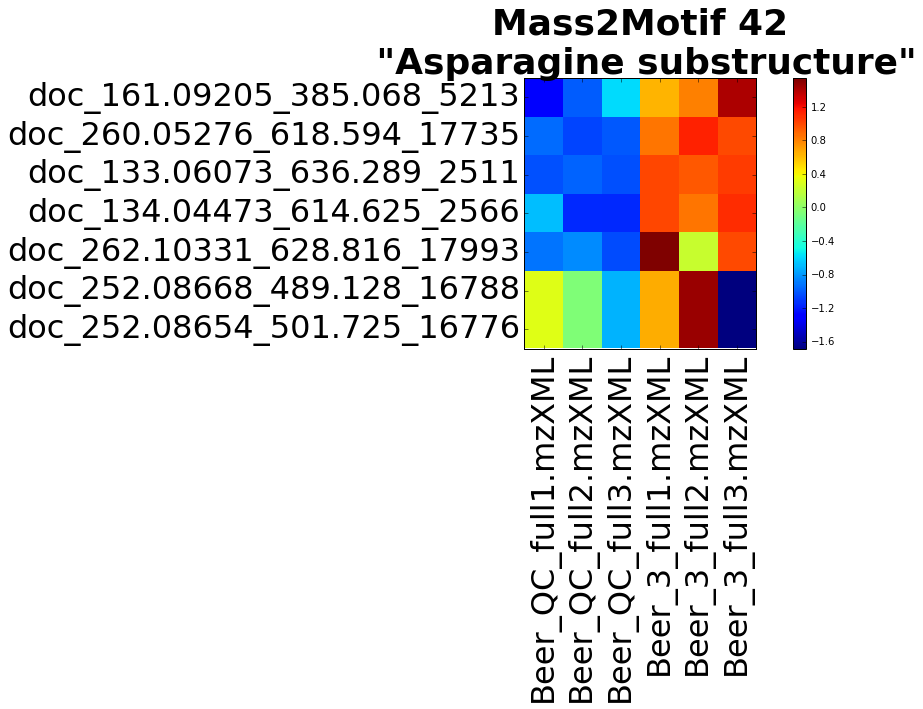

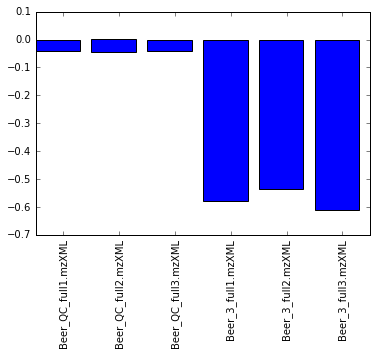

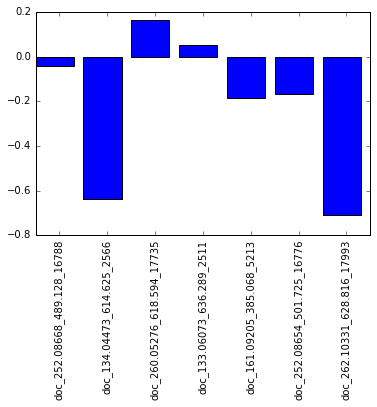

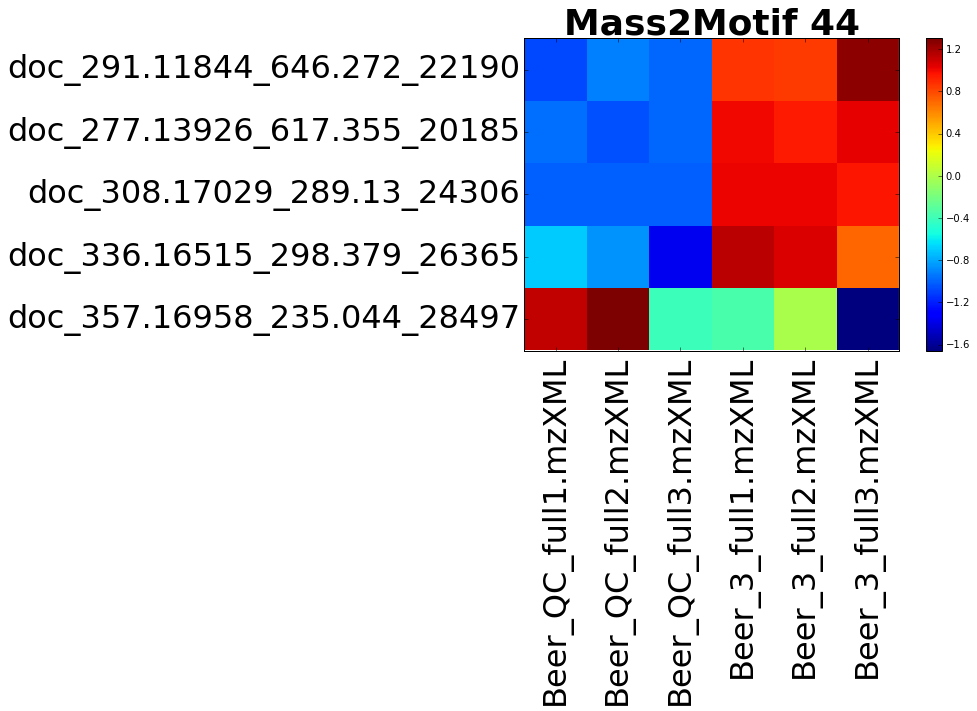

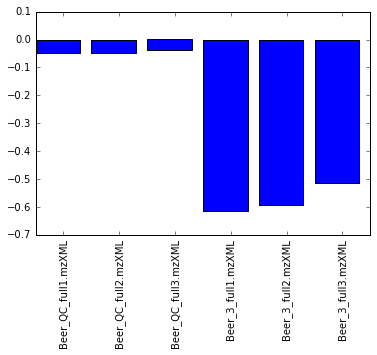

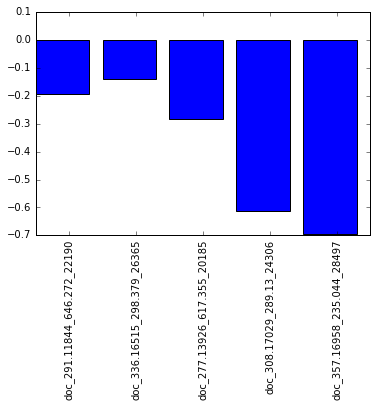

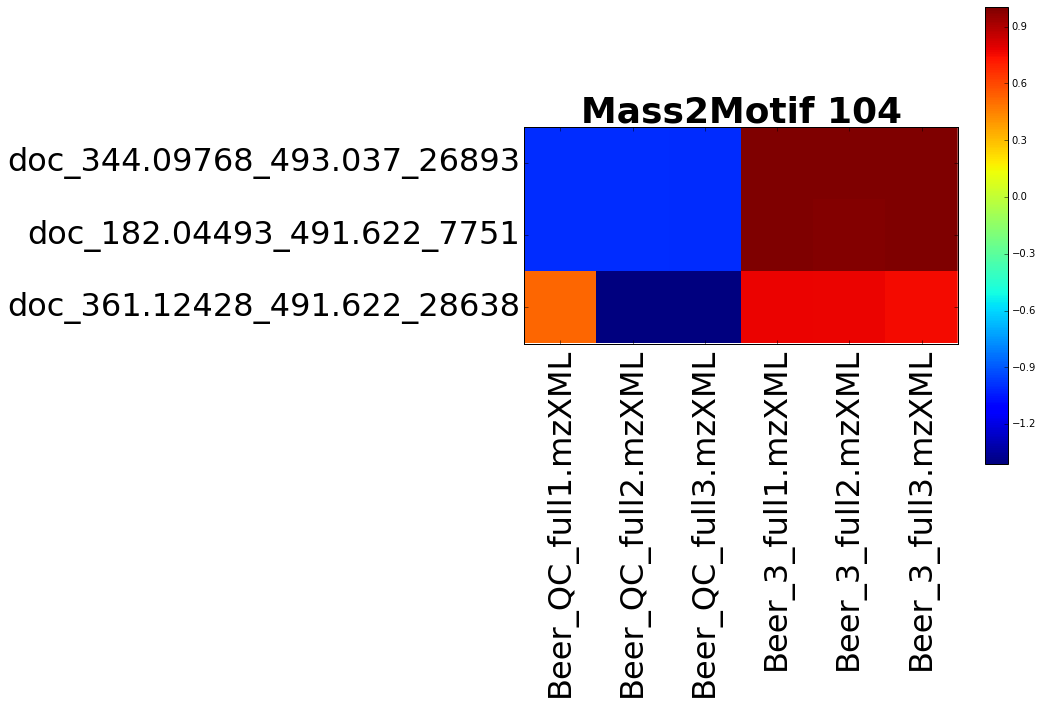

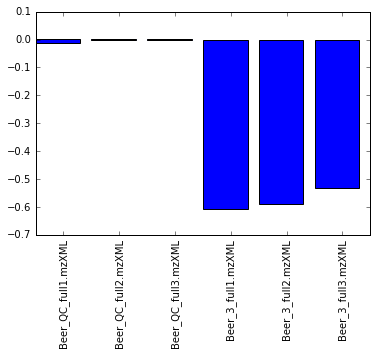

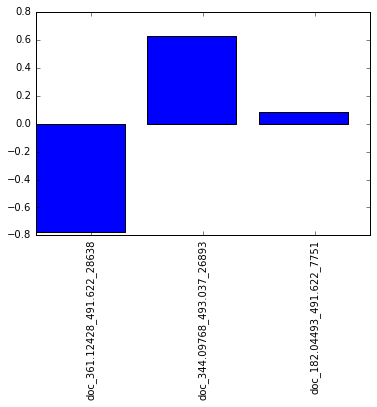

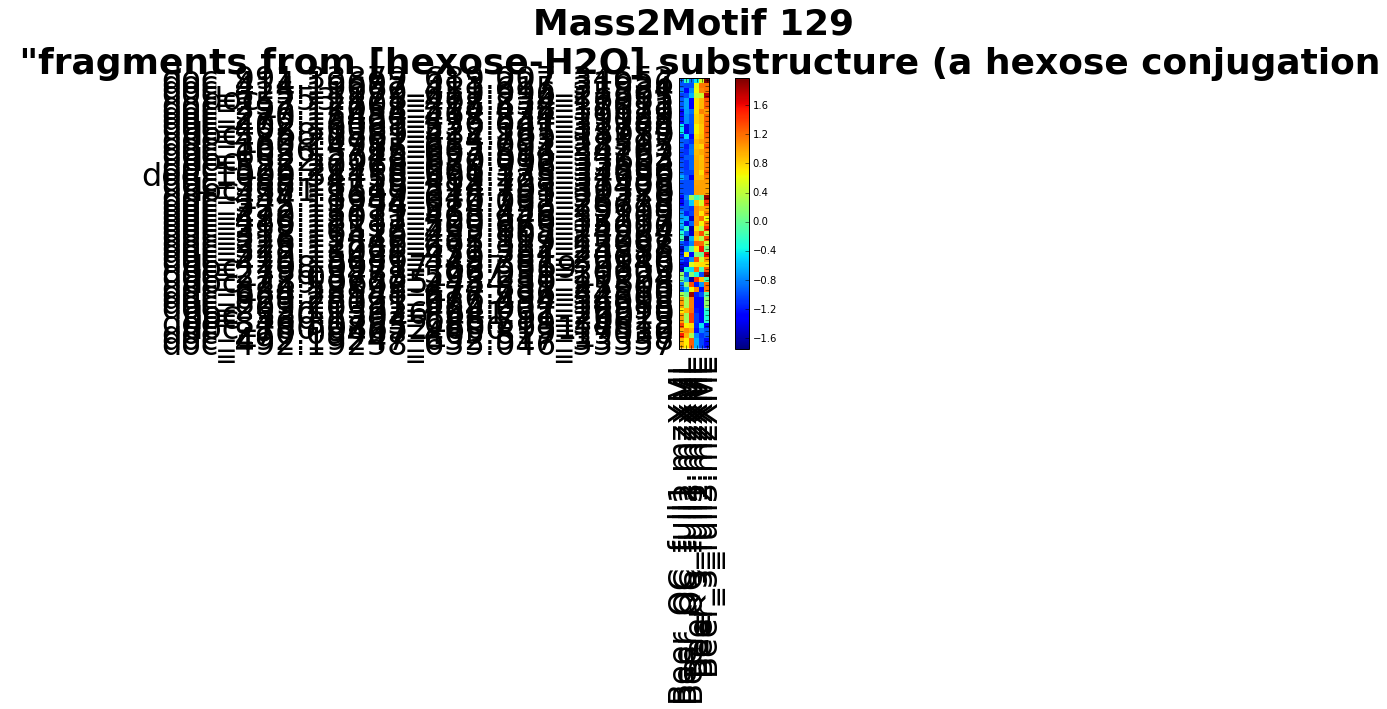

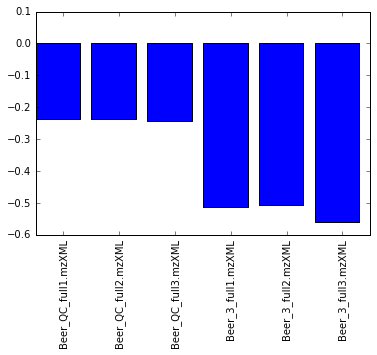

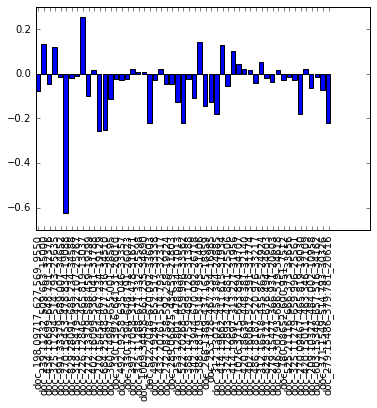

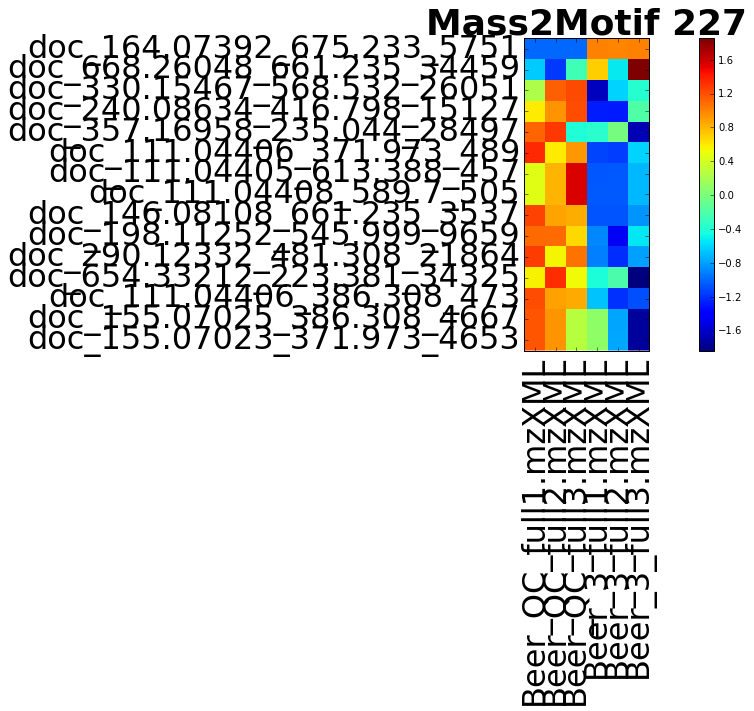

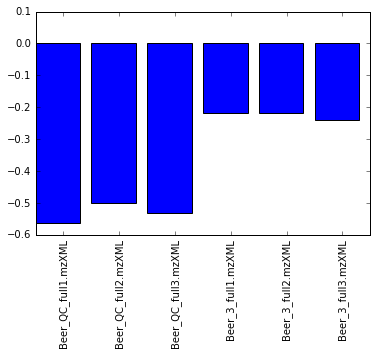

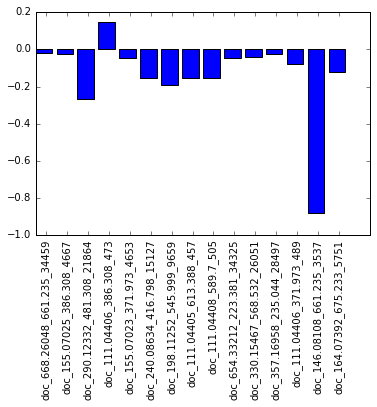

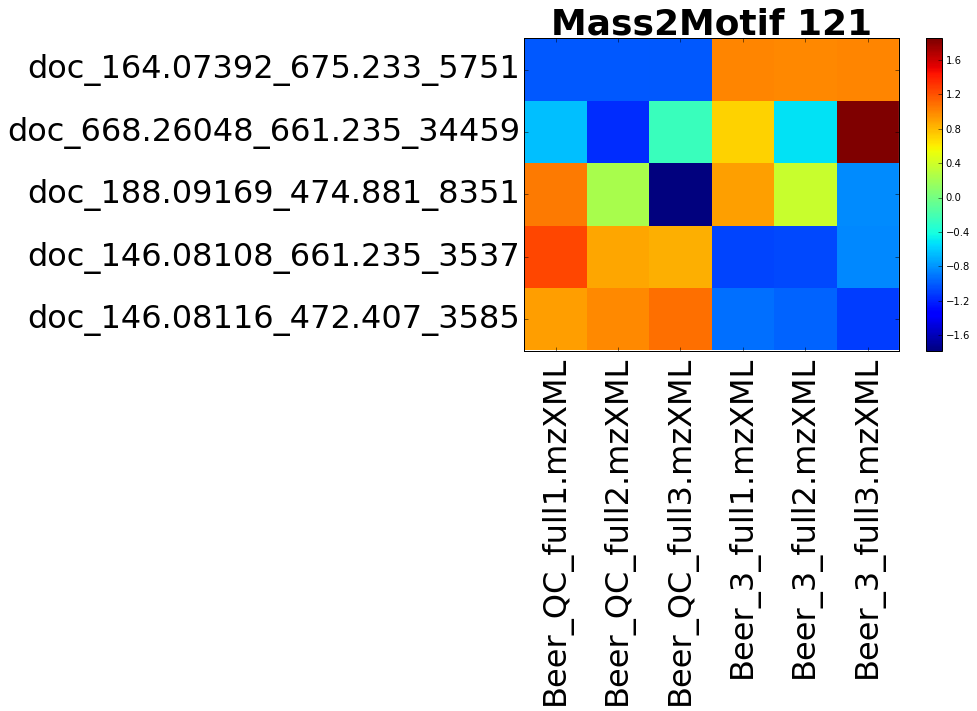

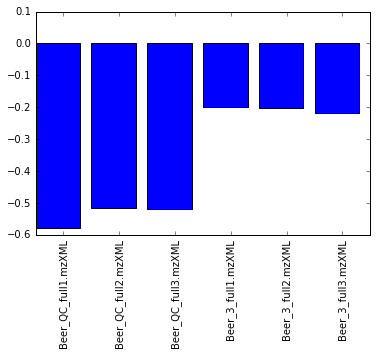

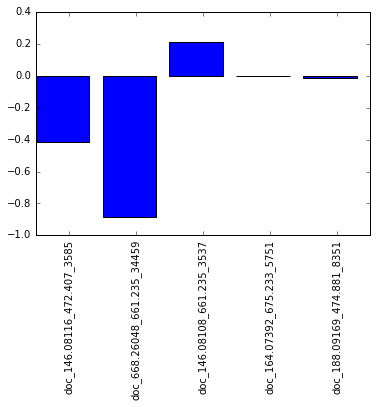

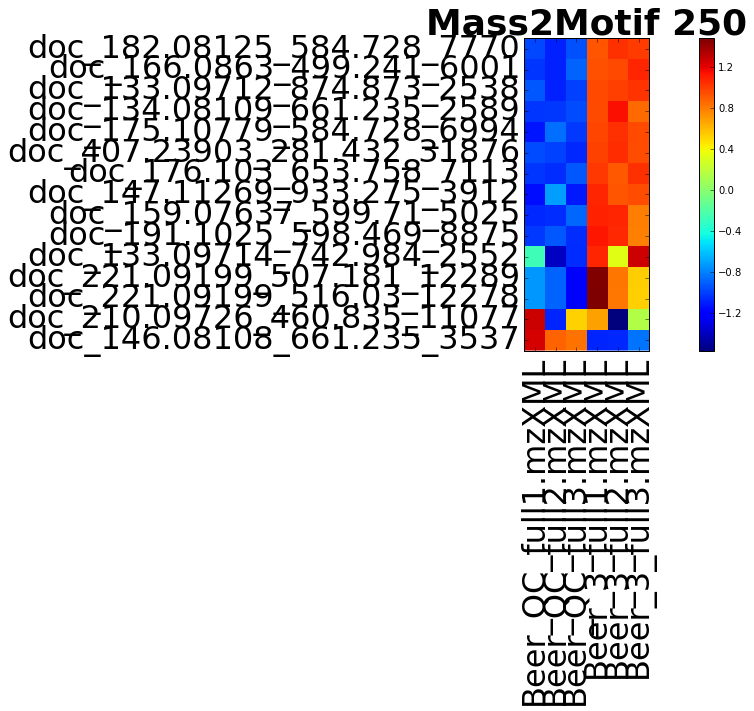

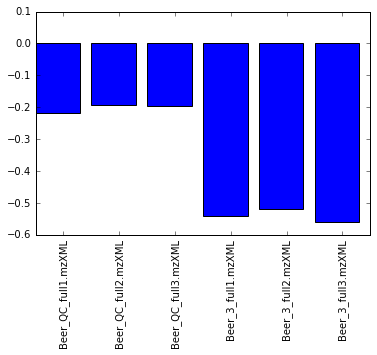

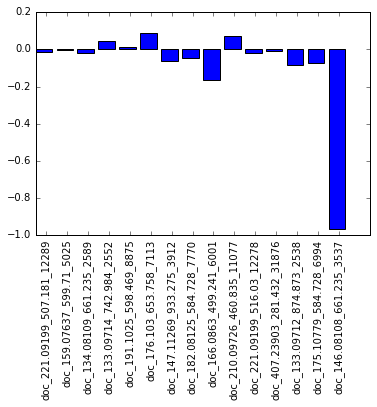

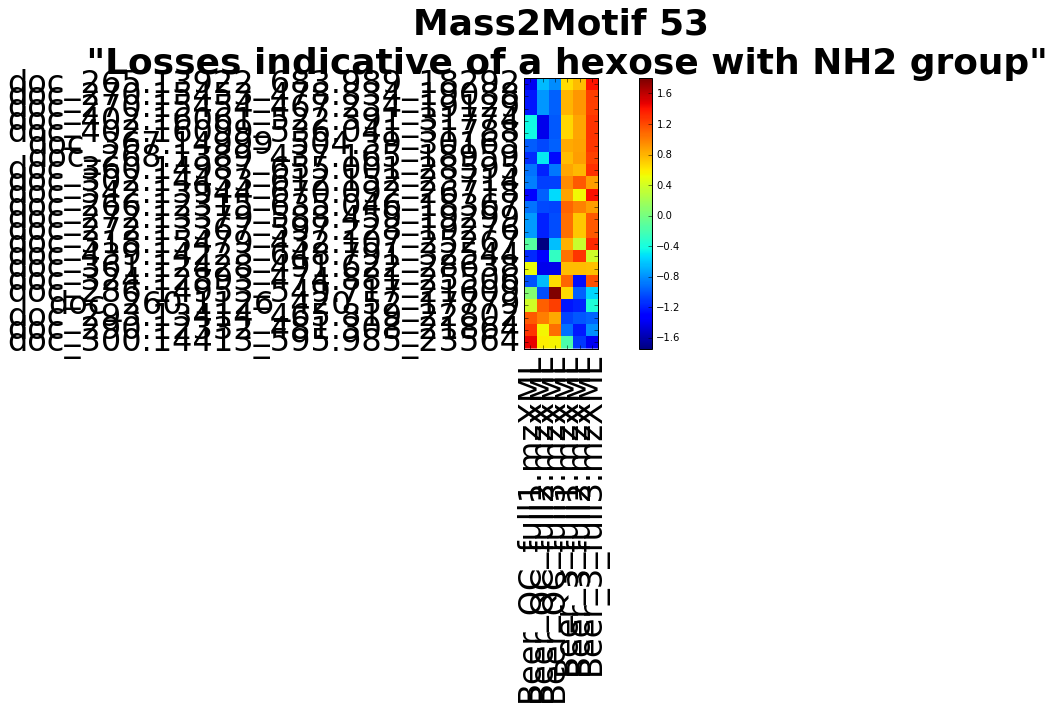

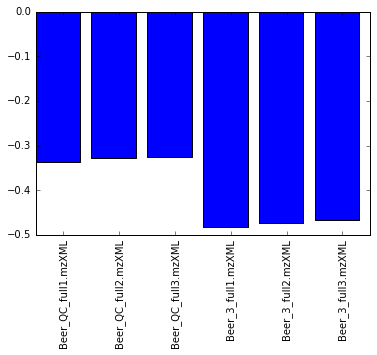

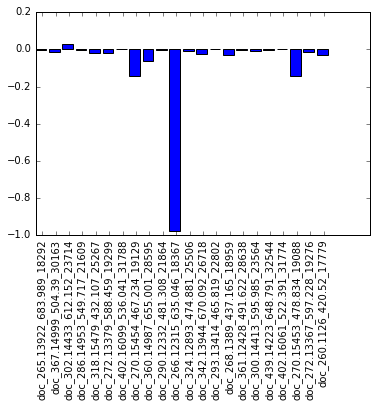

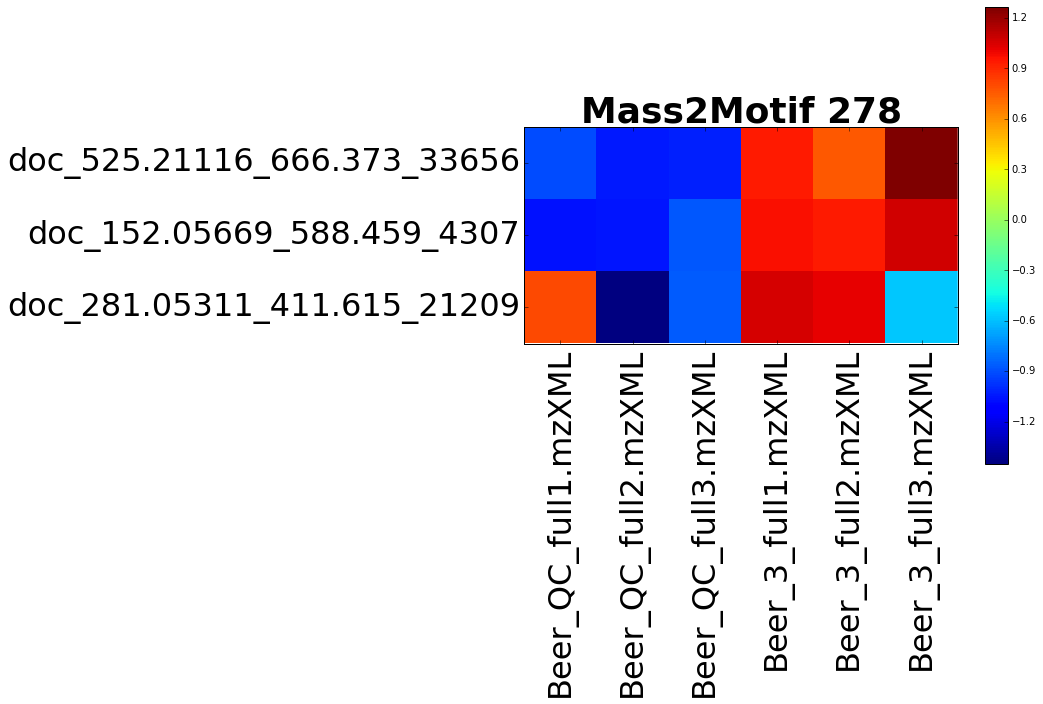

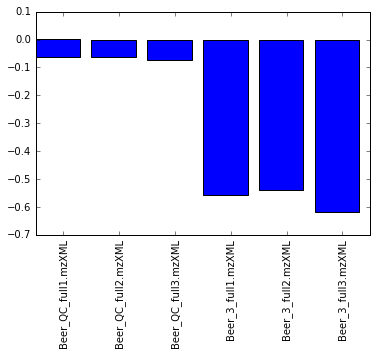

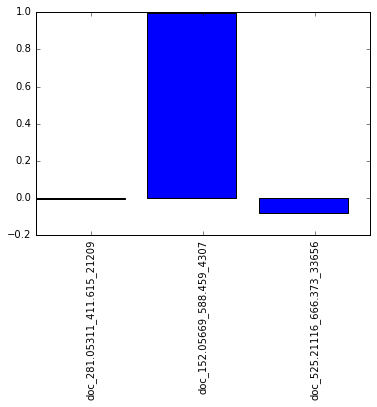

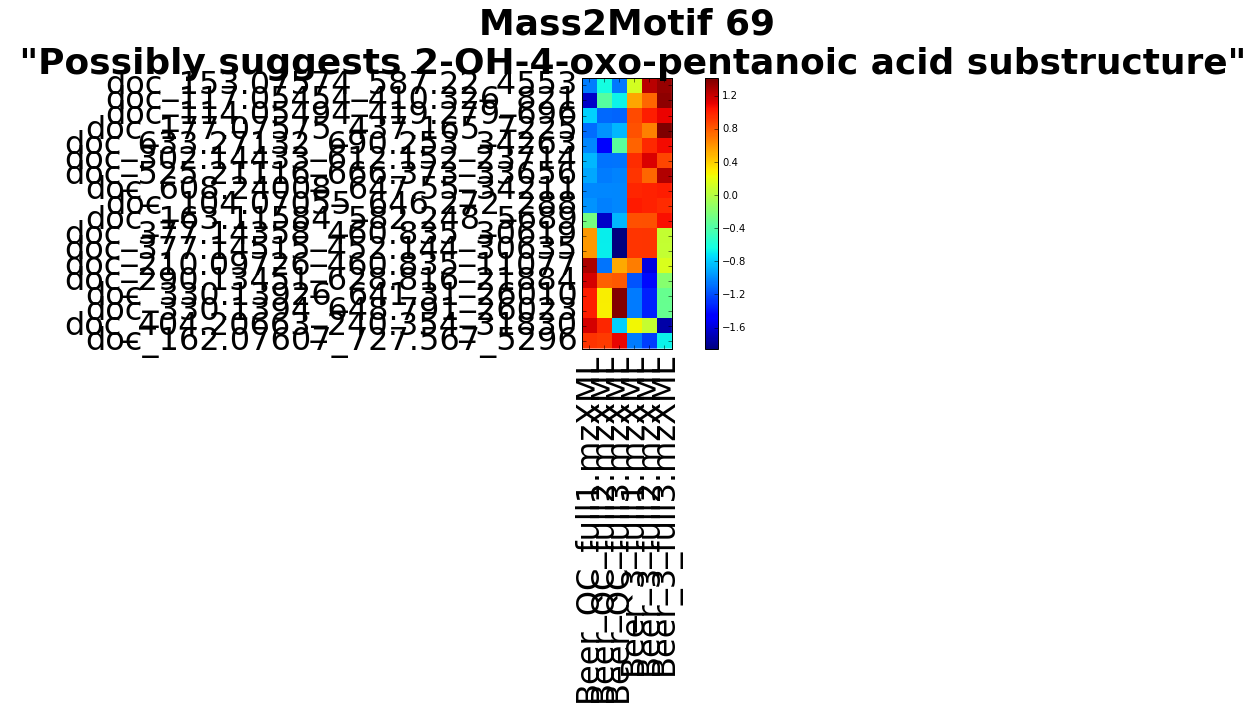

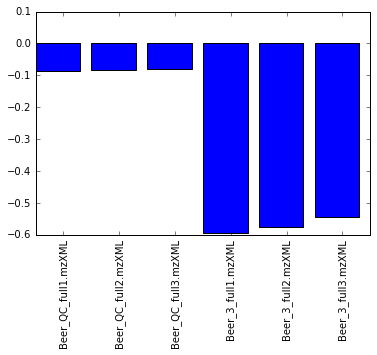

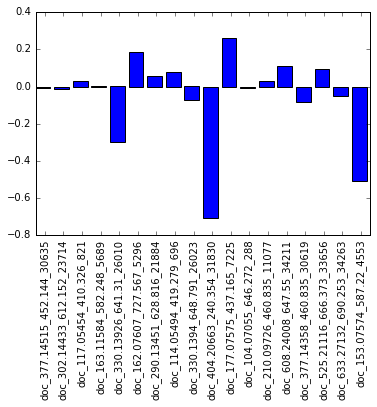

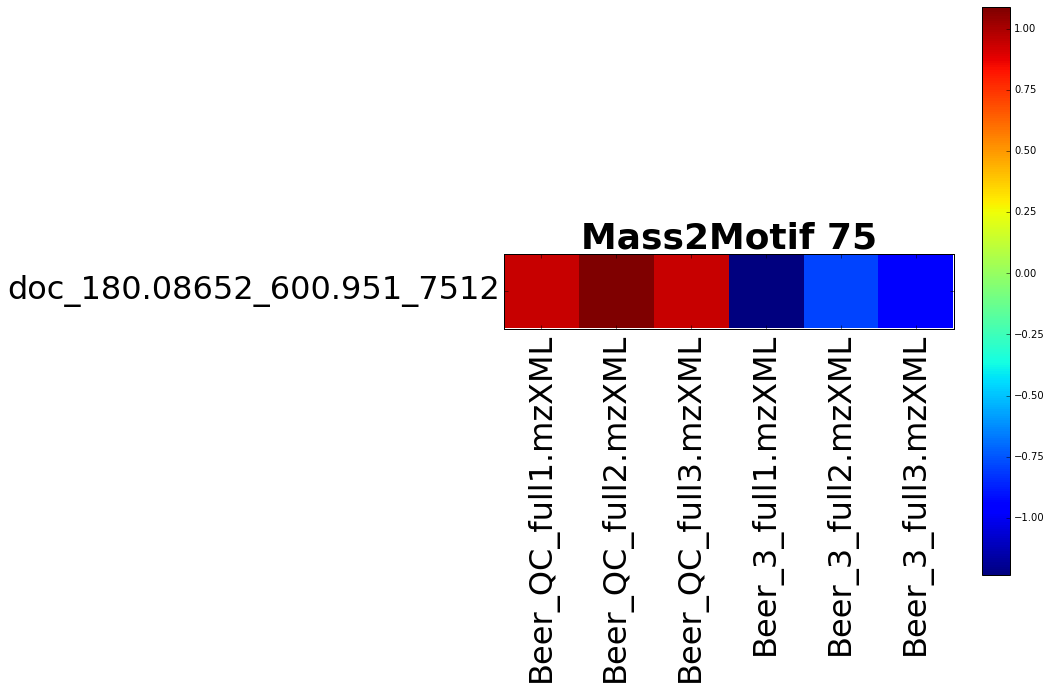

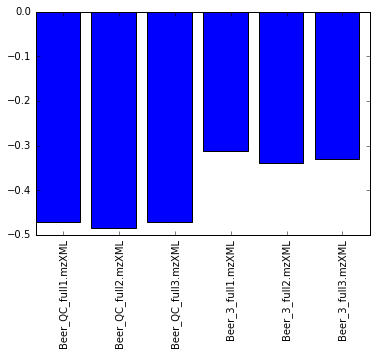

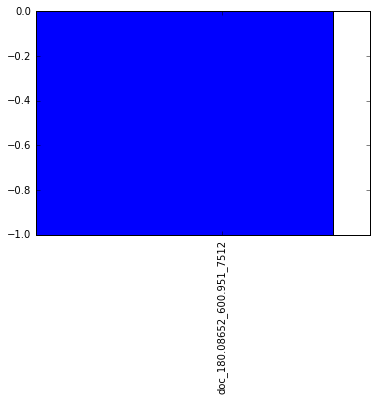

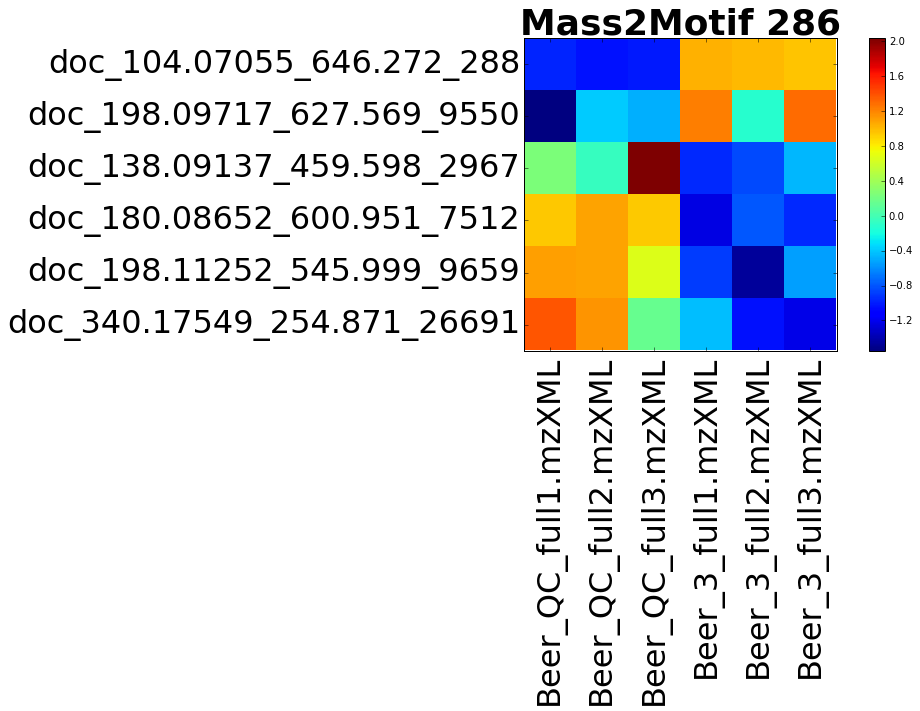

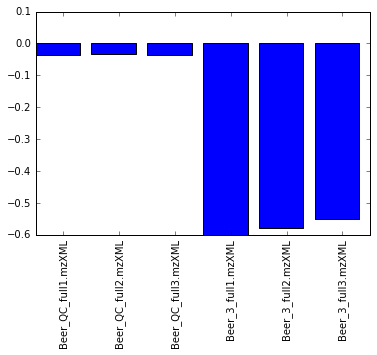

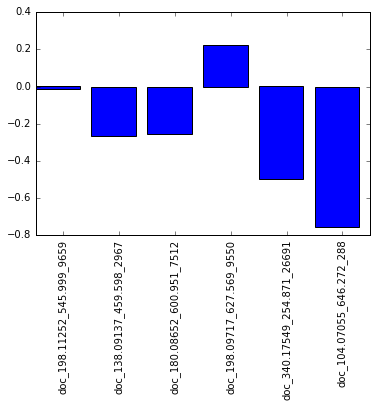

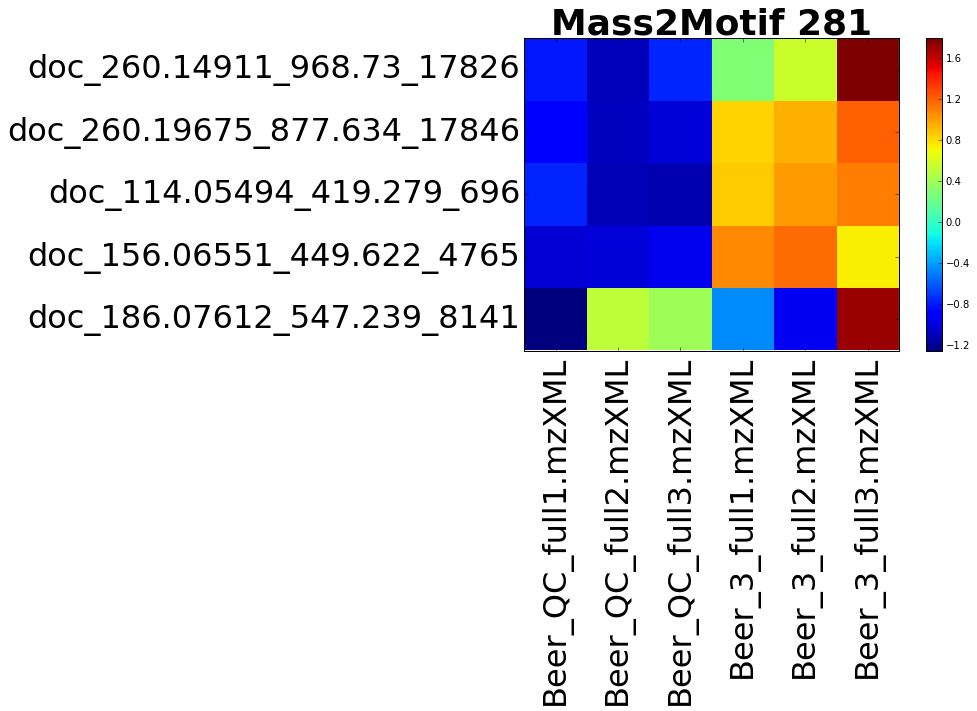

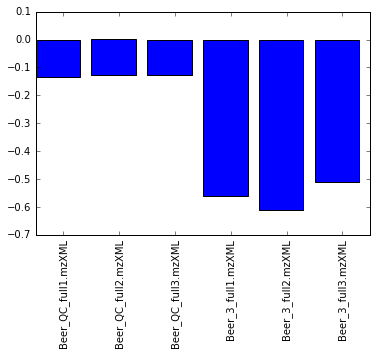

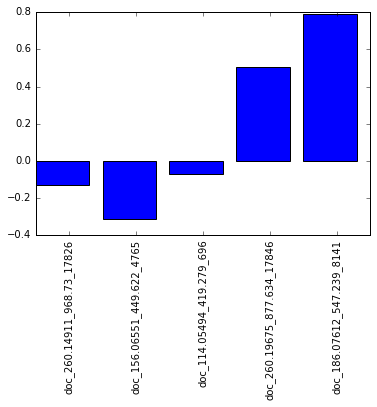

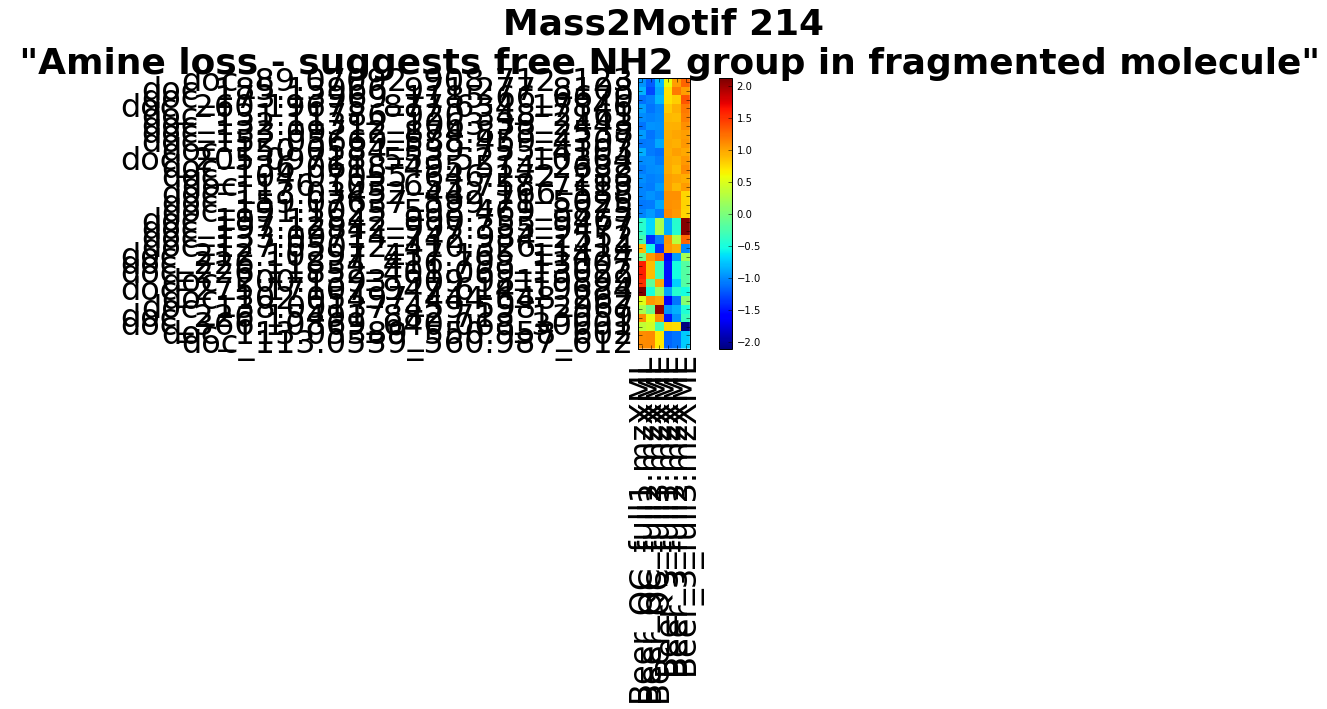

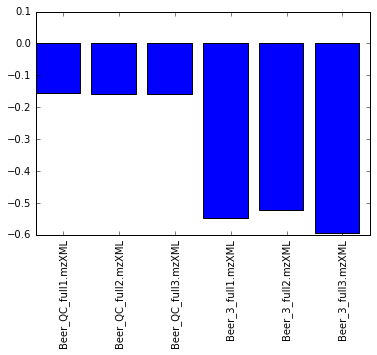

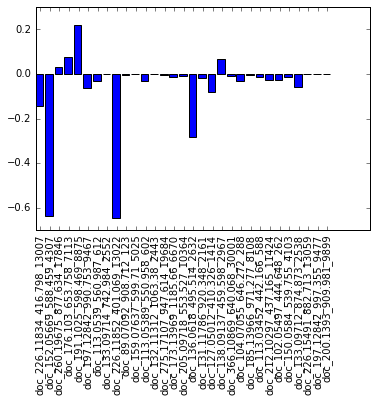

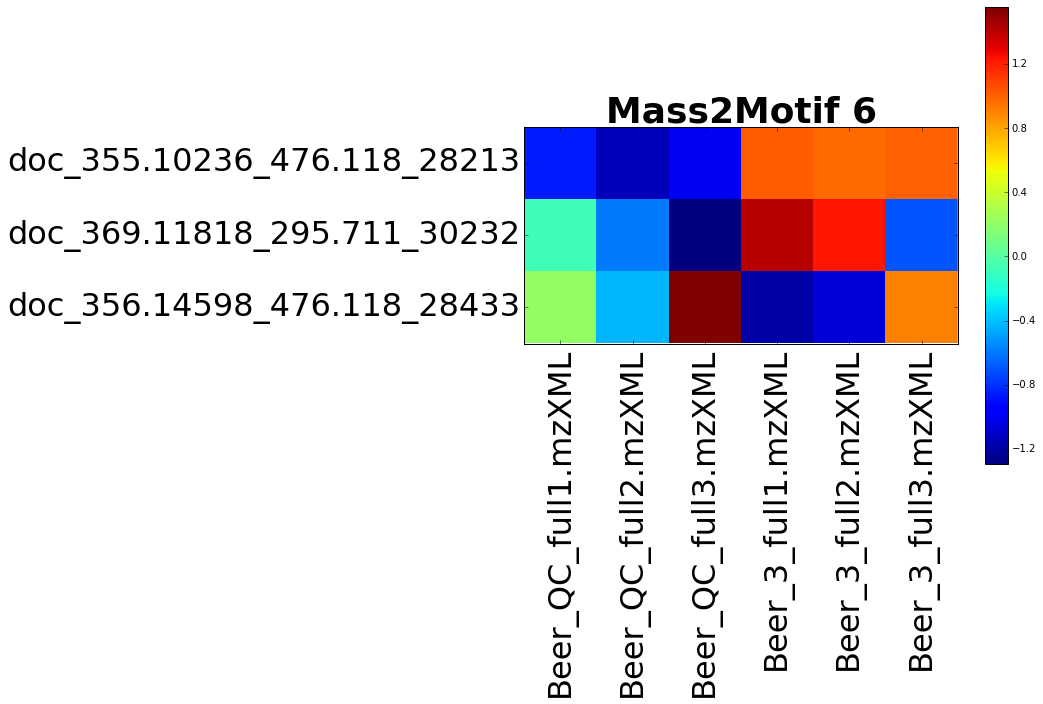

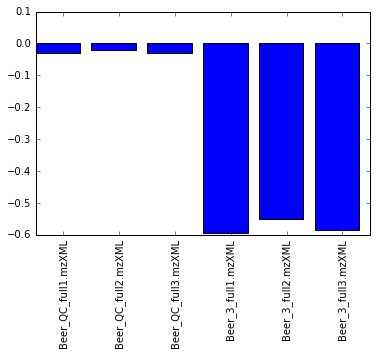

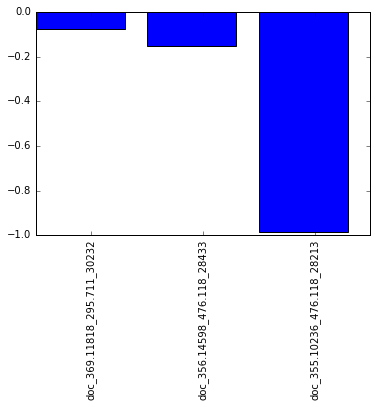

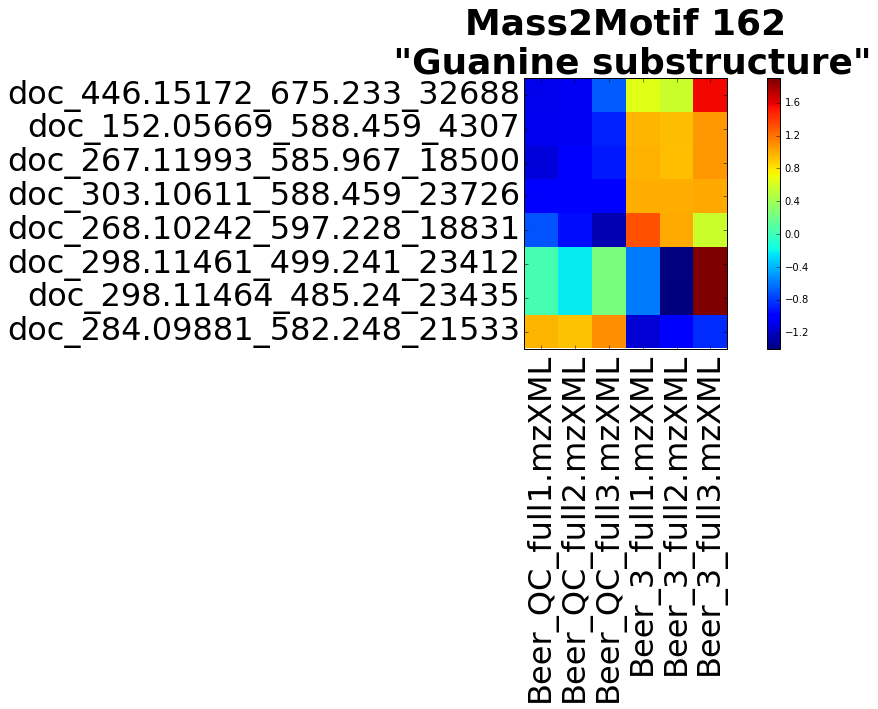

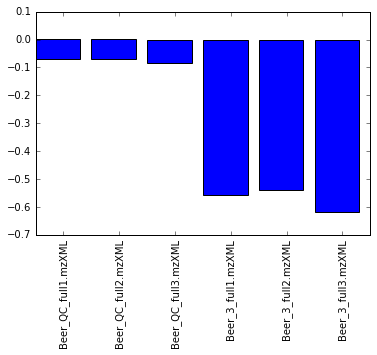

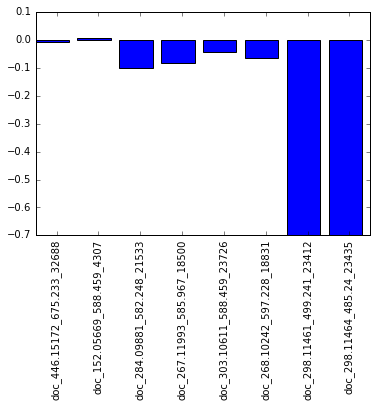

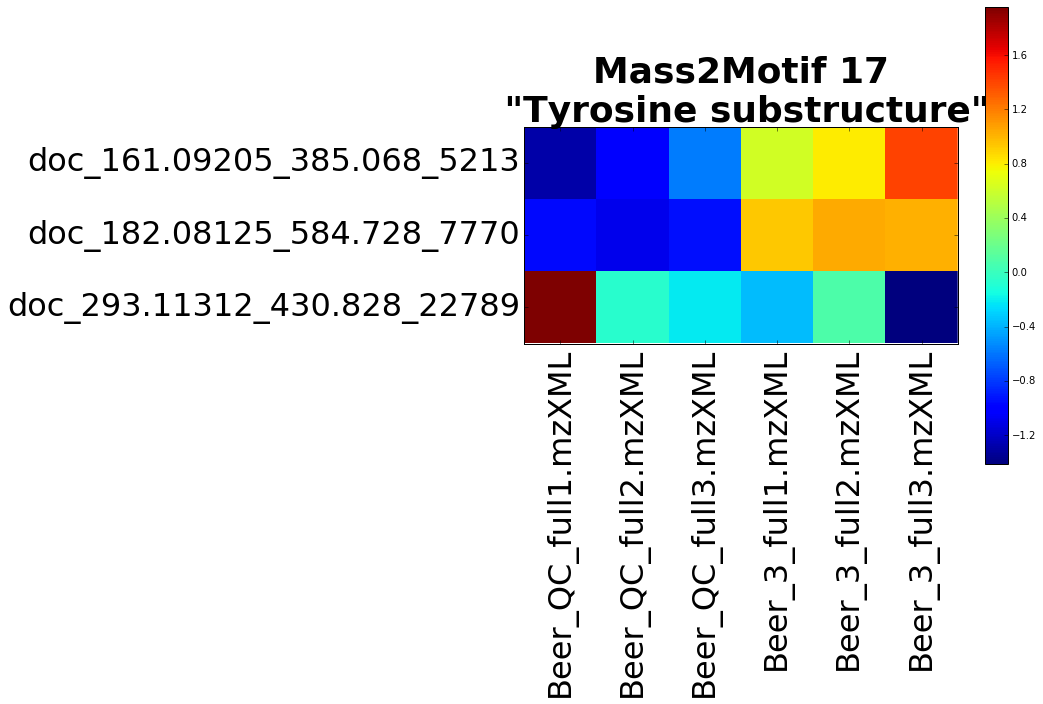

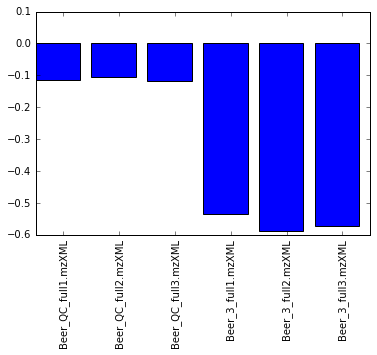

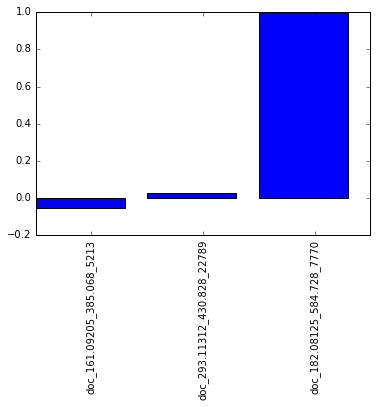

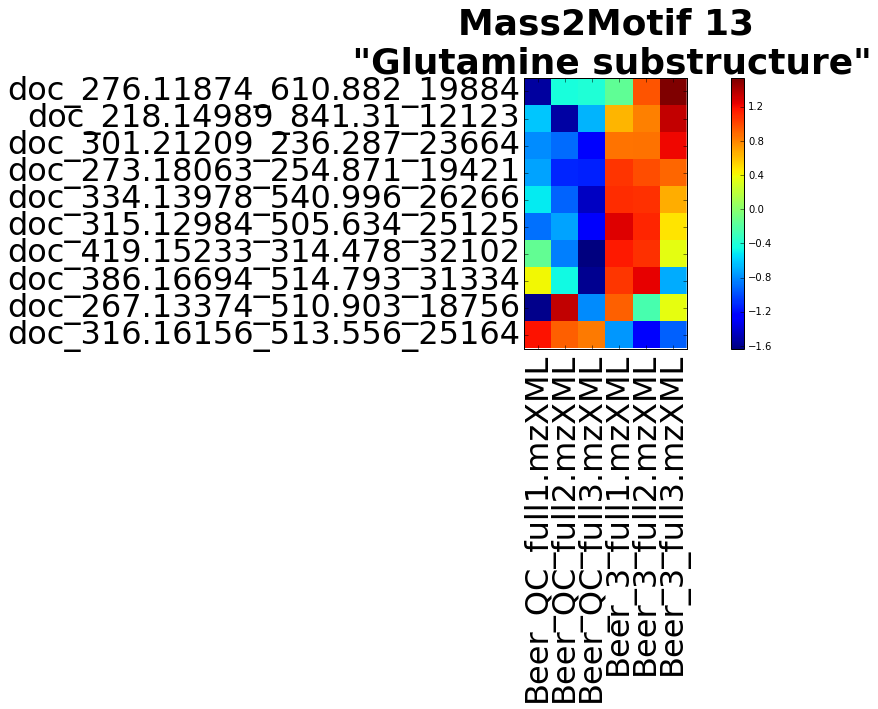

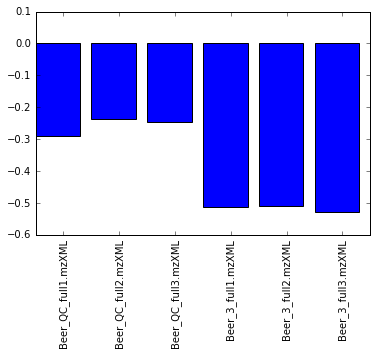

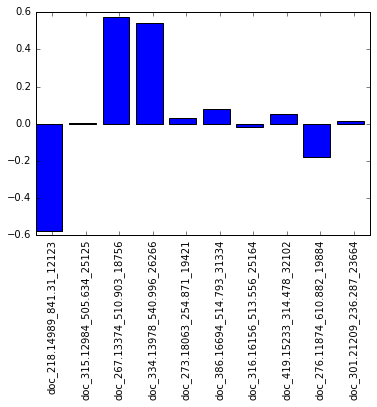

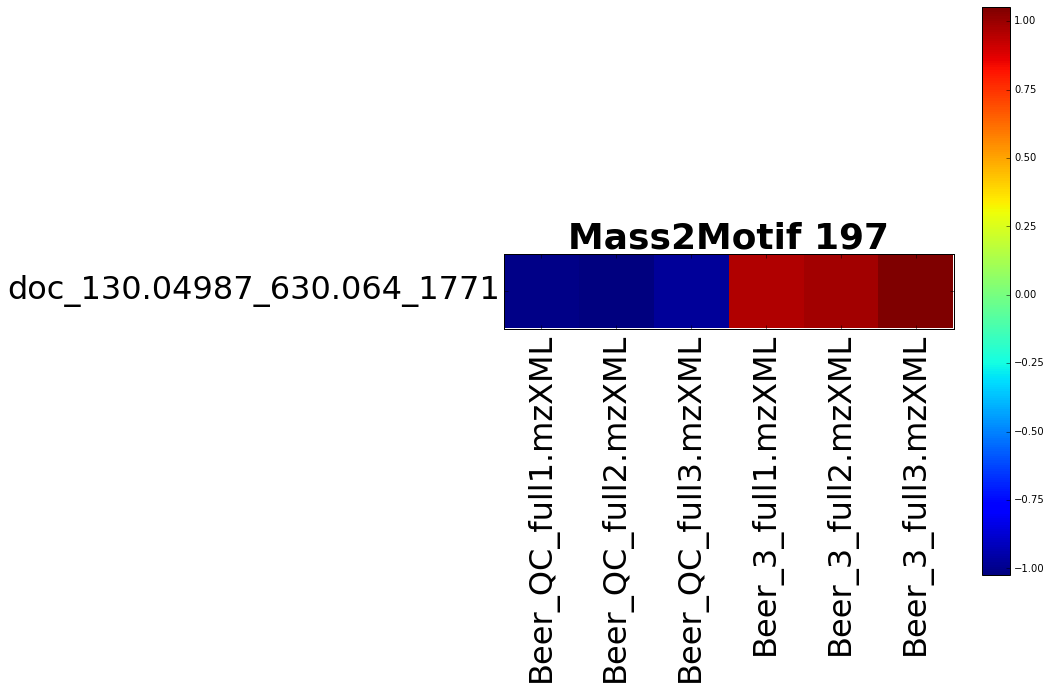

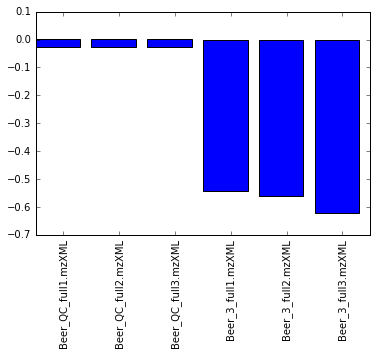

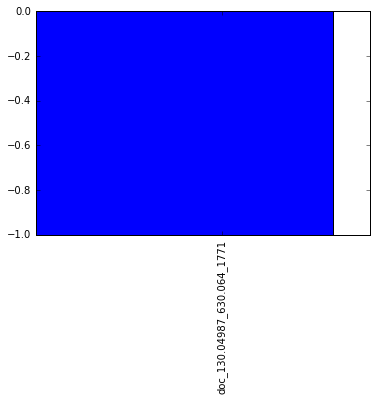

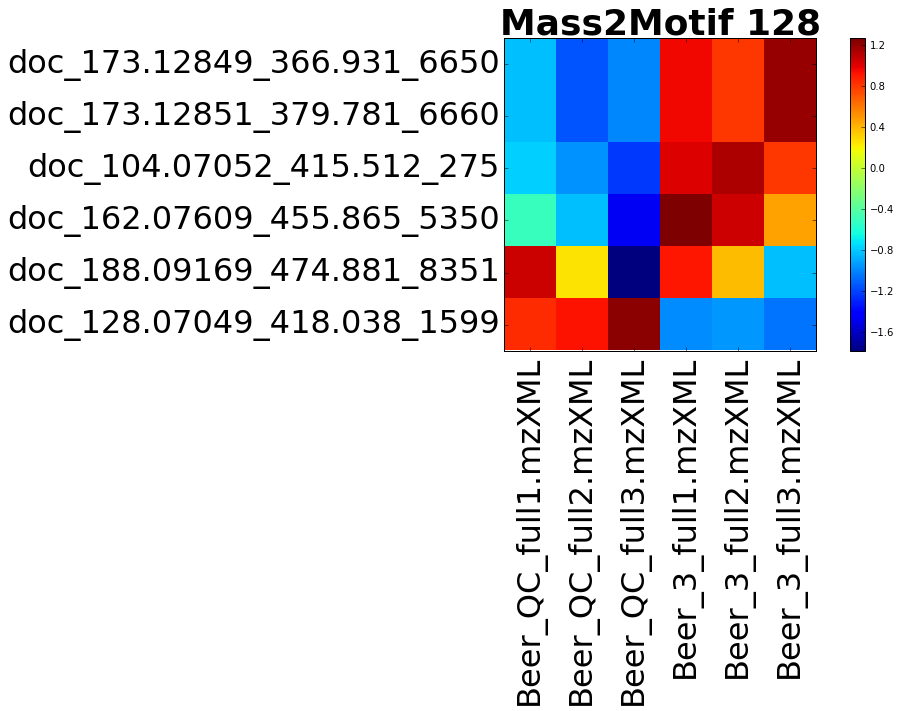

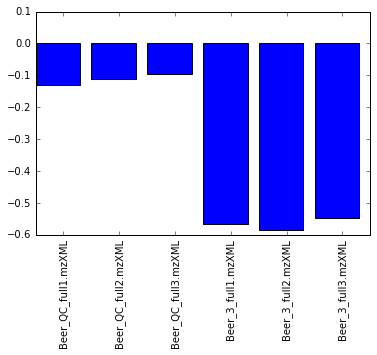

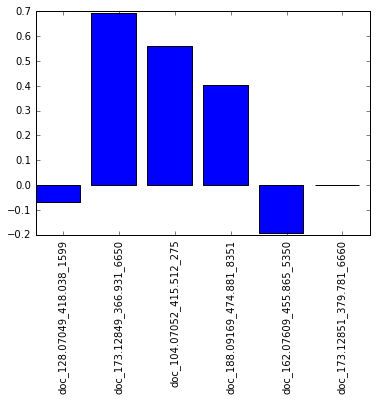

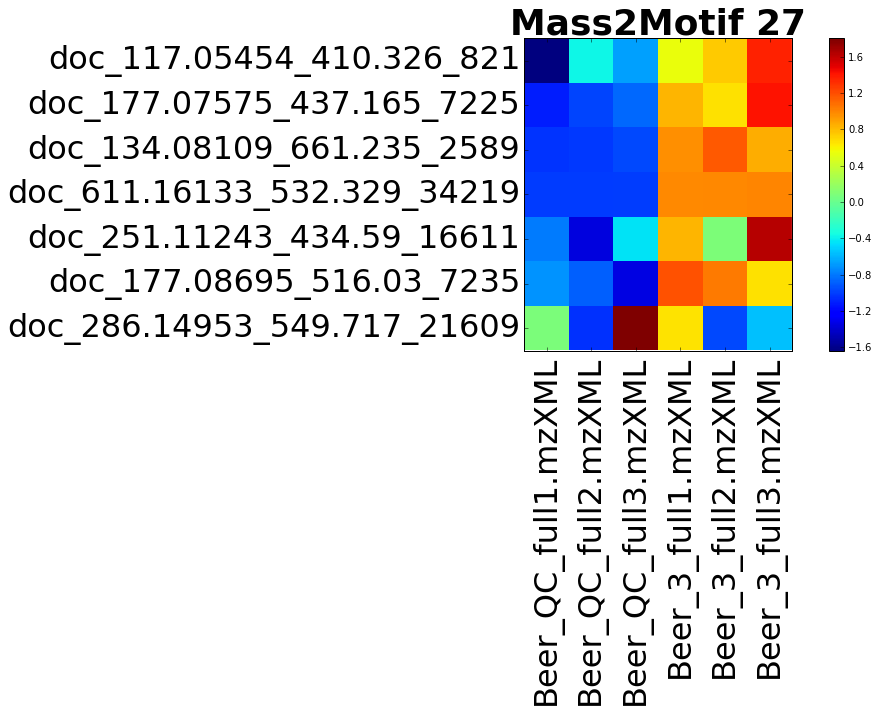

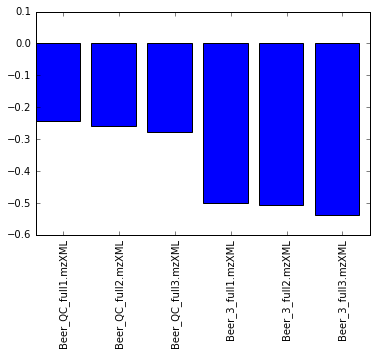

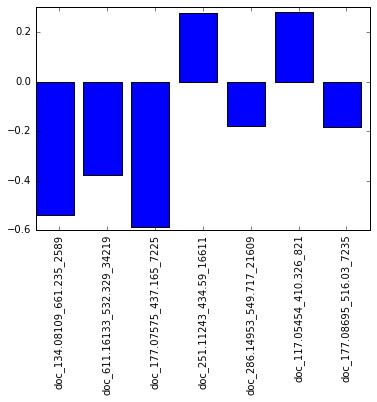

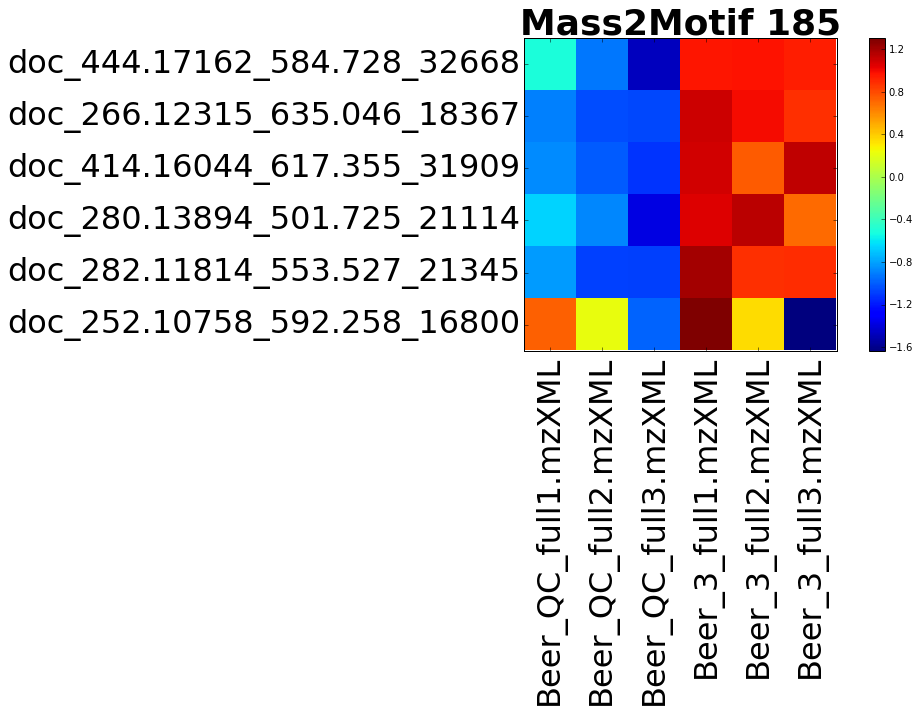

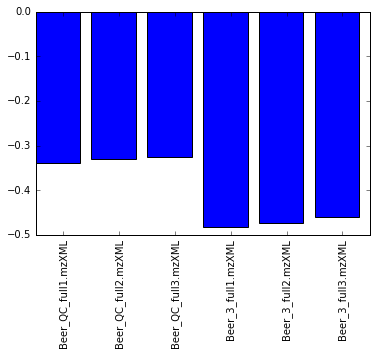

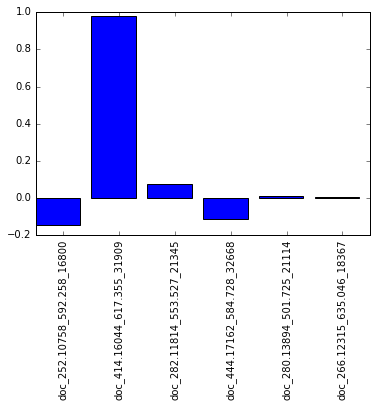

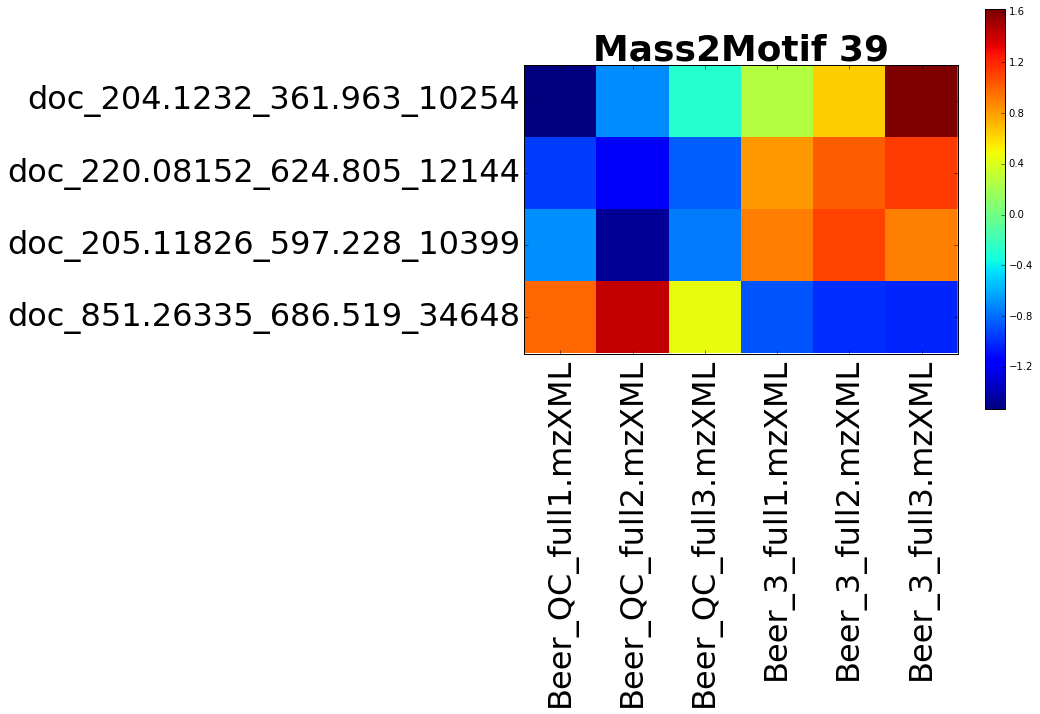

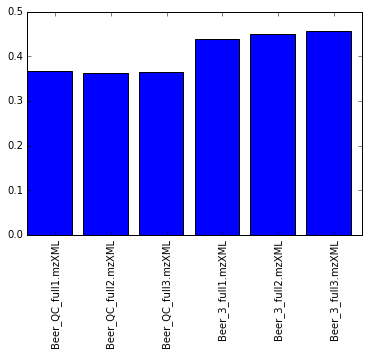

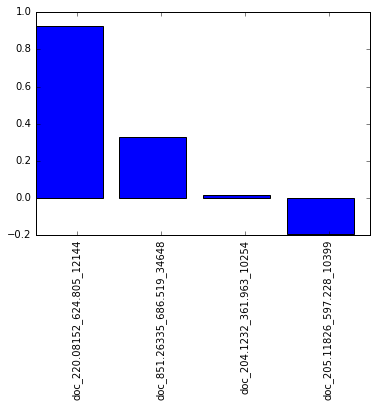

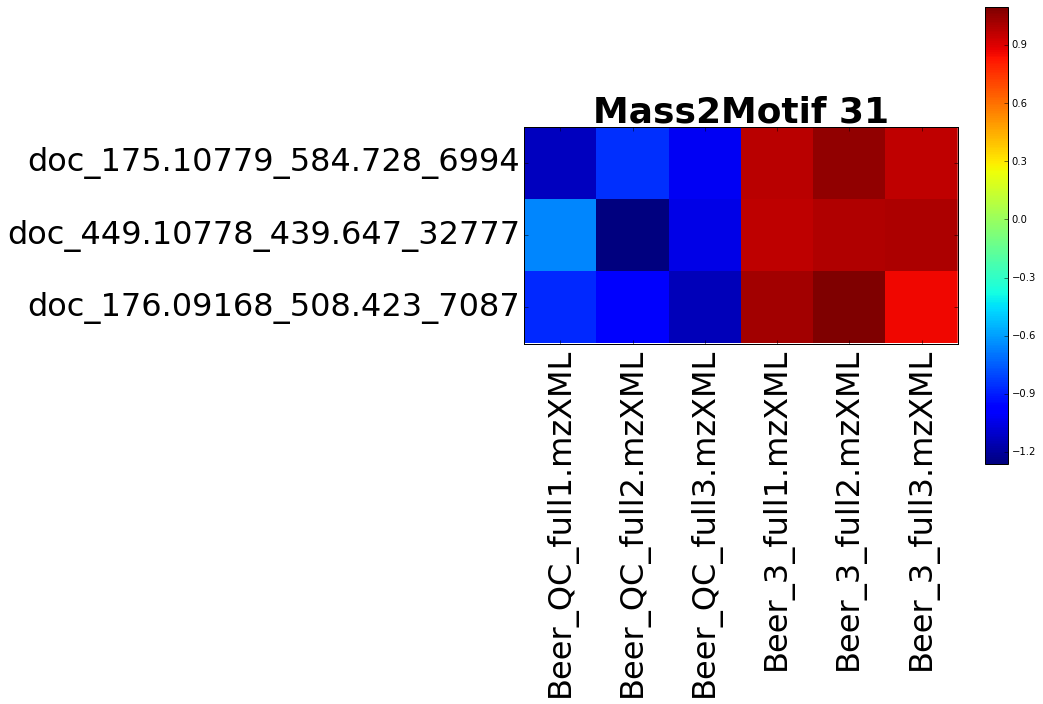

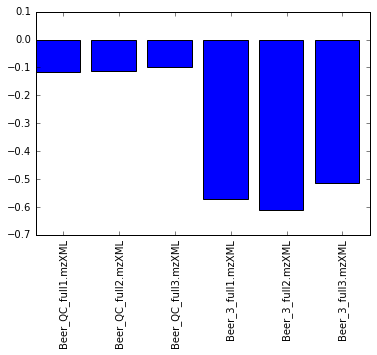

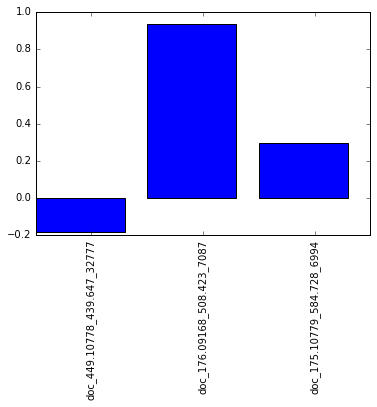

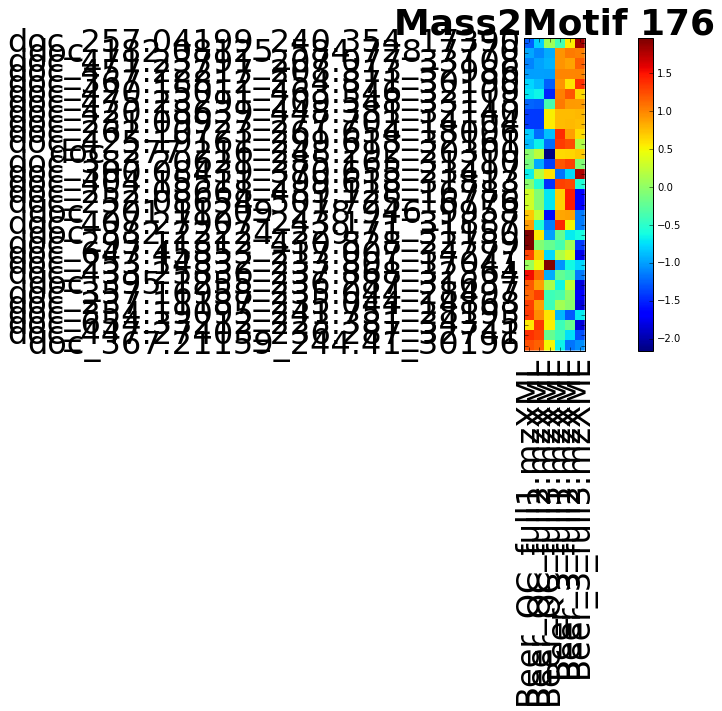

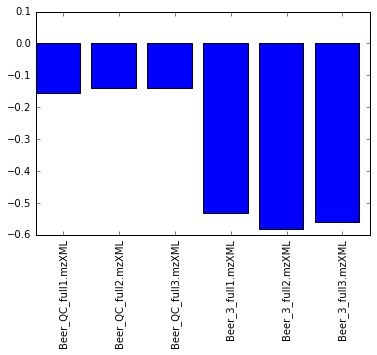

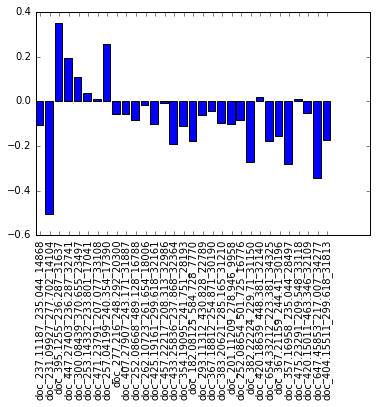

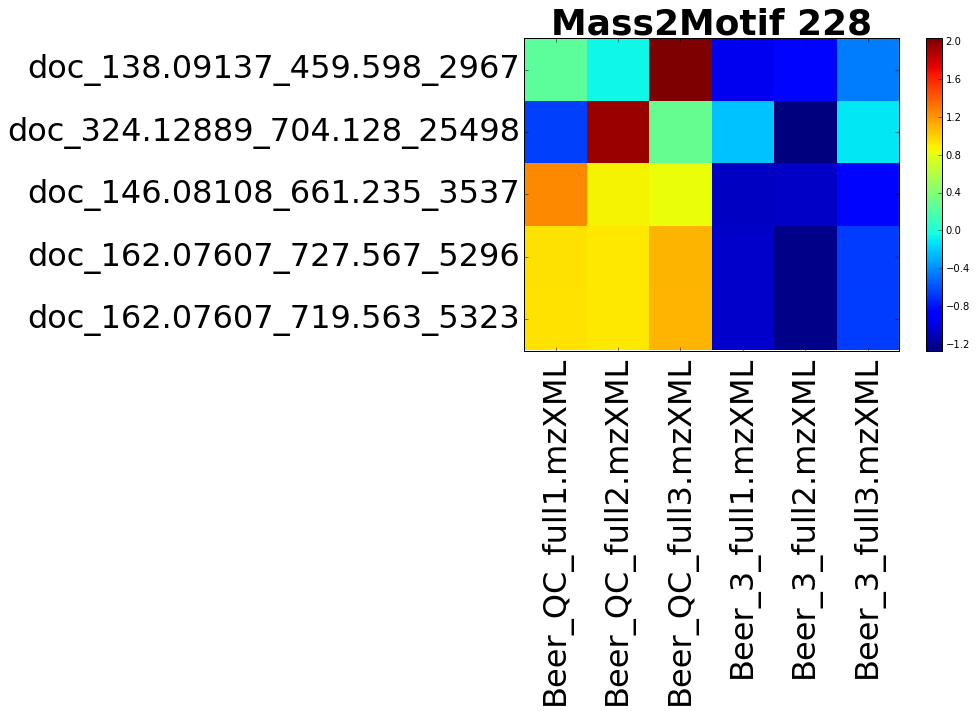

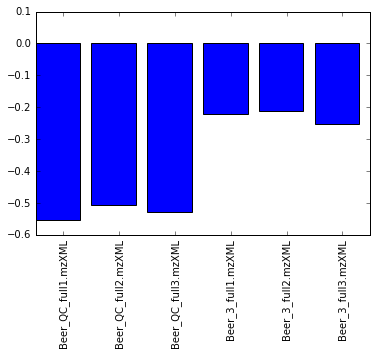

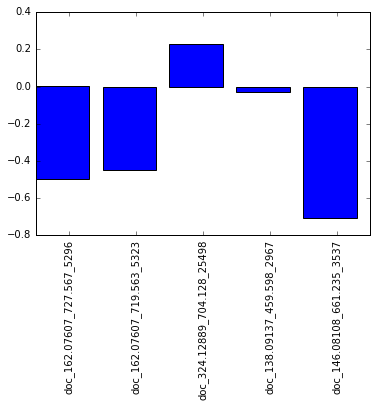

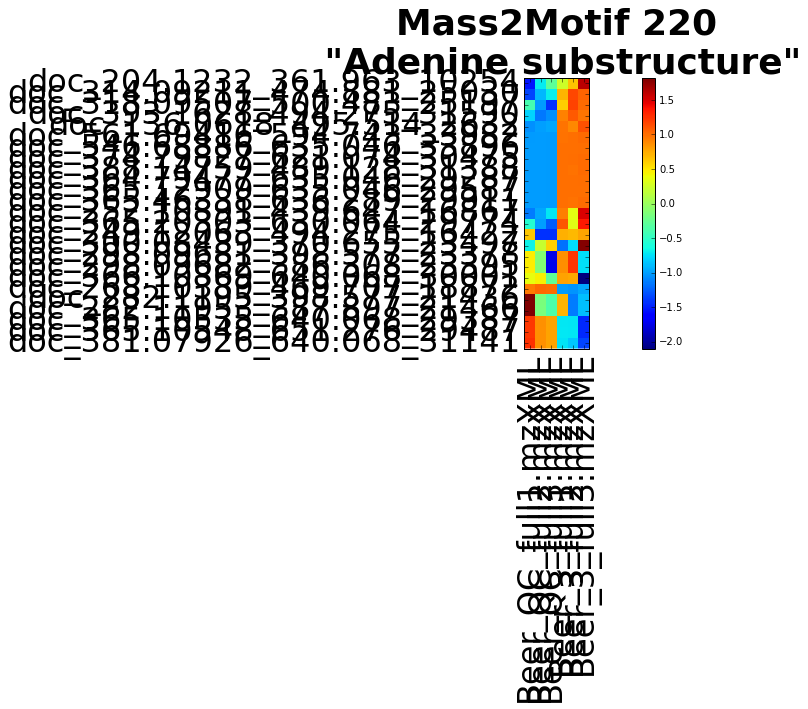

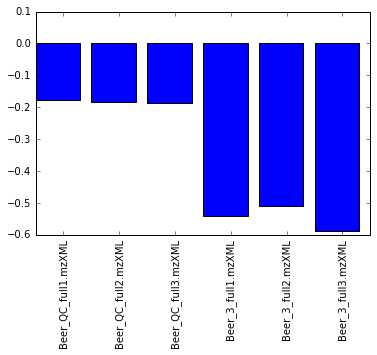

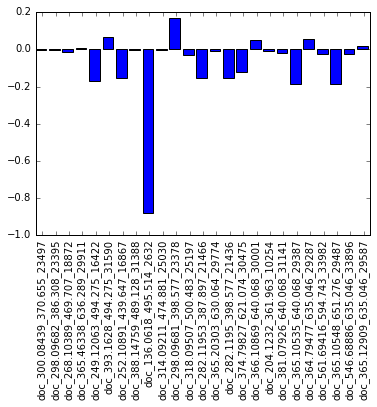

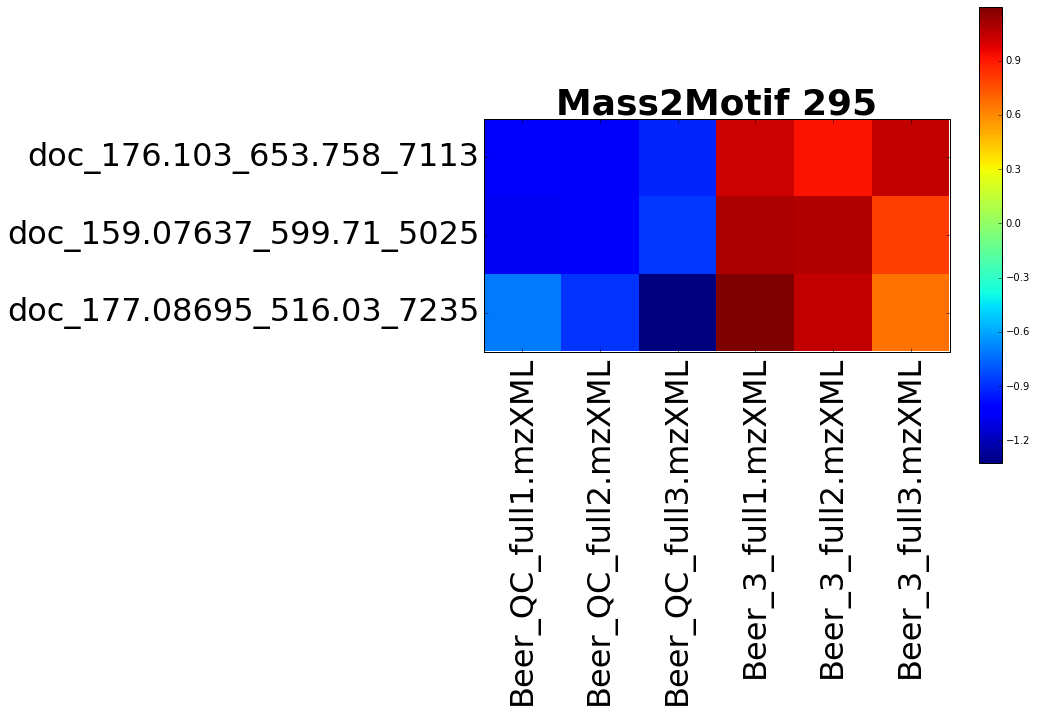

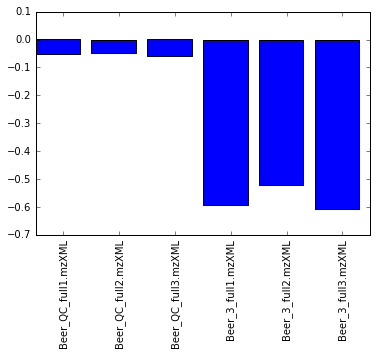

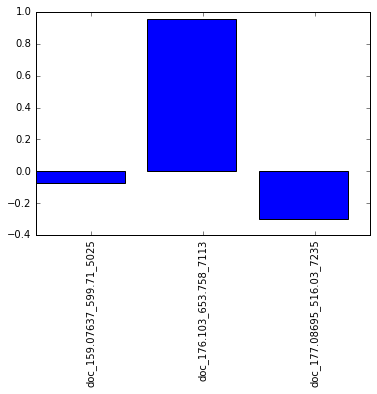

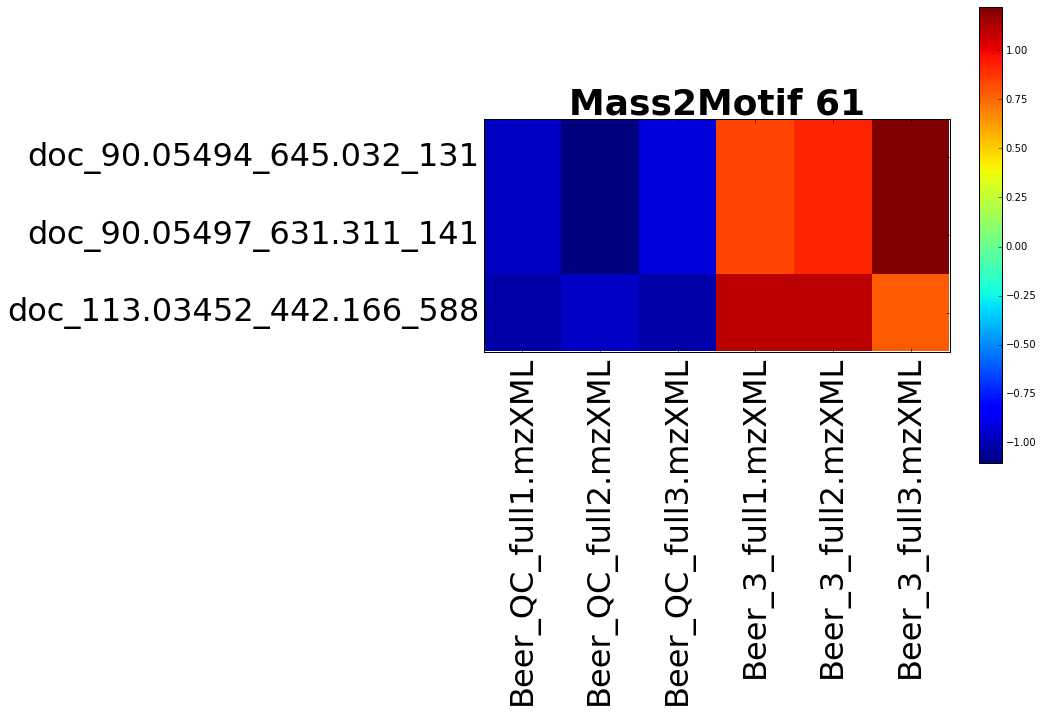

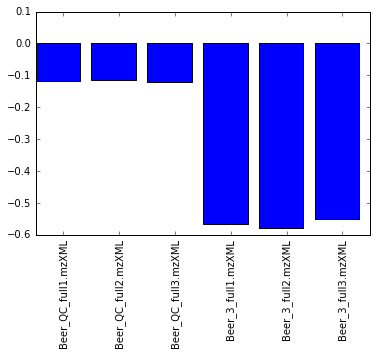

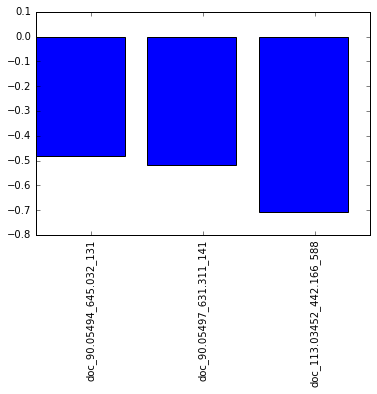

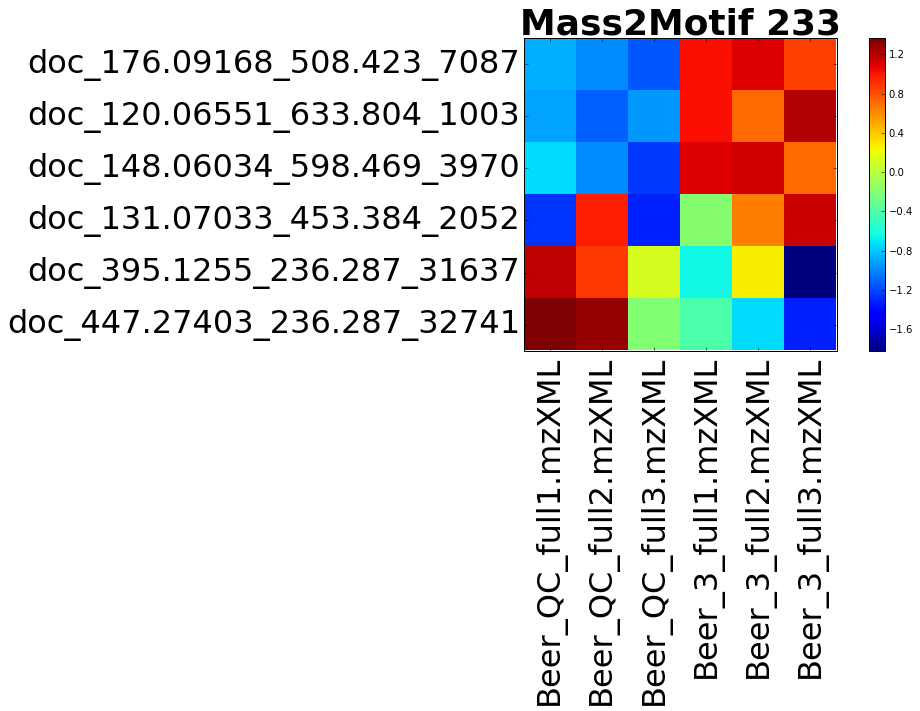

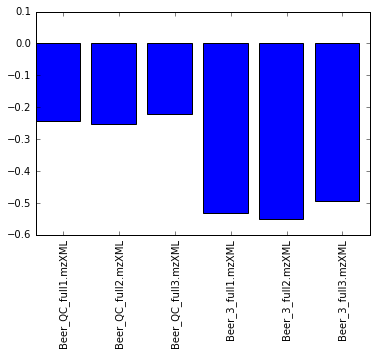

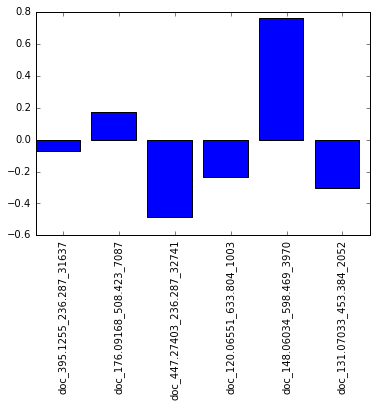

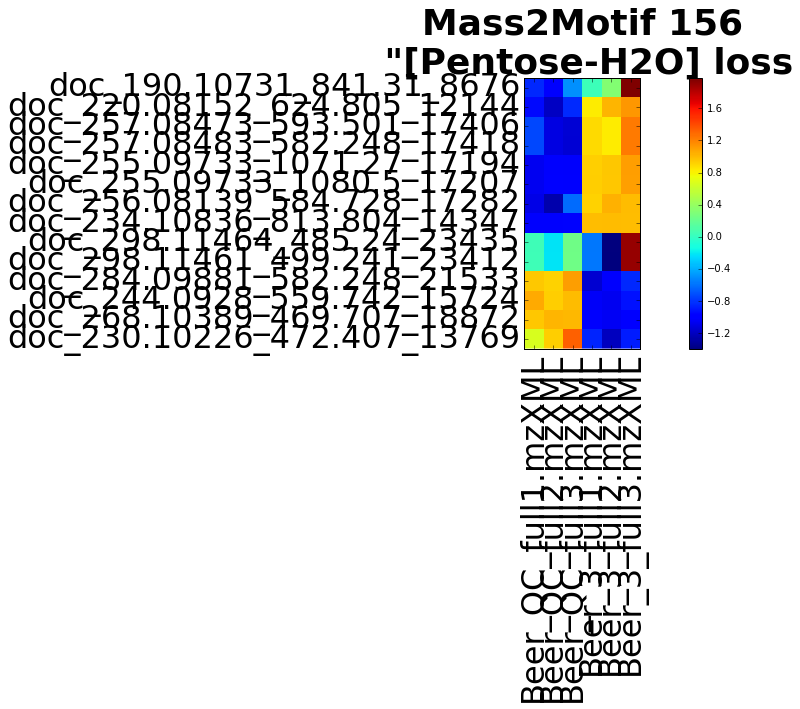

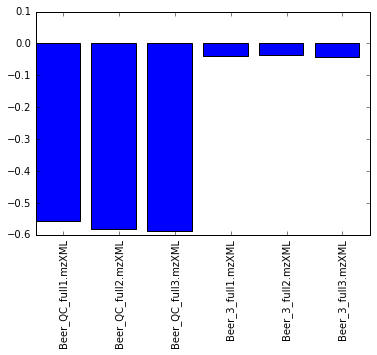

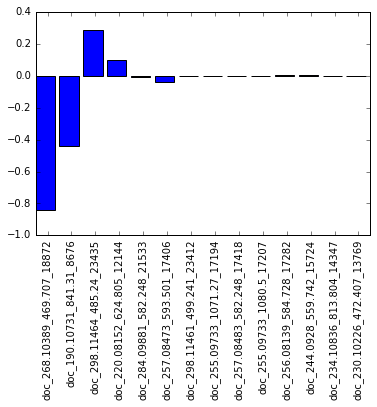

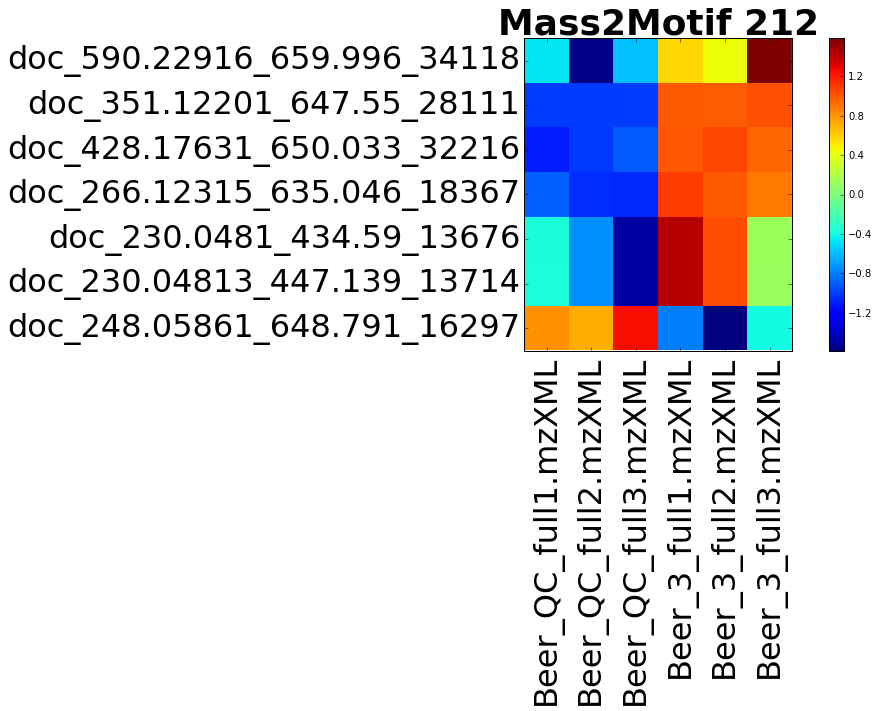

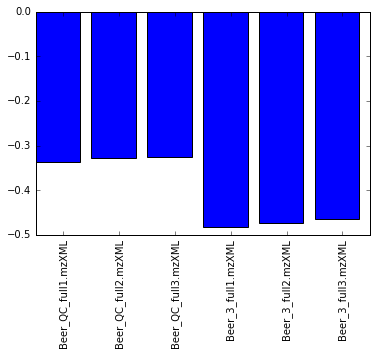

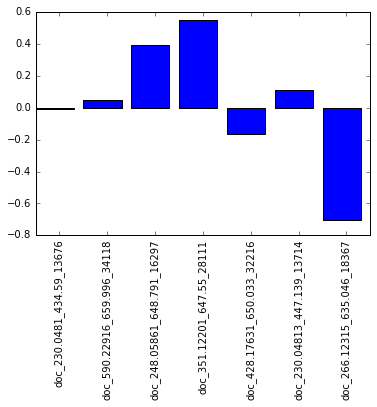

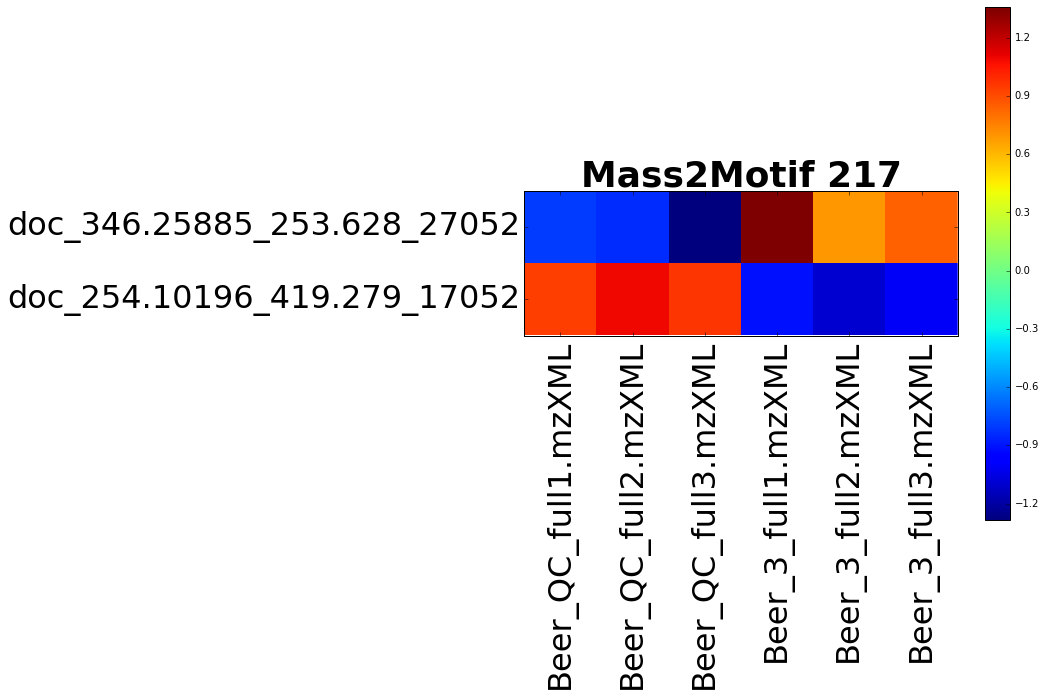

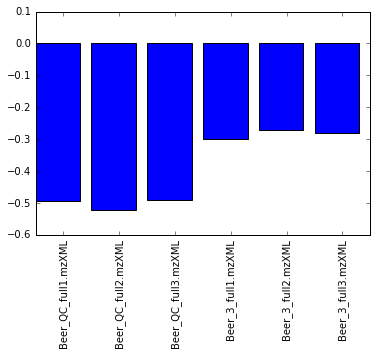

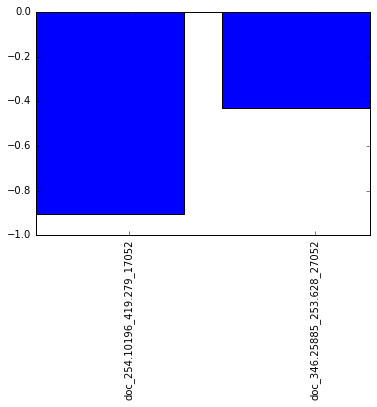

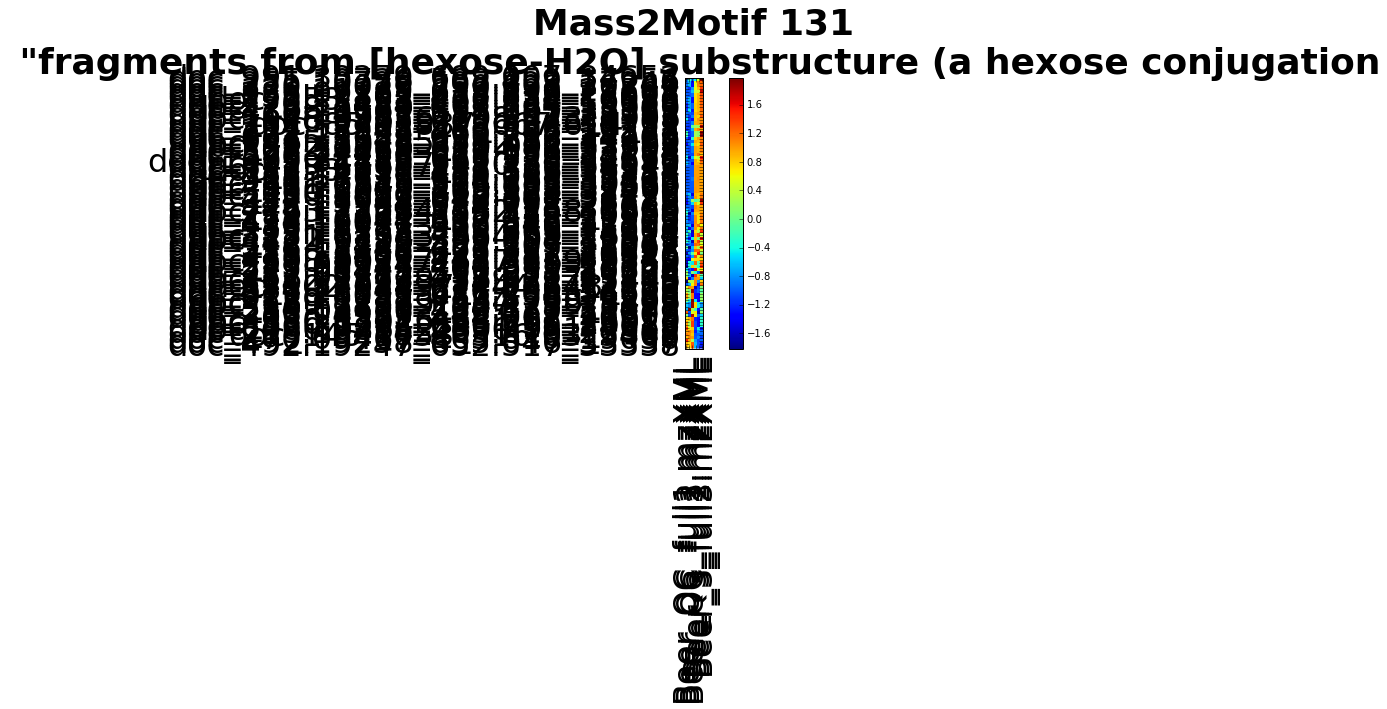

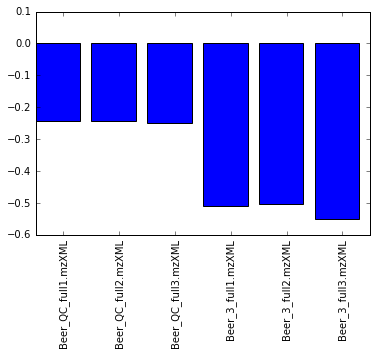

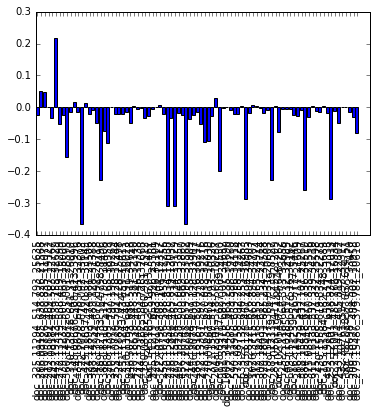

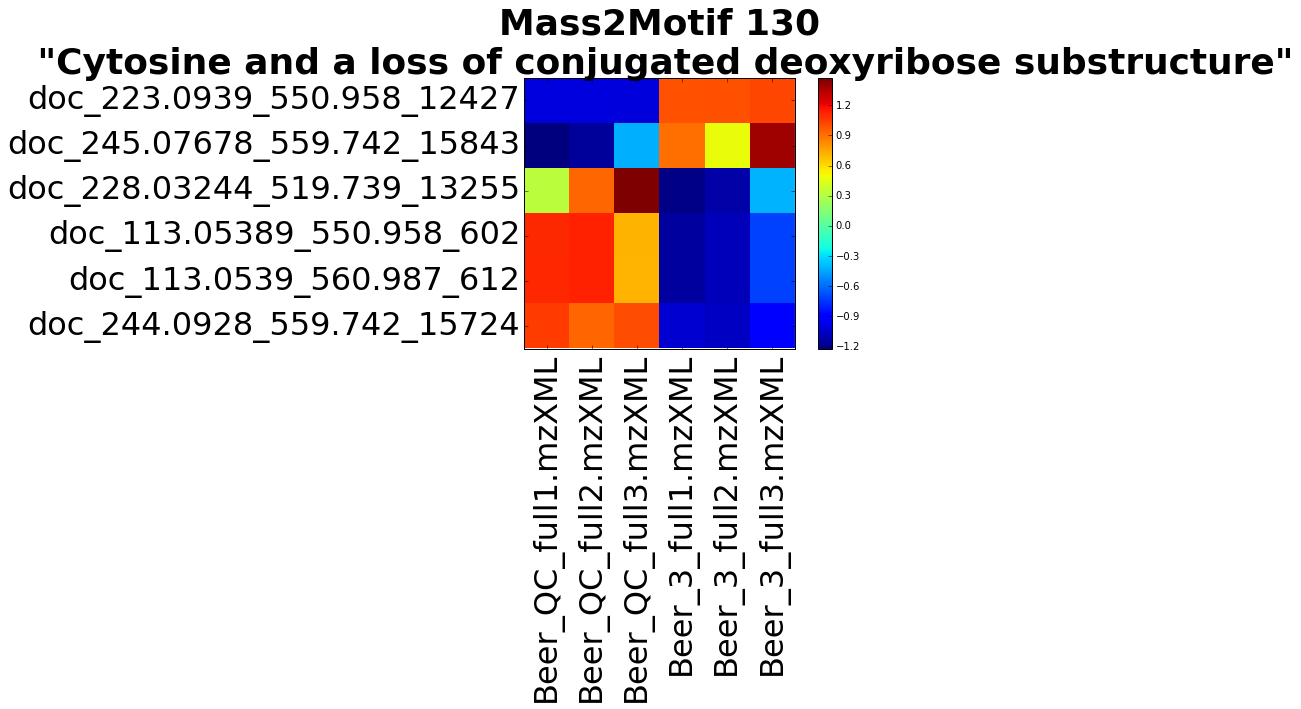

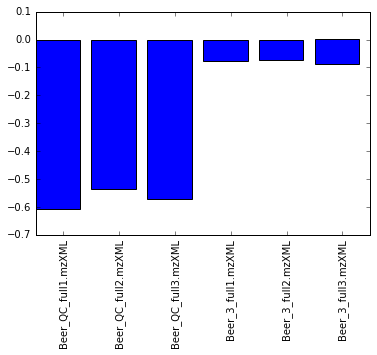

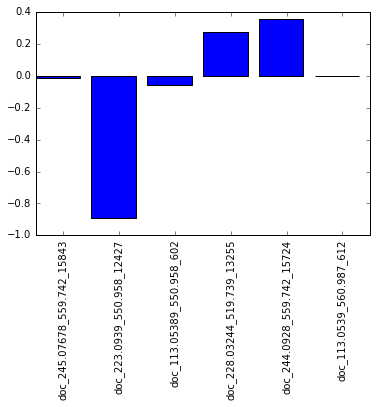

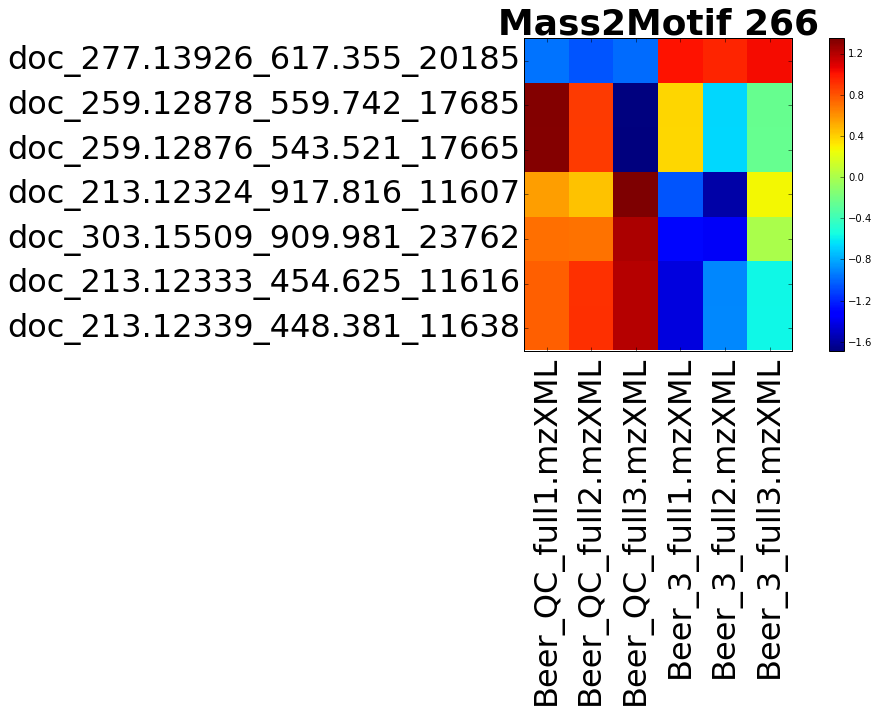

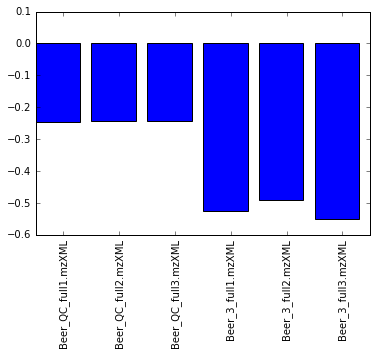

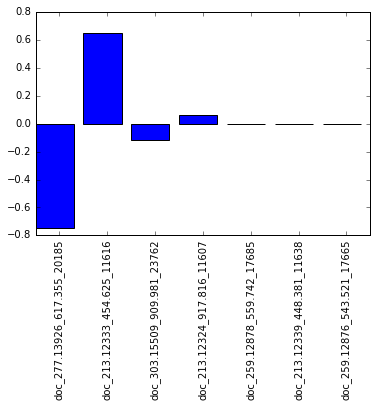

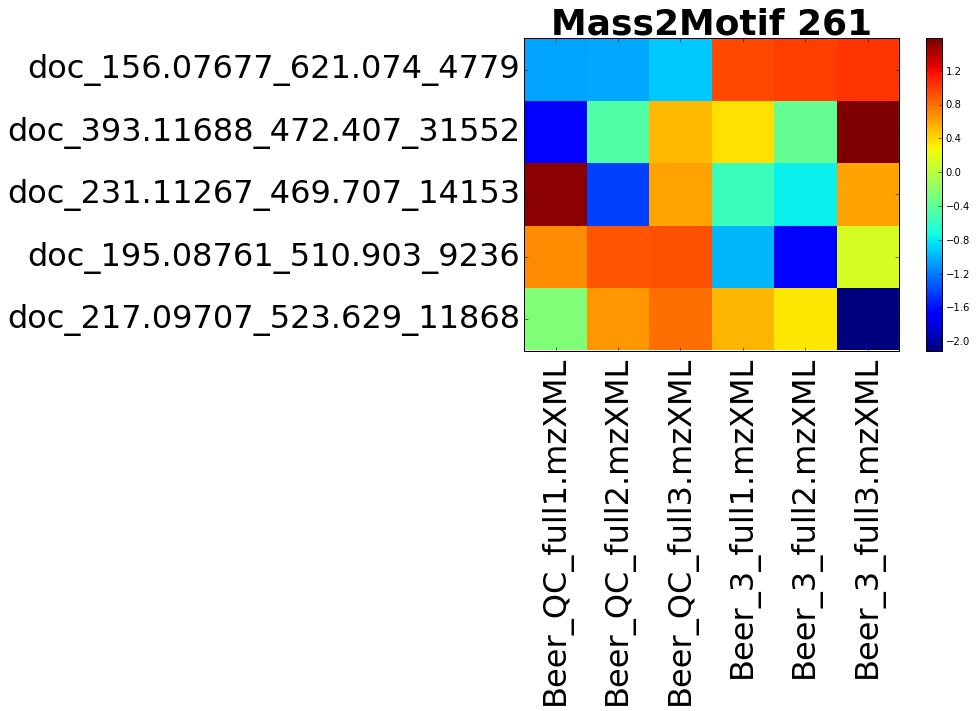

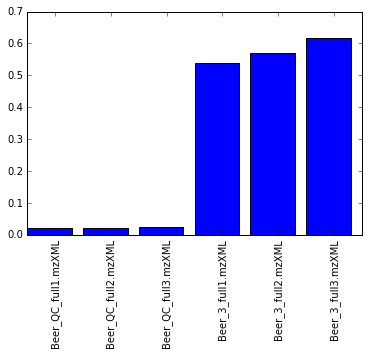

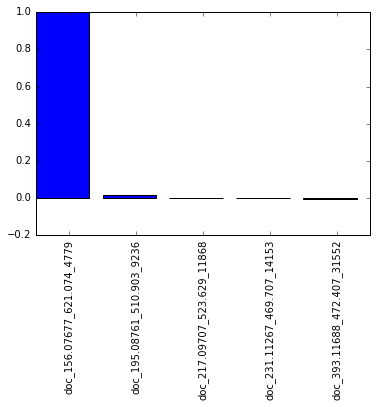

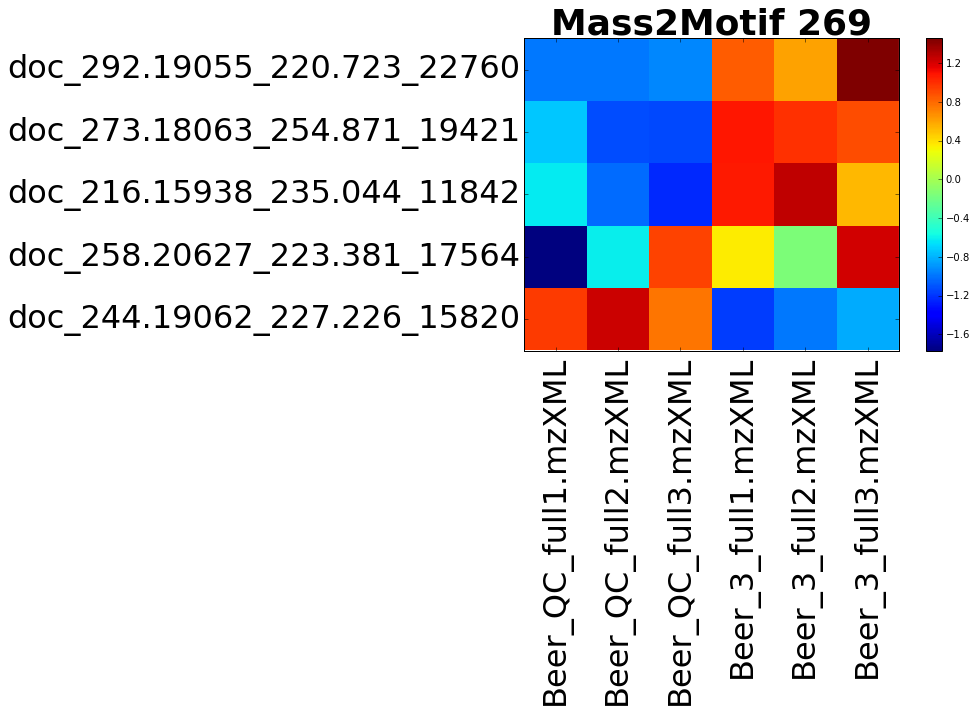

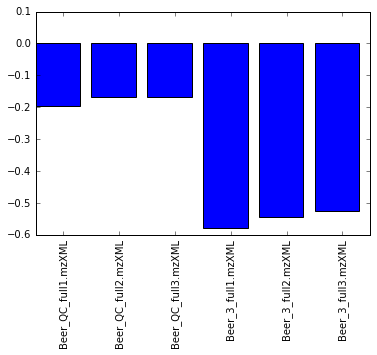

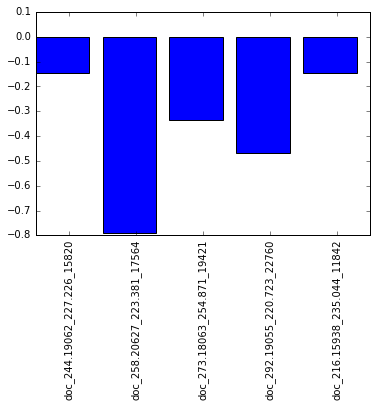

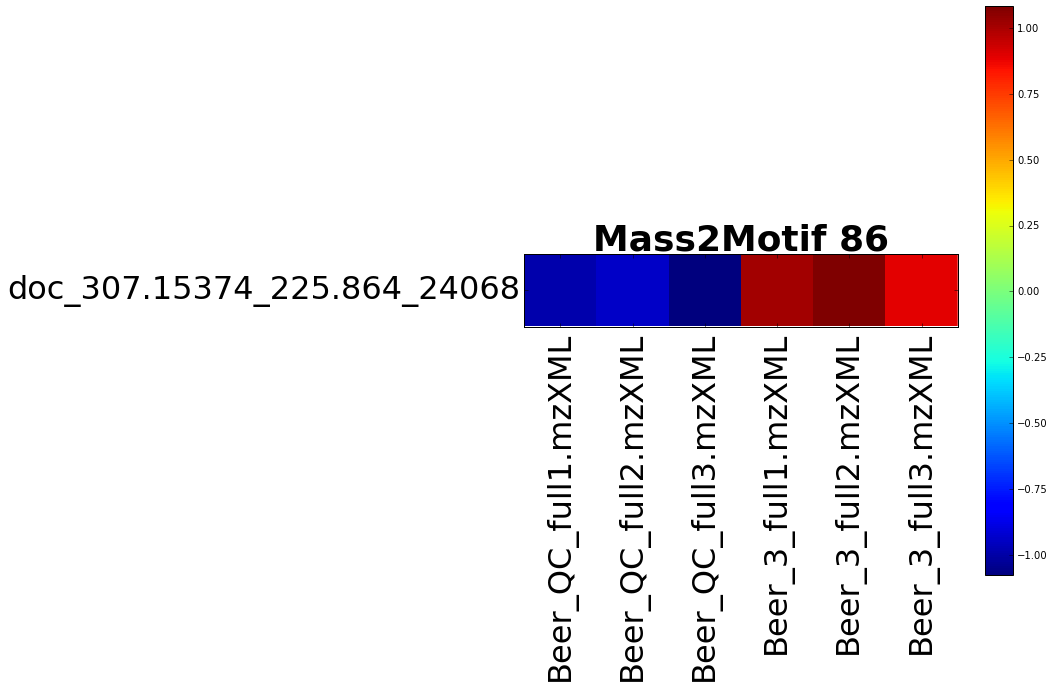

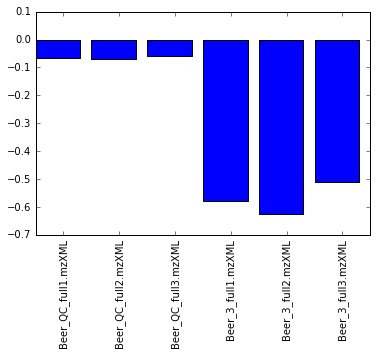

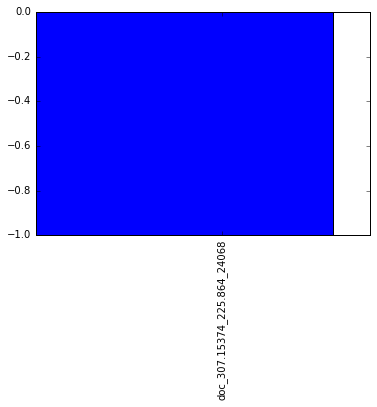

In [15]:
special_nodes = link.create_special_nodes_ms1(control=control, case=case)
special_nodes, lda_scores, peak_lda_scores, lda_G = link.compute_topic_t(special_nodes=special_nodes, control=control, case=case, 
                                                        t_thresh=t_thresh, t_annot=t_annot, 
                                                        peak_annot=peak_clustering_annot)

<h2>Run DE for Clustering</h2>

The following cell runs PLAGE on the clusters from cosine clustering and plots the expression heatmaps.

In [16]:
peak_lda_annot = {}
nodes = lda_G.nodes(data=True)
for node in nodes:
    node_id = node[0]
    node_data = node[1]
    if node_data['group'] == 1:
        node_name = node_data['name']
        neighbours = lda_G.neighbors(node_id)
        peak_lda_annot[node_name] = set()
        for nb in neighbours:
            nb_name = lda_G.node[nb]['name']
            peak_lda_annot[node_name].add(nb_name)

292 topic/cluster nodes loaded

1. Mass2Motif 255 PLAGE score=2.473
 - doc_158.08121_336.679_4921
 - doc_316.16156_513.556_25164

2. Mass2Motif 257 PLAGE score=25.507
 - doc_275.07494_482.766_19639
 - doc_527.16183_482.766_33700
 - doc_527.19658_480.07_33705
 - doc_527.23103_478.834_33710
 - doc_527.23127_467.234_33713

Heatmap saved to heatmap_2.png

3. Mass2Motif 256 PLAGE score=0.441
 - doc_252.10758_592.258_16800
 - doc_282.11814_553.527_21345
 - doc_414.16044_617.355_31909
 - doc_444.17162_584.728_32668

4. Mass2Motif 251 PLAGE score=3.941
 - doc_220.10851_427.098_12163
 - doc_220.11794_433.349_12206

5. Mass2Motif 253 PLAGE score=3.063
 - doc_228.12298_264.331_13390

6. Mass2Motif 252 PLAGE score=3.205
 - doc_1031.32647_670.092_34726
 - doc_1031.32661_661.235_34730
 - doc_275.17107_947.614_19684
 - doc_347.09473_568.532_27066
 - doc_347.09498_553.527_27080

7. Mass2Motif 259 PLAGE score=5.835
 - doc_161.12843_906.122_5238
 - doc_225.12326_618.594_12911

8. Mass2Motif 258 PLAGE sc

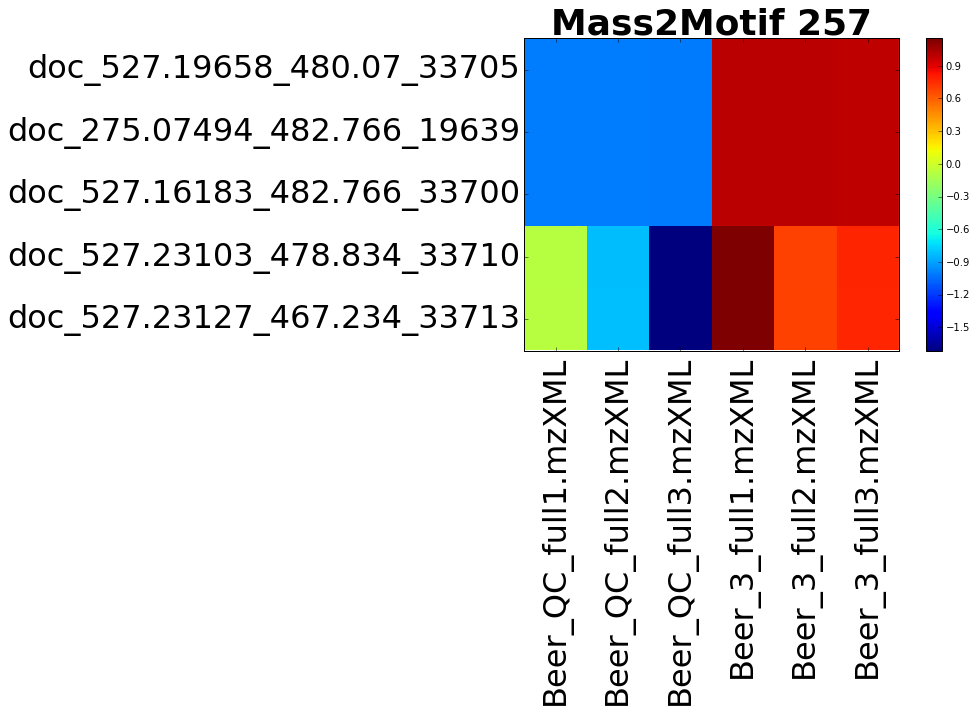

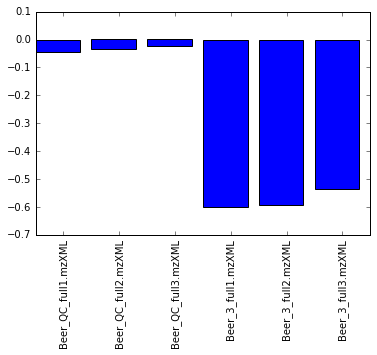

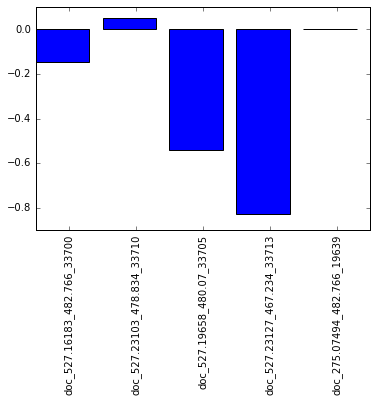

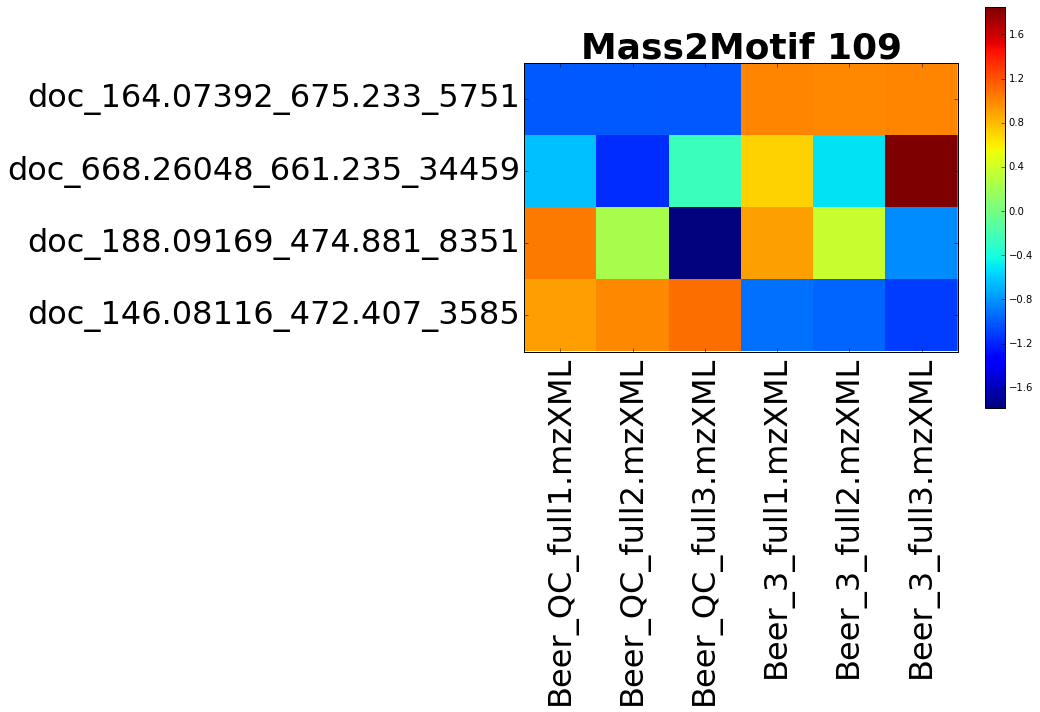

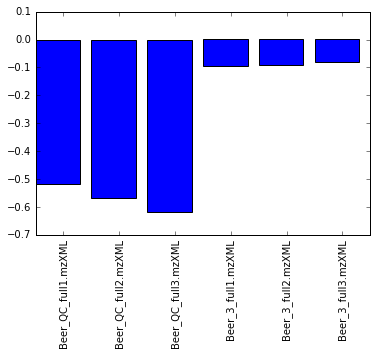

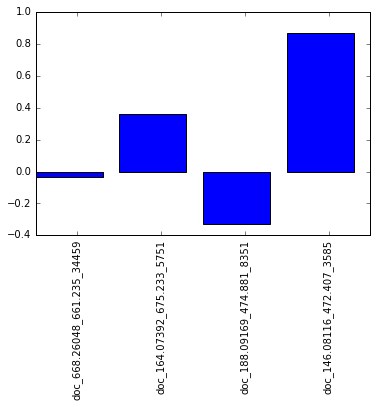

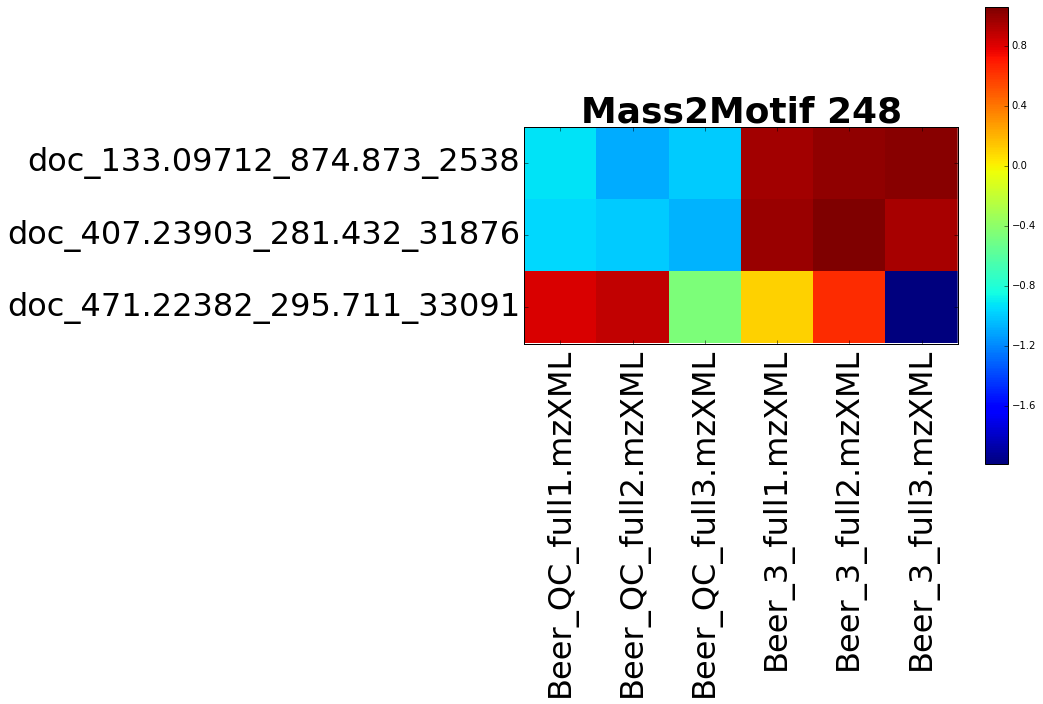

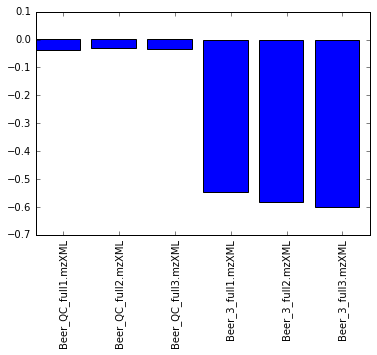

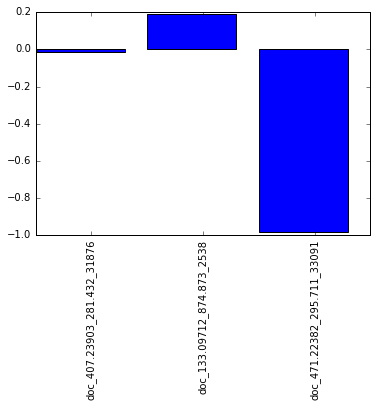

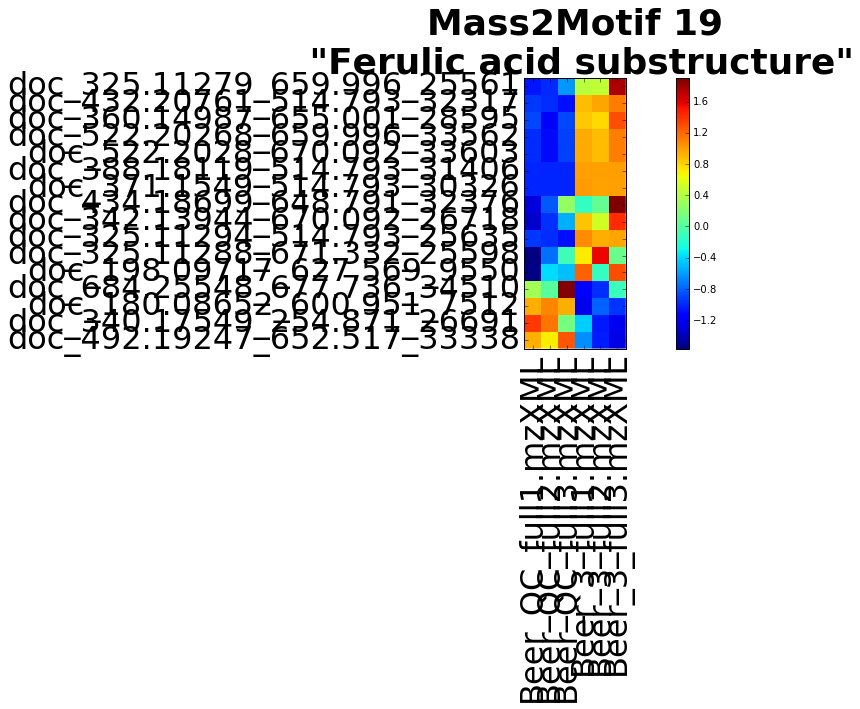

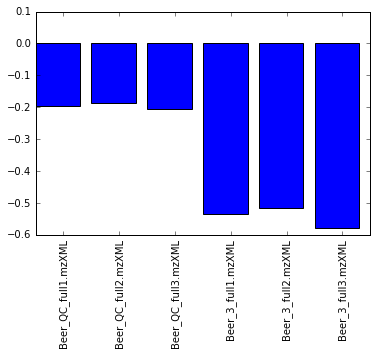

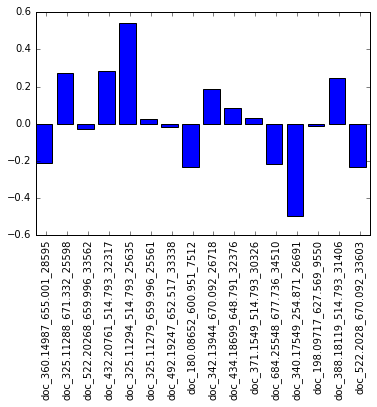

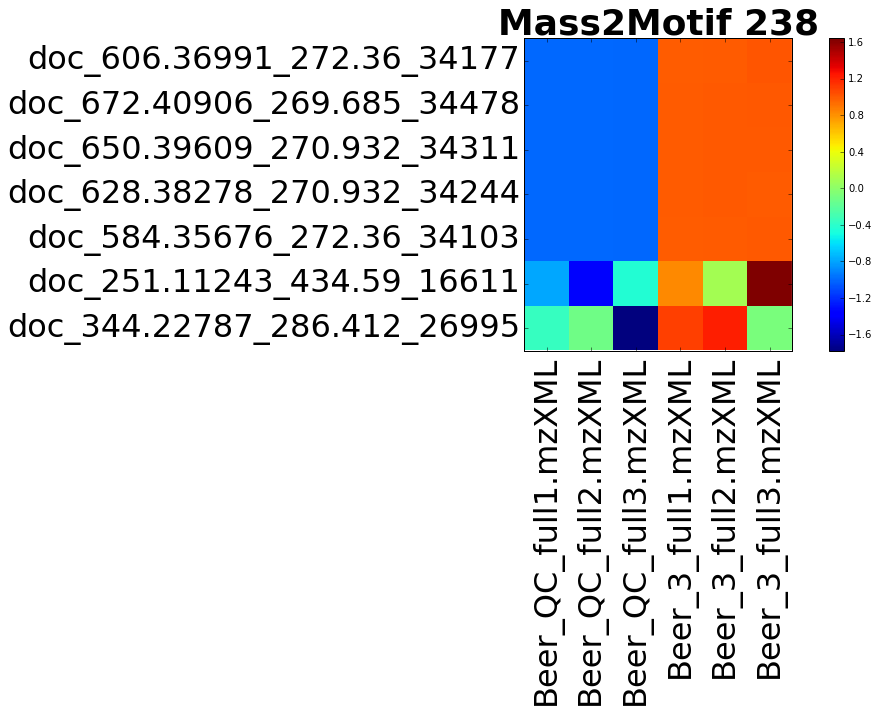

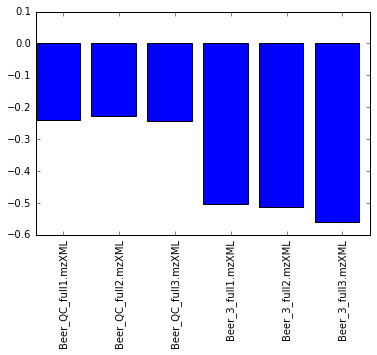

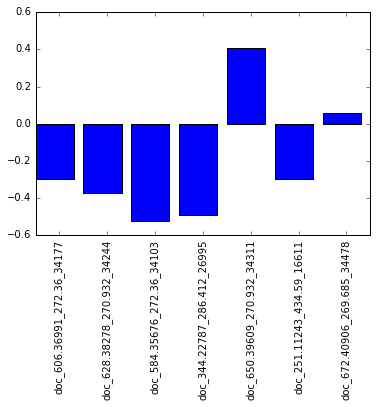

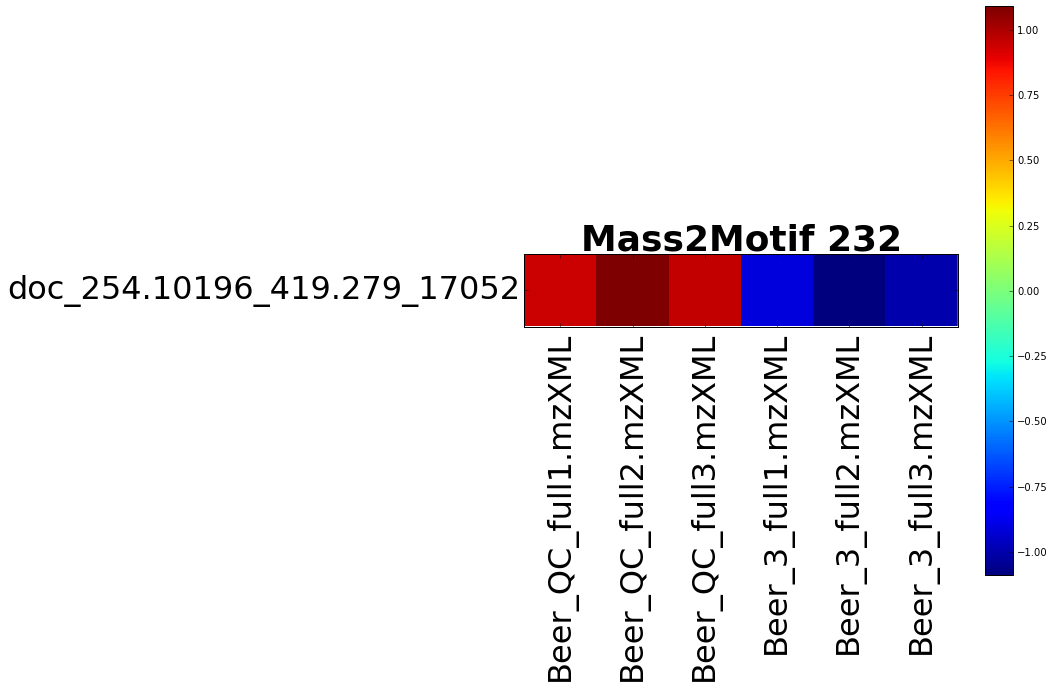

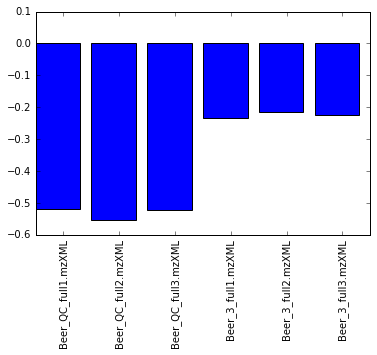

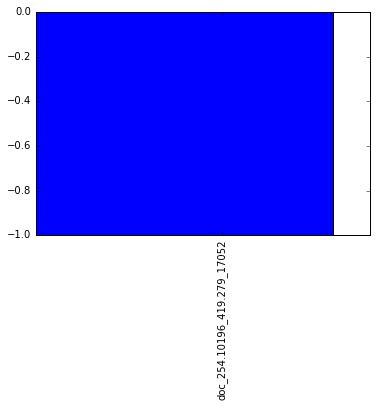

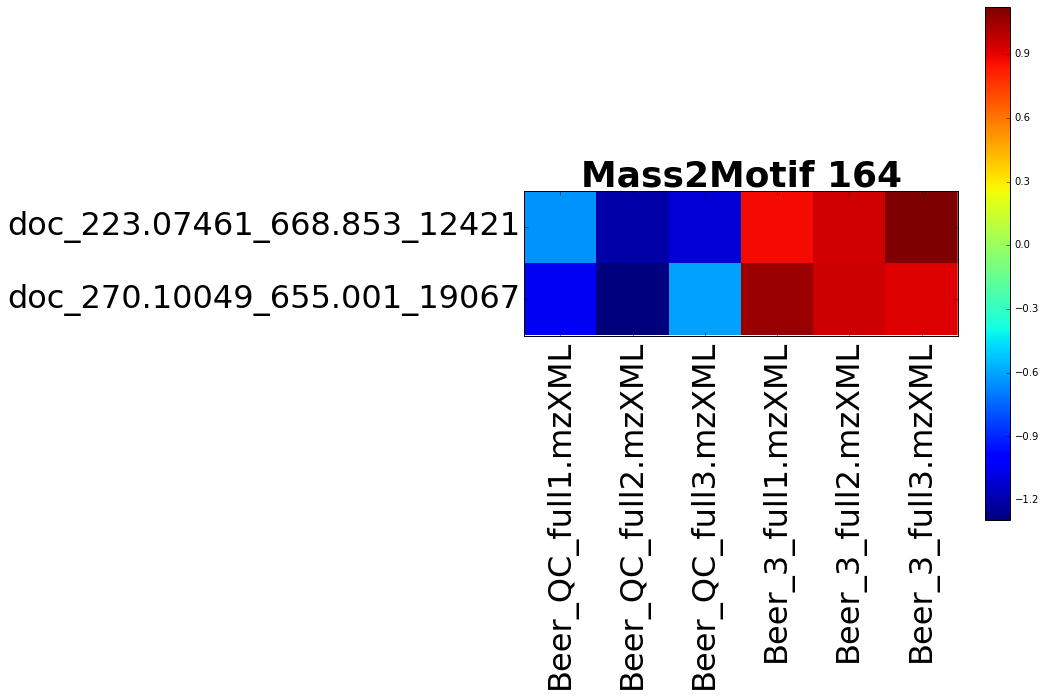

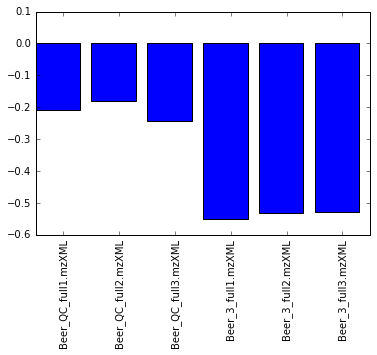

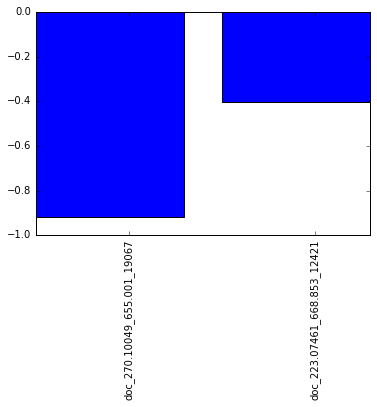

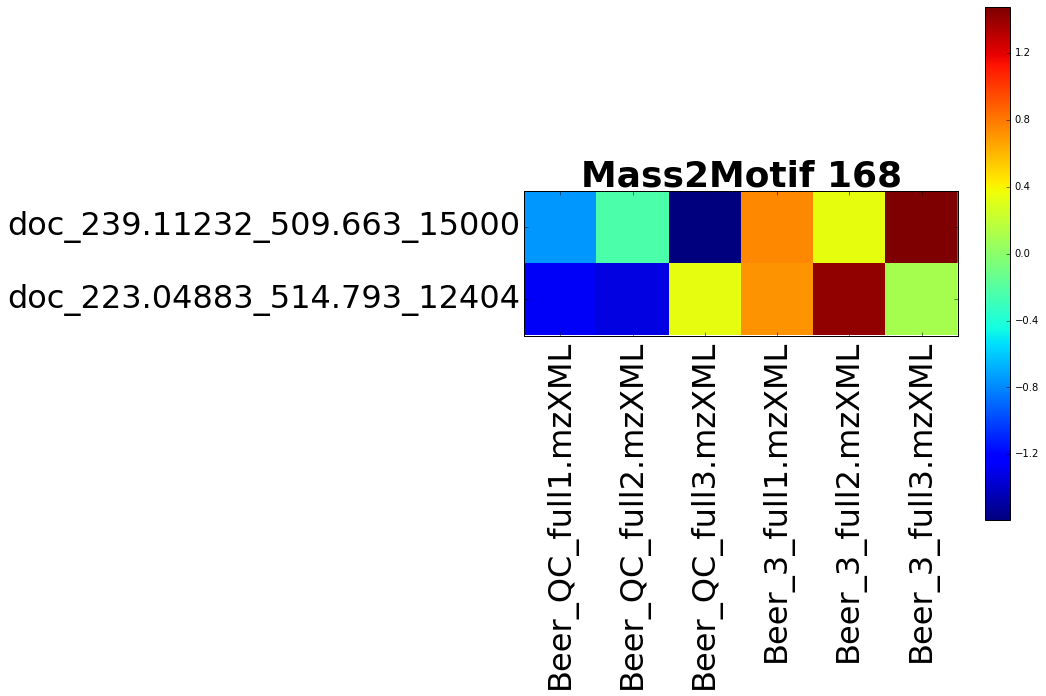

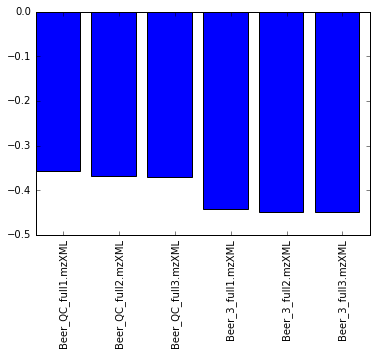

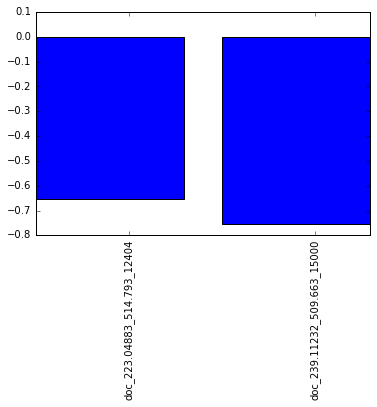

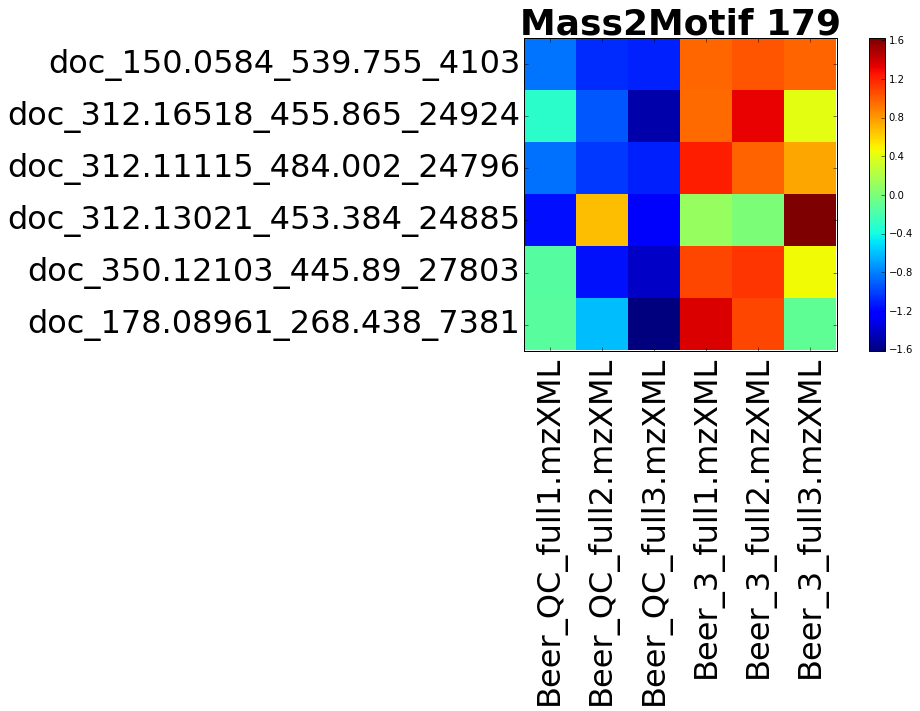

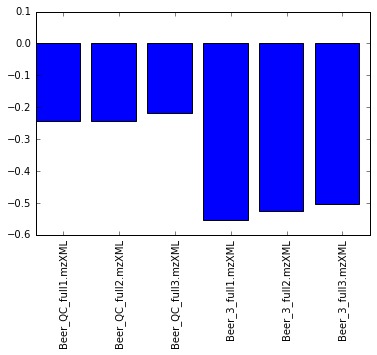

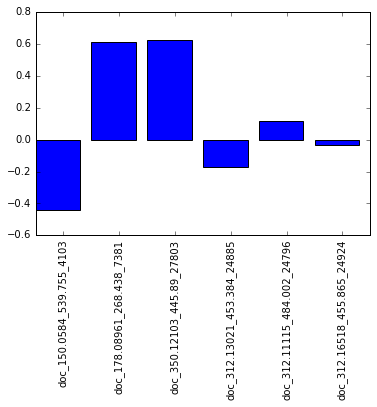

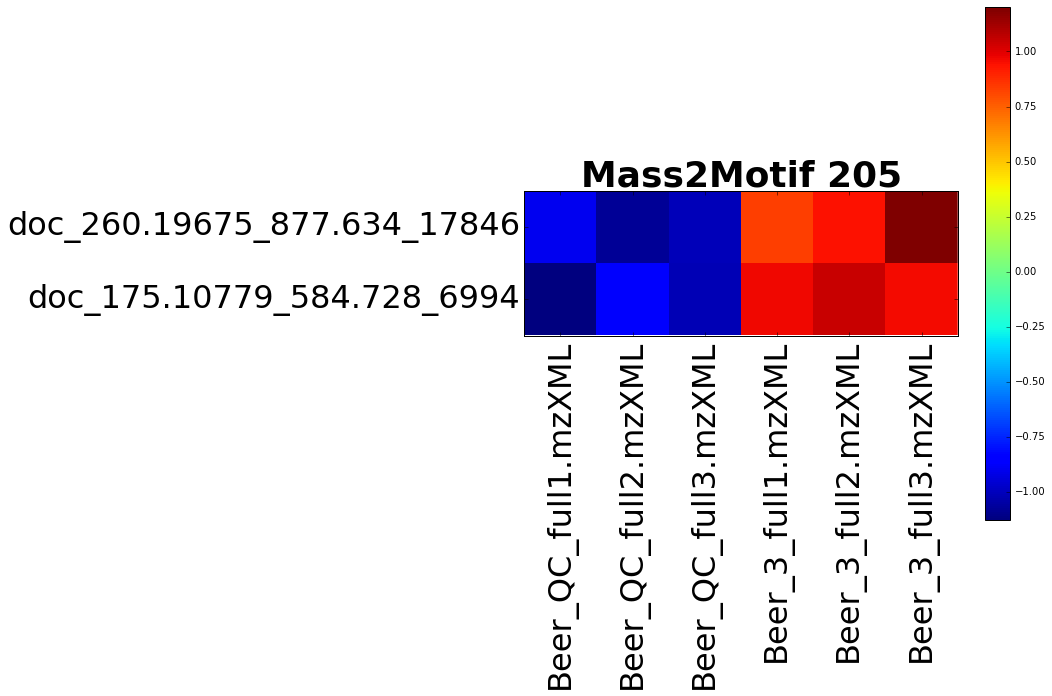

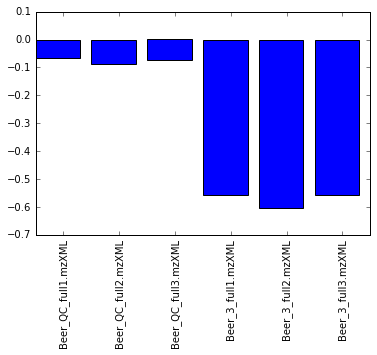

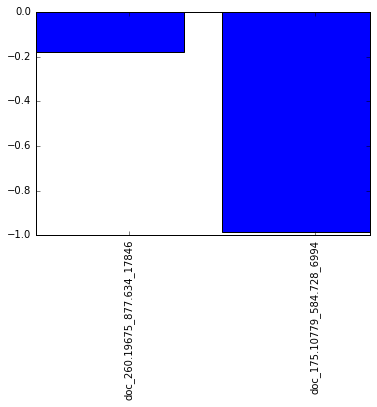

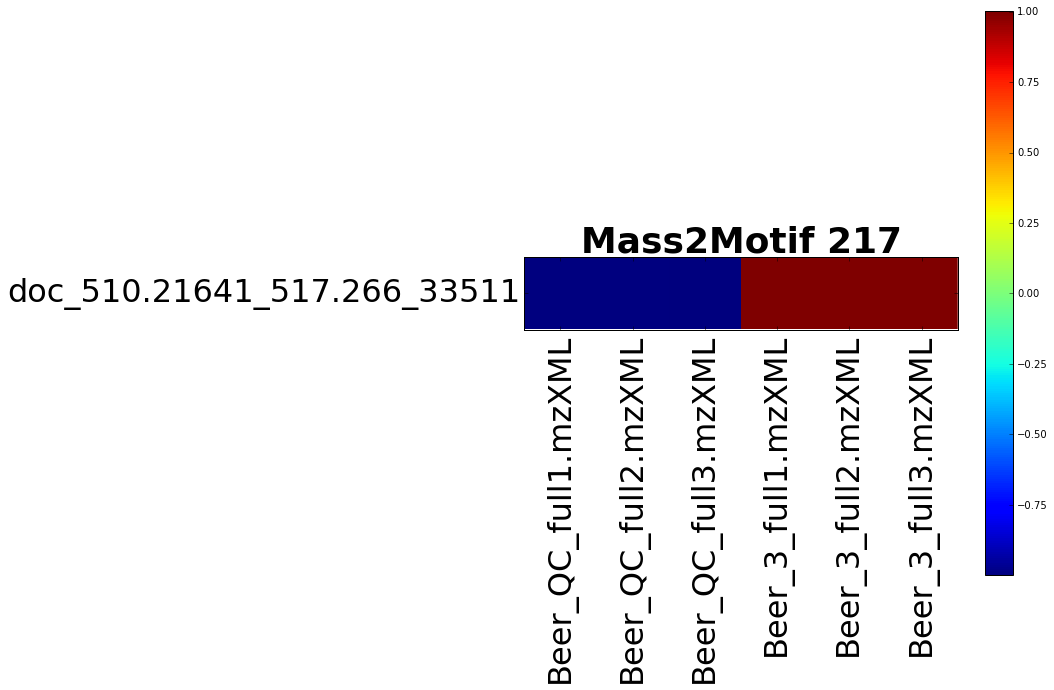

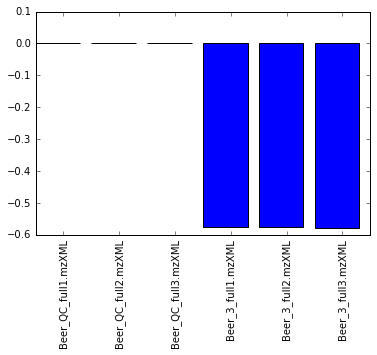

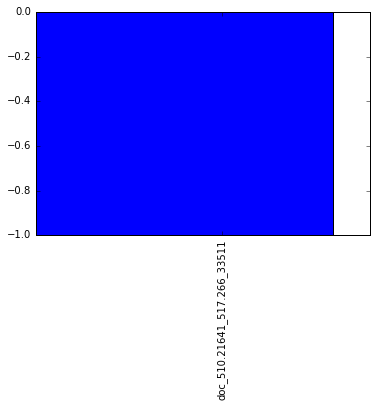

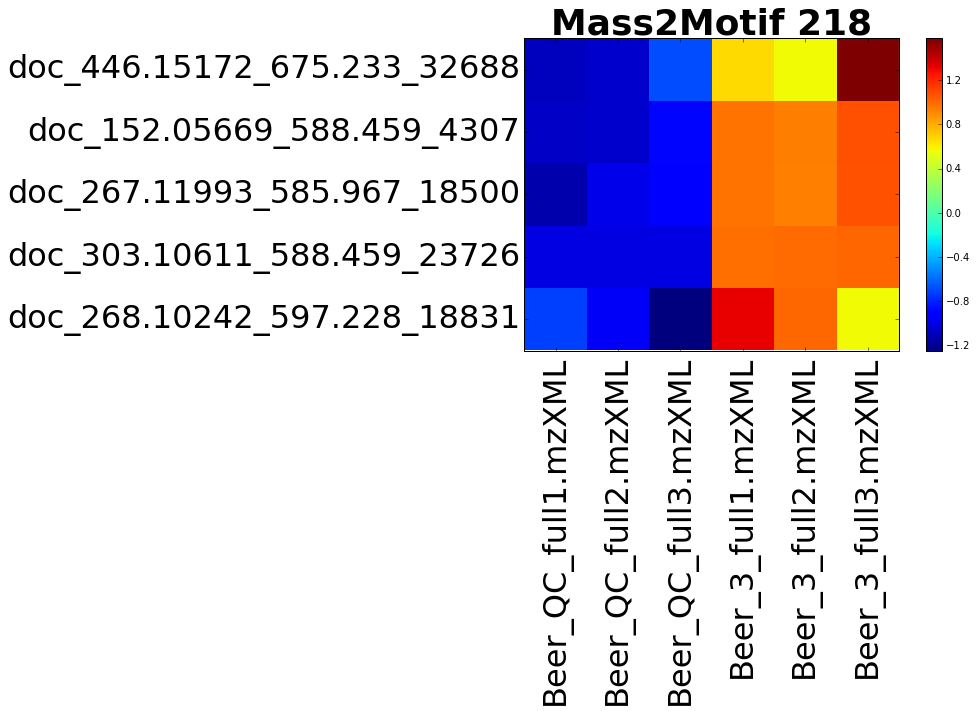

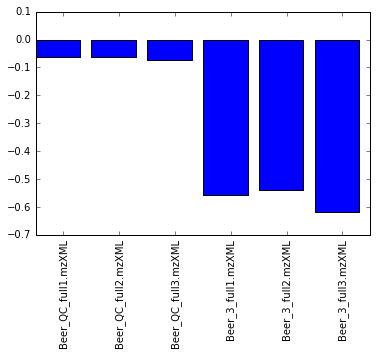

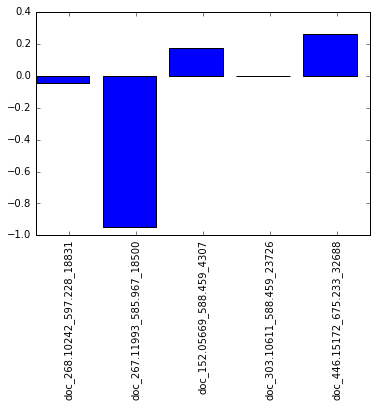

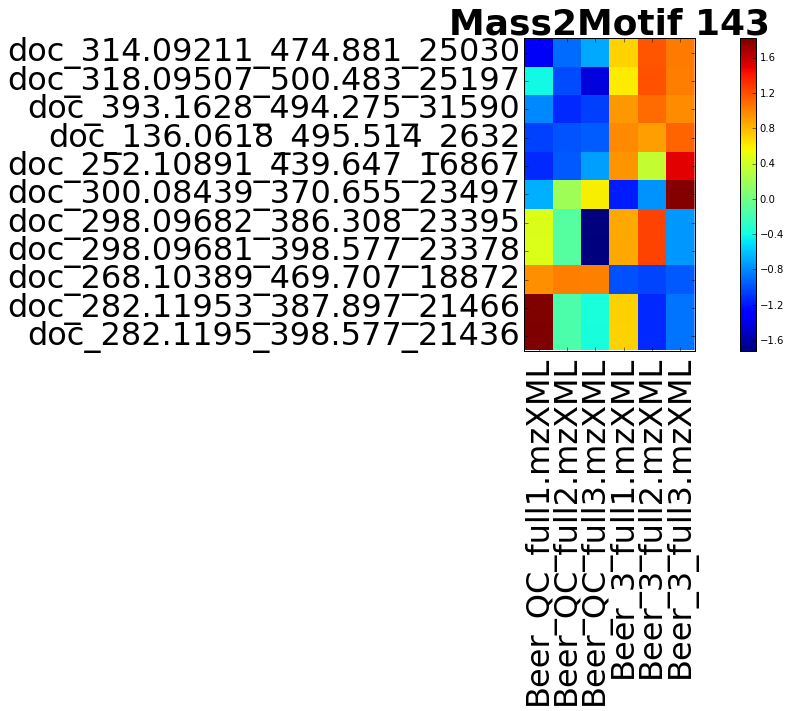

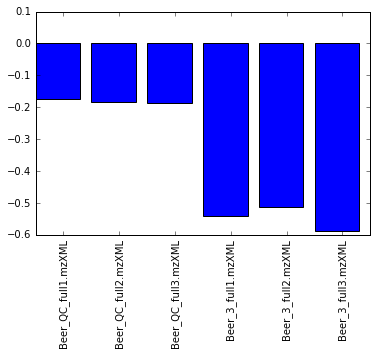

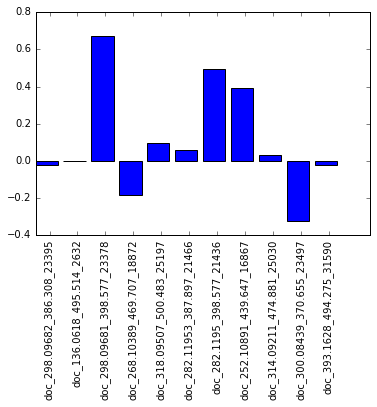

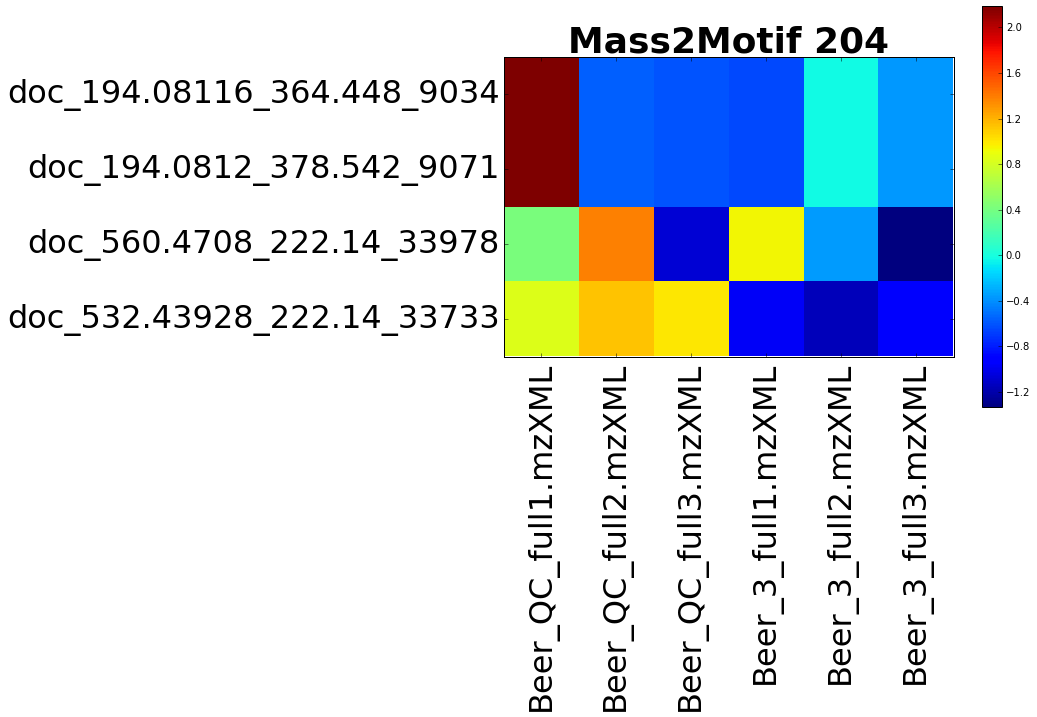

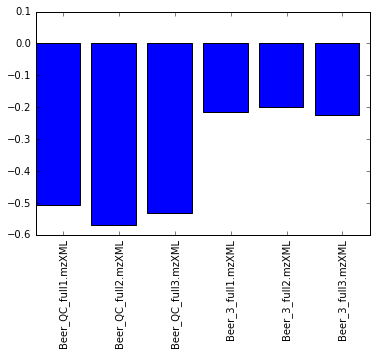

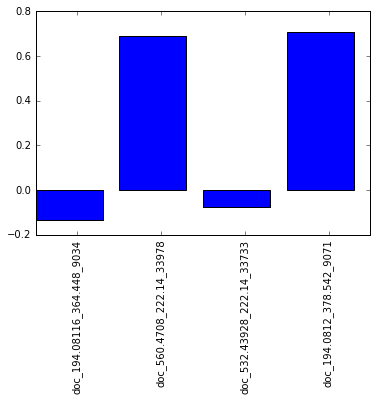

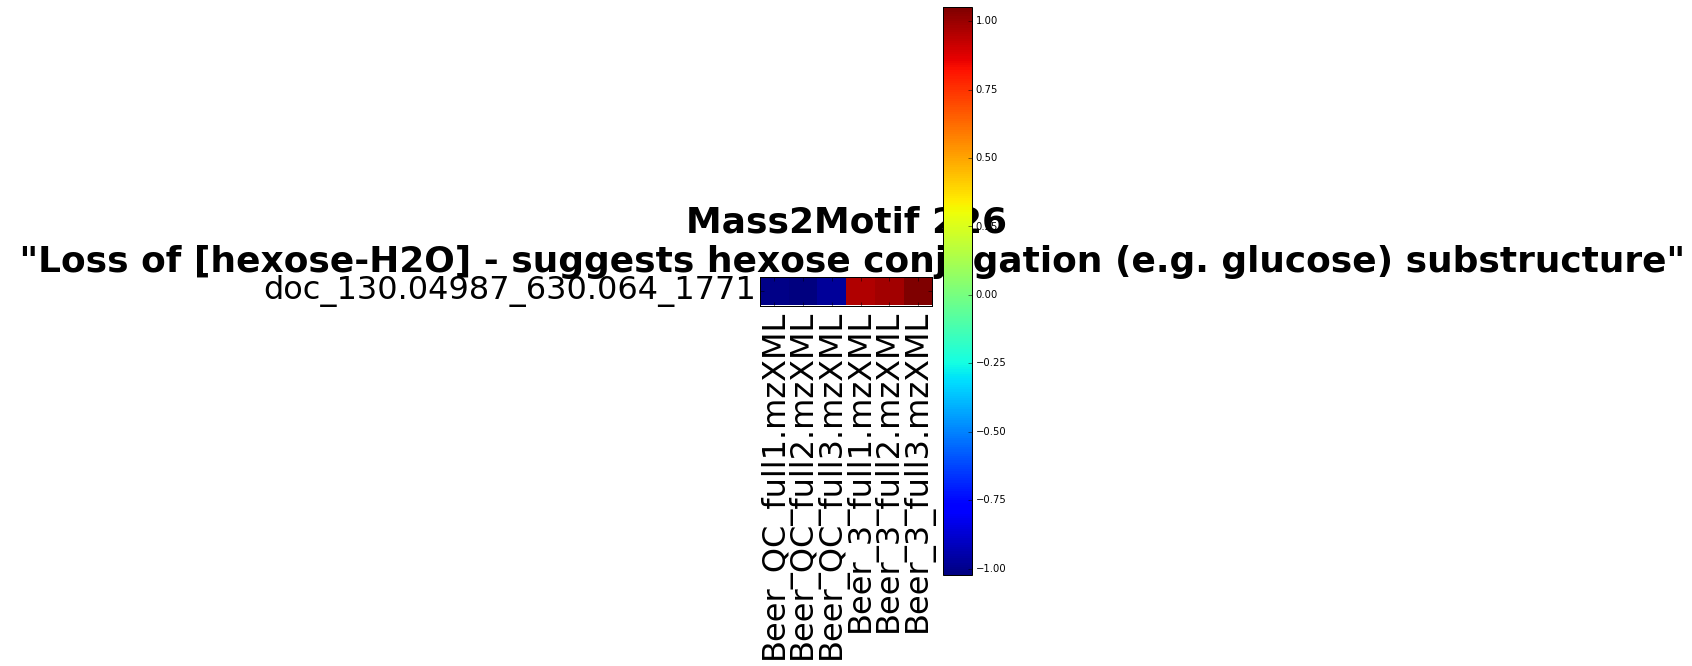

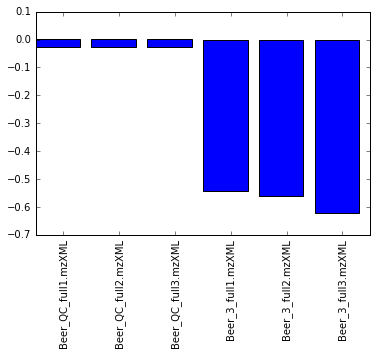

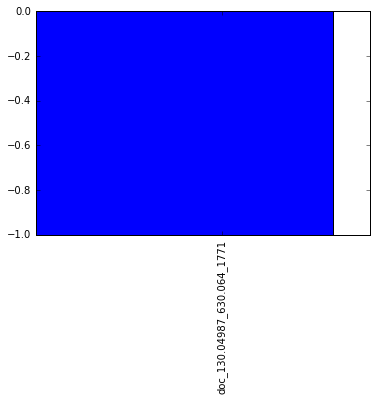

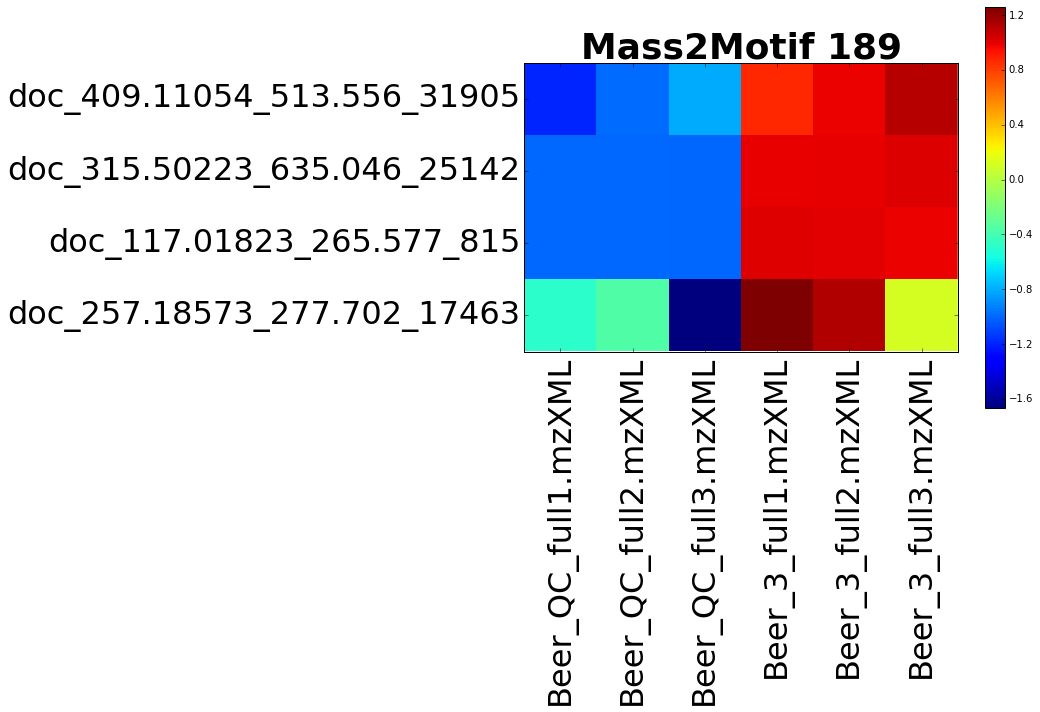

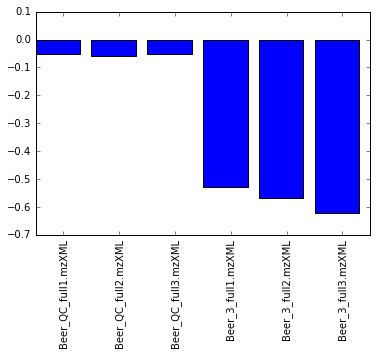

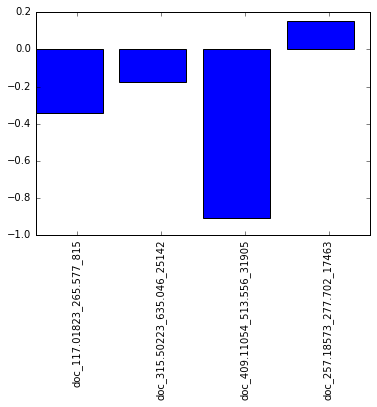

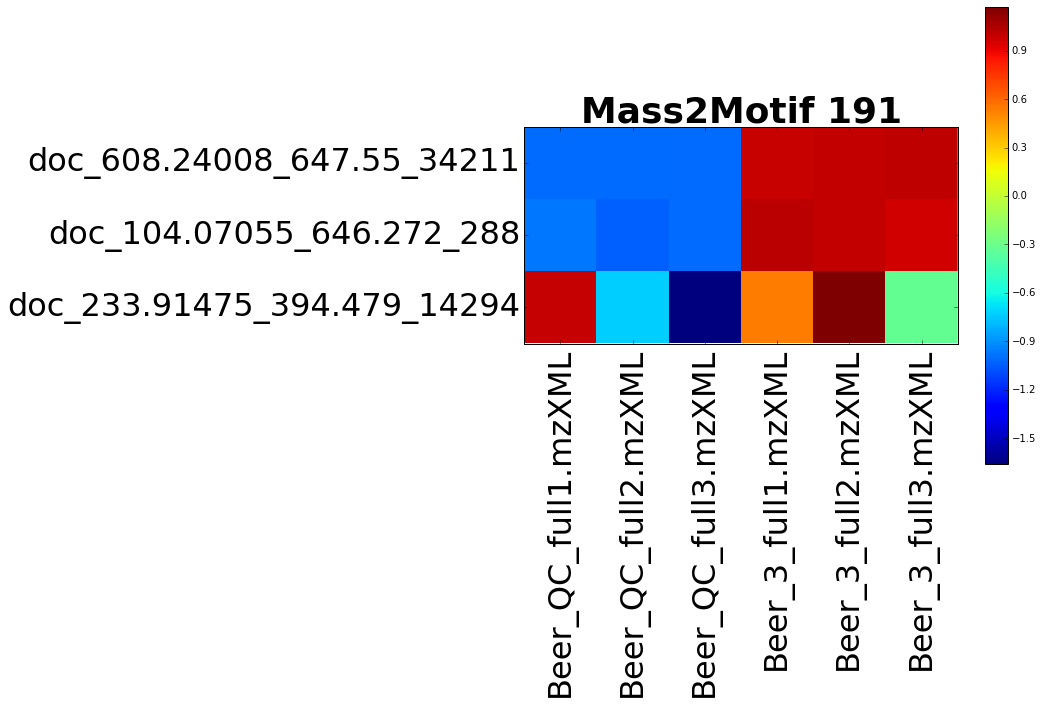

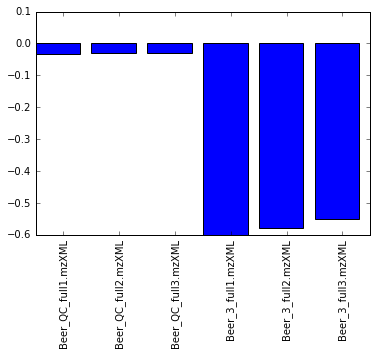

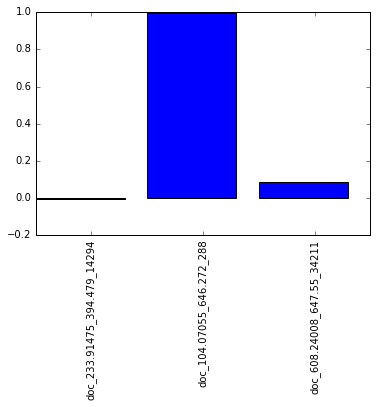

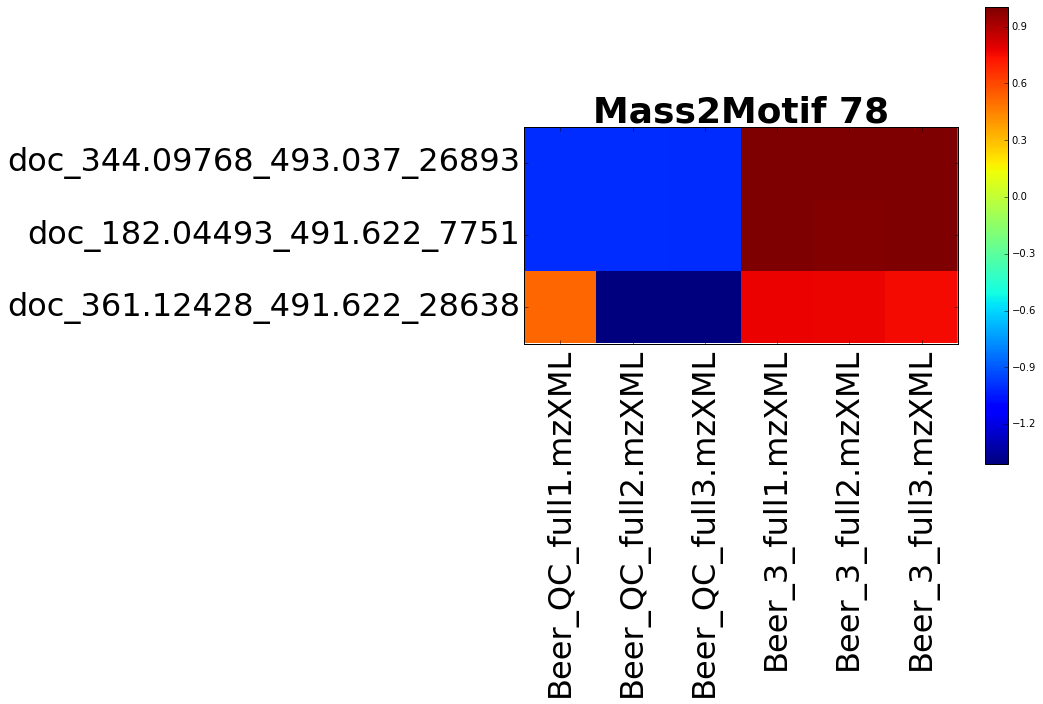

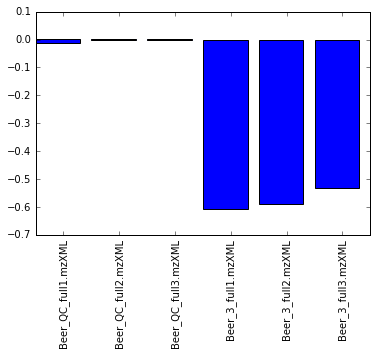

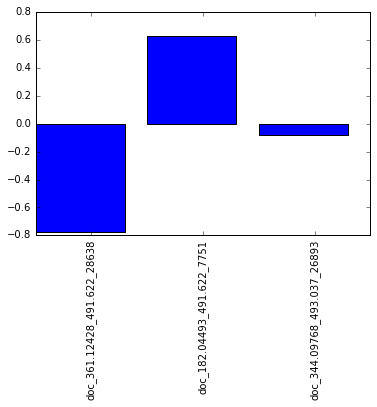

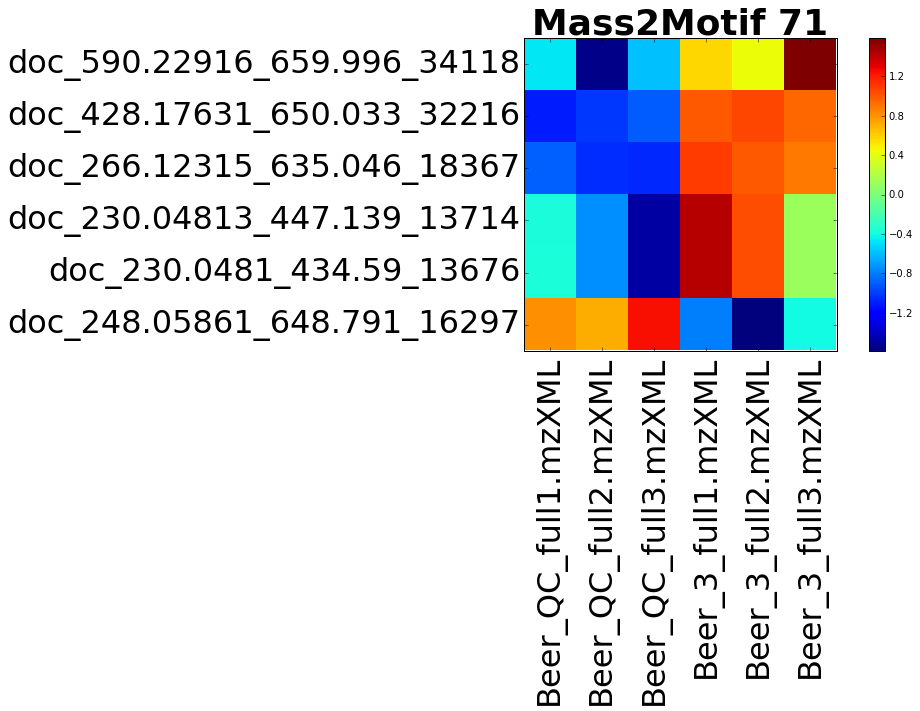

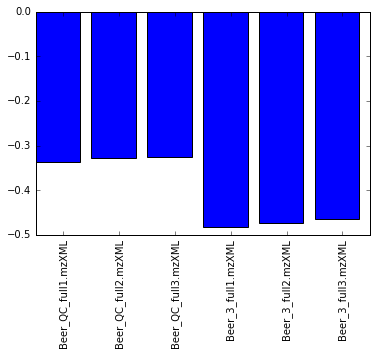

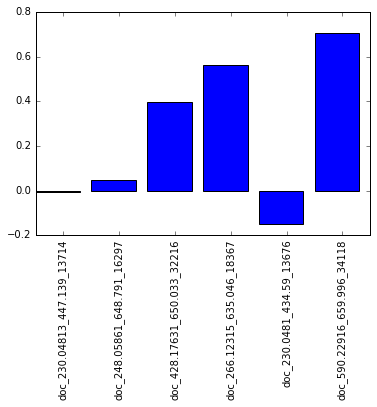

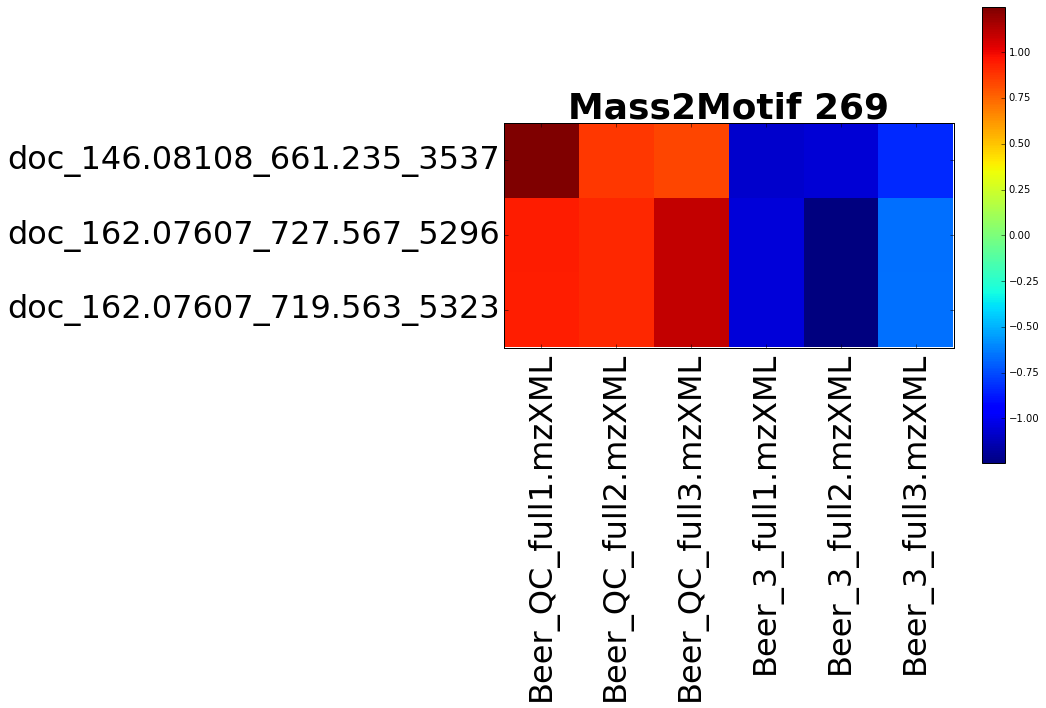

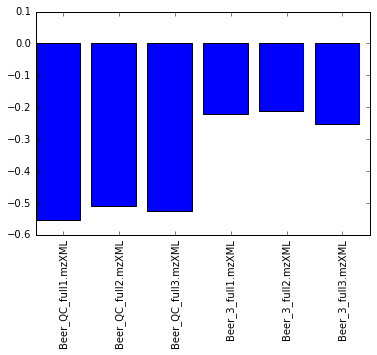

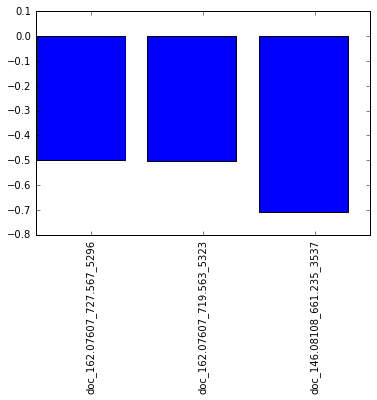

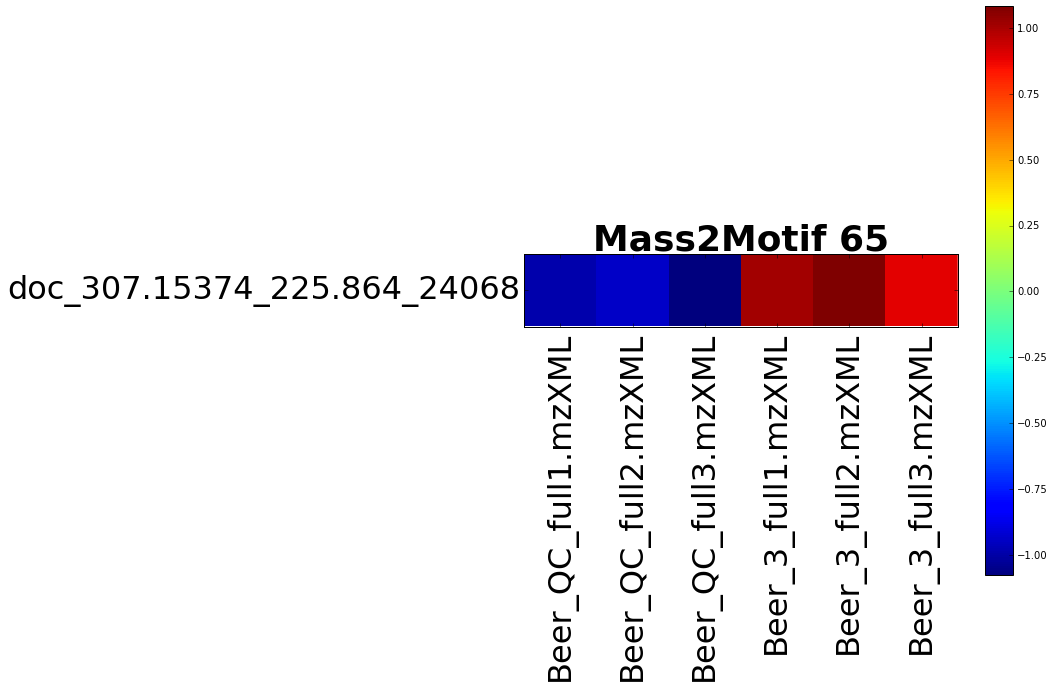

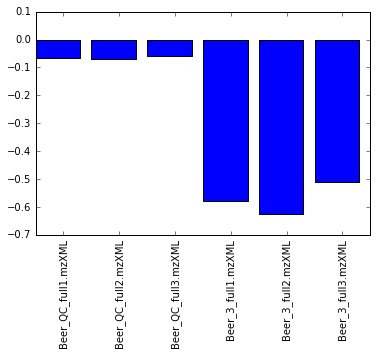

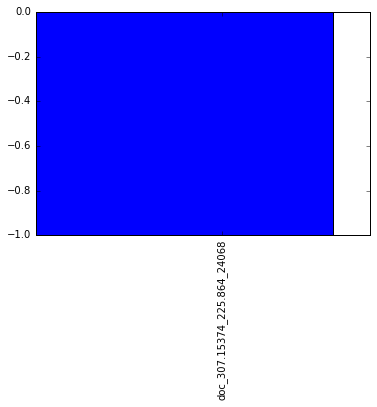

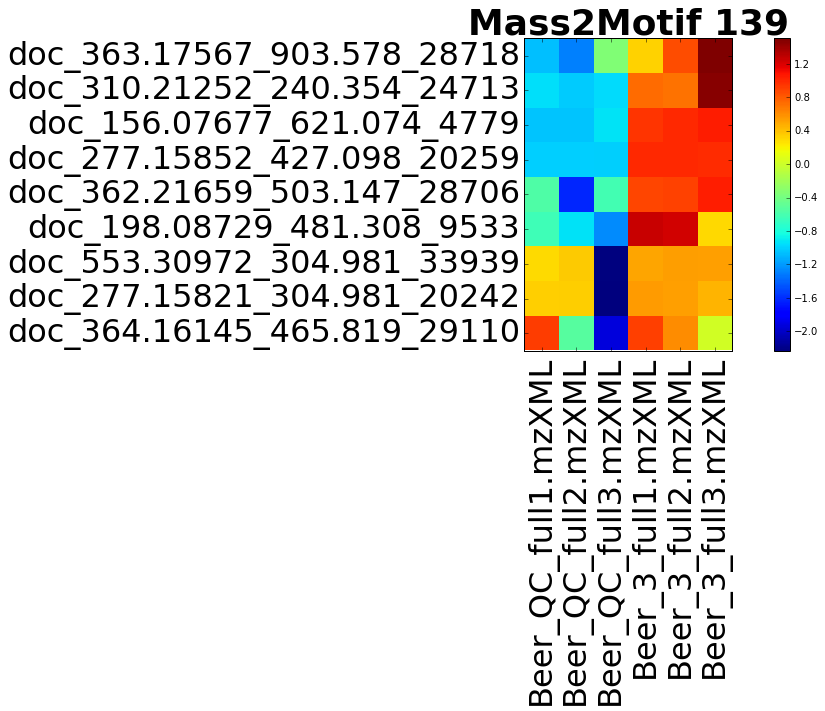

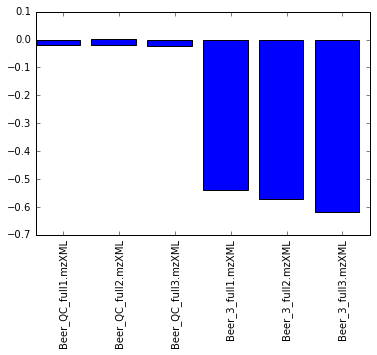

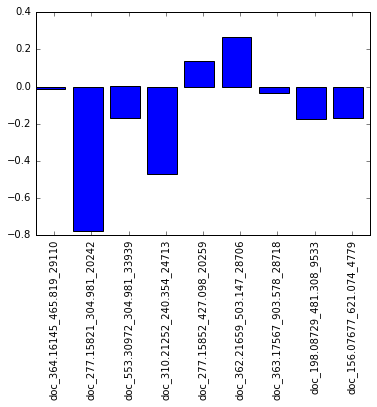

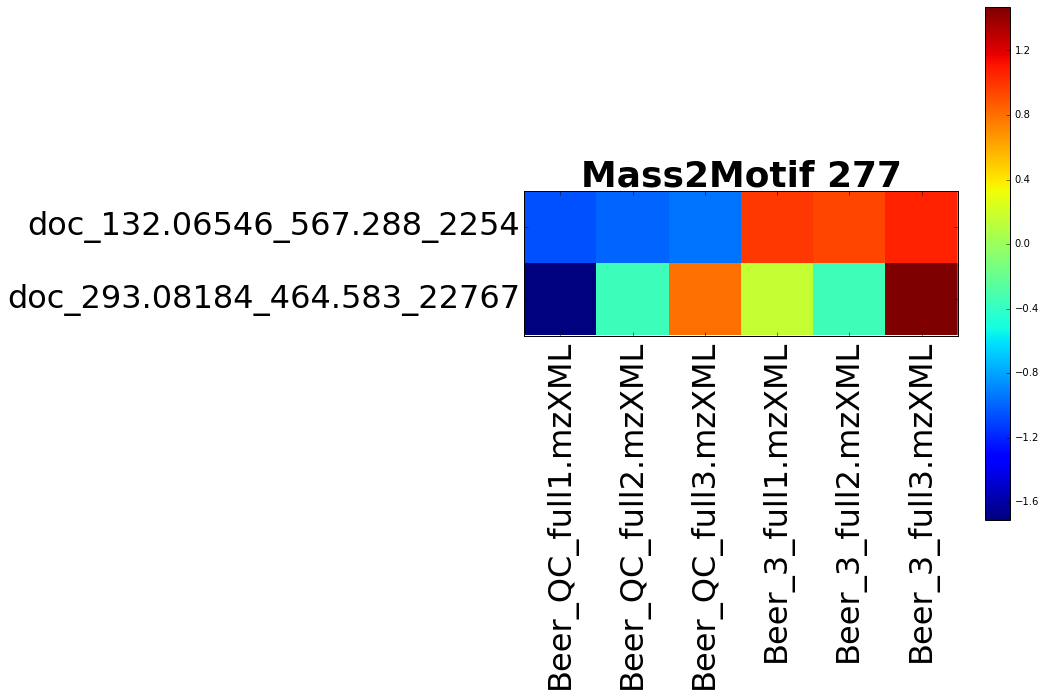

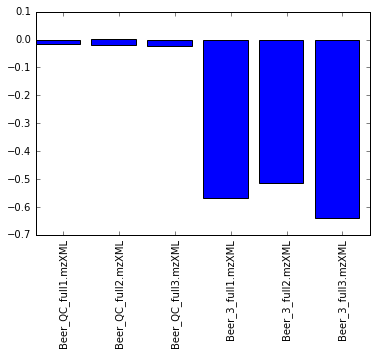

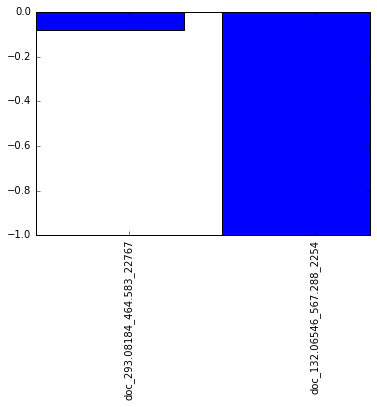

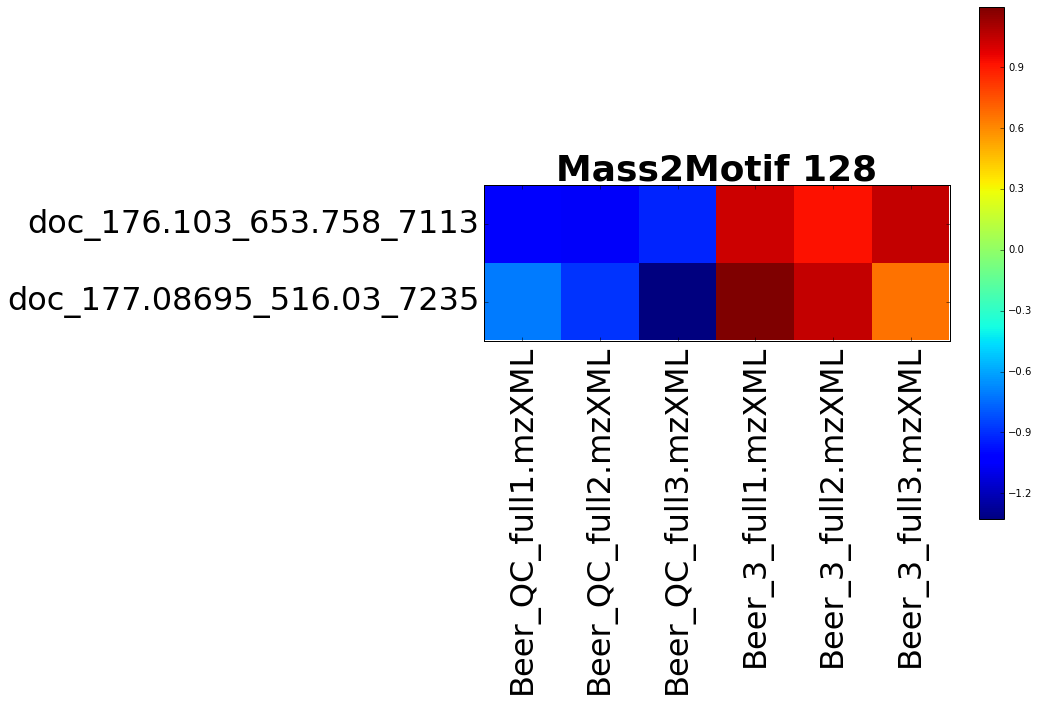

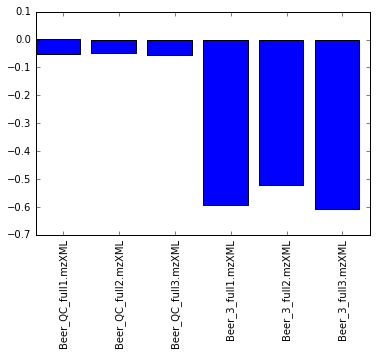

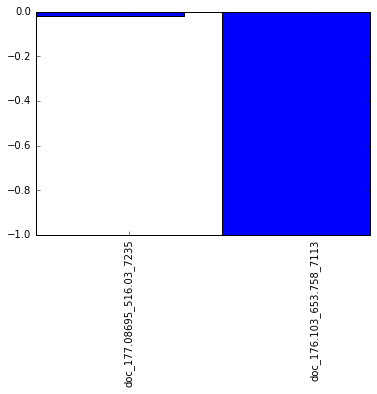

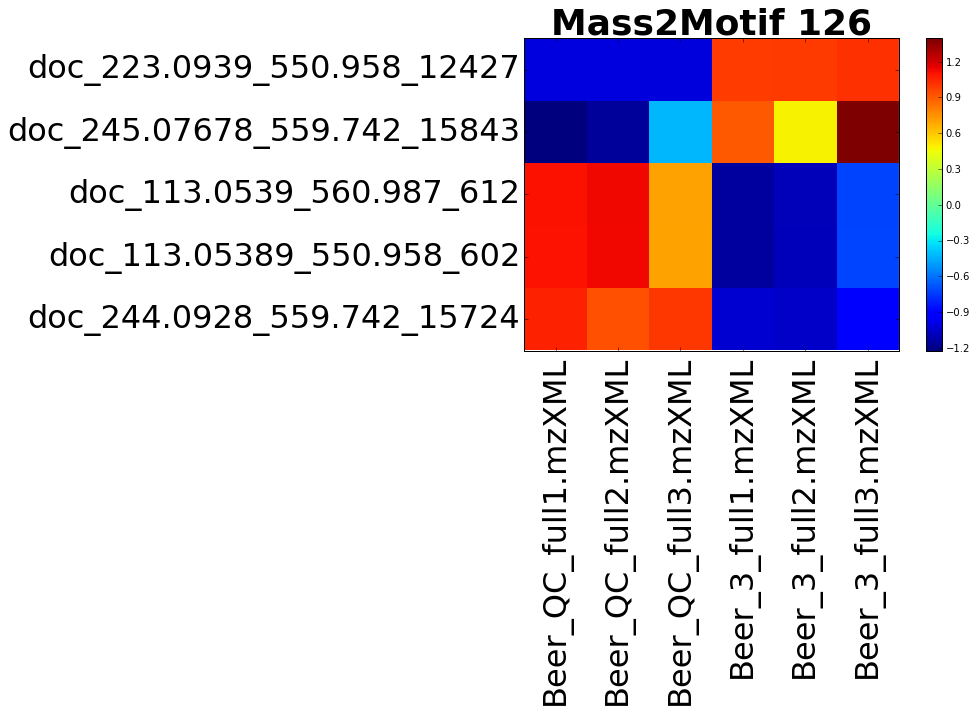

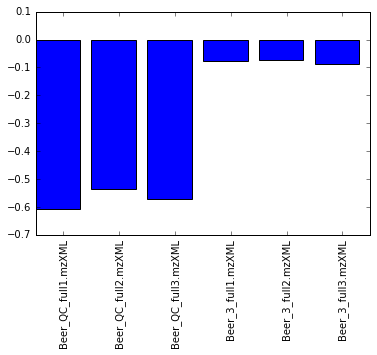

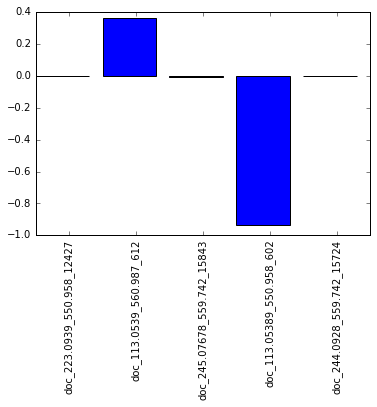

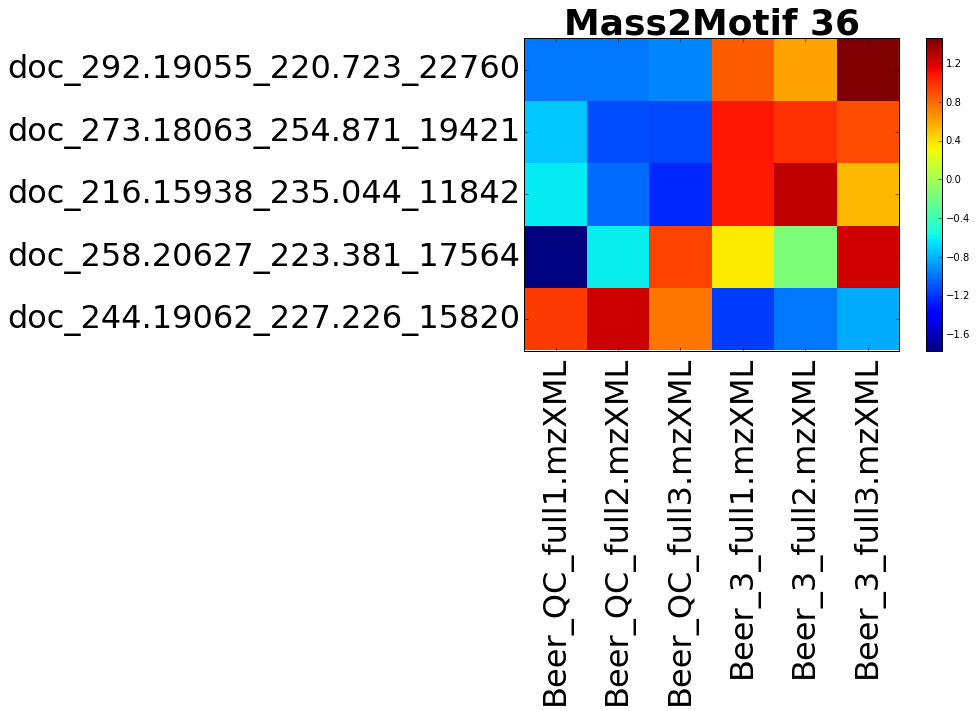

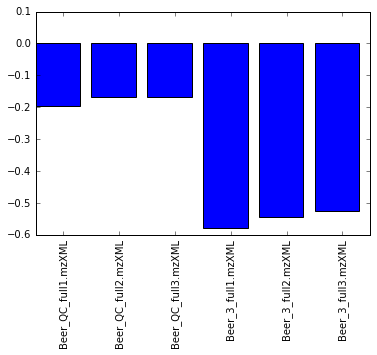

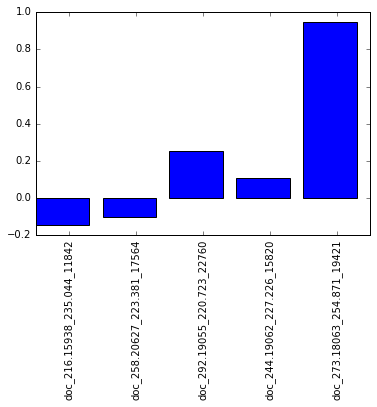

In [17]:
G = turn_clustering_into_graph(peak_names, clustering)
link.create_special_nodes_ms1(control=control, case=case)
_, clustering_scores, peak_clustering_scores, clustering_G = link.compute_topic_t(control=control, case=case, 
                                                          t_thresh=t_thresh, t_annot=t_annot, 
                                                          peak_annot=peak_lda_annot, G=G)